In [15]:
##Imports
%matplotlib inline
import requests
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import json
## This is to get the connection to the nba endpoints correctly (hot fix to work until they push changes)
headers = {
    'Host': 'stats.nba.com',
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:61.0) Gecko/20100101 Firefox/61.0',
    'Accept': 'application/json, text/plain, */*',
    'Accept-Language': 'en-US,en;q=0.5',
    'Referer': 'https://stats.nba.com/',
    'Accept-Encoding': 'gzip, deflate, br',
    'Connection': 'keep-alive',
    'x-nba-stats-origin': 'stats',
    'x-nba-stats-token': 'true'
}

In [16]:
## Build the team name to team_id map
from nba_api.stats.static import teams
nba_teams = teams.get_teams()
list_teams = ['ATL', 'BOS', 'CLE', 'NOP', 'CHI', 'DAL', 'DEN', 'GSW', 'HOU', 'LAC', 'LAL'
        , 'MIA', 'MIL', 'MIN', 'BKN', 'NYK', 'ORL', 'IND', 'PHI', 'PHX', 'POR', 'SAC'
        , 'SAS', 'OKC', 'TOR', 'UTA', 'MEM', 'WAS', 'DET', 'CHA']
i = 0
team_to_id = {}
for t in list_teams:
    team_to_id.update({t: nba_teams[i]['id']})
    i += 1

In [17]:
from nba_api.stats.endpoints import teamgamelog
from nba_api.stats.endpoints import winprobabilitypbp

In [18]:
def plot_game_win_probability(win_probability, title, mode):
    home_pct = win_probability['HOME_PCT'].values
    visit_pct = win_probability['VISITOR_PCT'].values
    ind = range(len(home_pct))
    baseline = [0.5] * len(home_pct)
    plt.plot(ind, home_pct, 'g.')
    plt.plot(ind, visit_pct, 'r^')
    plt.plot(ind, baseline, 'k-')
    plt.title(title)
    if '@' in title:
        plt.legend((title[-3:], title[:3]))
    else:
        plt.legend((title[:3], title[-3:]))
    
    if mode == 'game':
        game_pct = np.abs(home_pct - visit_pct)
        game_inflection = get_inflection_point_occurences(game_pct, 2)
        game_values = game_pct[game_inflection[0:10]]
        
        plt.plot(game_inflection[0:10], game_values, 'bX', markersize=20)
        
        print("Game important plays: ")
        get_influential_plays(win_probability, game_inflection)
    else:
        home_inflection = get_inflection_point_occurences(home_pct, 1)
        visit_inflection = get_inflection_point_occurences(visit_pct, 1)
        hi_values = home_pct[home_inflection[0:10]]
        vi_values = visit_pct[visit_inflection[0:10]]

        plt.plot(home_inflection[0:10], hi_values, 'bX', markersize=20)
        plt.plot(visit_inflection[0:10], vi_values, 'y*', markersize=20)

        print("Home team important plays: ")
        get_influential_plays(win_probability, home_inflection)

        print("Visiting team important plays: ")
        get_influential_plays(win_probability, visit_inflection)       
    plt.show()

In [19]:
def generate_win_probability_team(team, mode):
    gpbp = teamgamelog.TeamGameLog(team_id=team_to_id[team], headers=headers)
    tgl = gpbp.get_data_frames()[0]
    games = tgl['Game_ID'].values
    matchups = tgl['MATCHUP'].values
    i = 0
    for game in games:
        wpp = winprobabilitypbp.WinProbabilityPBP(game_id=game, headers=headers)
        wp = wpp.get_data_frames()[0]
        plot_game_win_probability(wp, matchups[i], mode)
        i += 1

In [20]:
def get_inflection_point_occurences(team_data, derivative_type):
    second_deriv = np.diff(team_data, n=derivative_type).tolist()
    second_deriv_sorted = sorted(second_deriv, reverse=True)
    inflection_occurences = []
    for i in second_deriv_sorted:
        inflection_occurences.append(second_deriv.index(i) + 2)
    return inflection_occurences    

def get_influential_plays(wp, inflection_occurences):
    number = 10
    events = wp['EVENT_NUM'].values
    descriptions = wp['DESCRIPTION'].values
    quarter = wp['PERIOD'].values
    time_in_quarter = wp['SECONDS_REMAINING'].values
    
    event_inflect = events[inflection_occurences]
    desc_inflect = descriptions[inflection_occurences]
    quarter_inflect = quarter[inflection_occurences]
    tiq_inflect = time_in_quarter[inflection_occurences]

    print("Top turning point descriptions: ")
    for i in range(len(desc_inflect)):
        d = desc_inflect[i]
        if d is not None:
            number = number - 1
            print('With %s seconds left in quarter %s: %s' % (tiq_inflect[i], quarter_inflect[i], d))
        if number <= 0:
            break
    print("Done")

Game important plays: 
Top turning point descriptions: 
With 188.0 seconds left in quarter 3: Leonard 26' 3PT Jump Shot (20 PTS) (Williams 5 AST)
With 84.0 seconds left in quarter 4: Olynyk Free Throw 2 of 2 (19 PTS)
With 331.0 seconds left in quarter 3: Butler Free Throw Flagrant 1 of 3 (16 PTS)
With 71.0 seconds left in quarter 3: Green 25' 3PT Jump Shot (14 PTS) (Shamet 5 AST)
With 632.0 seconds left in quarter 3: Robinson 26' 3PT Jump Shot (12 PTS) (Adebayo 5 AST)
With 8.0 seconds left in quarter 4: Leonard Free Throw 1 of 2 (32 PTS)
With 176.0 seconds left in quarter 2: Robinson 25' 3PT Jump Shot (9 PTS) (Adebayo 2 AST)
With 117.0 seconds left in quarter 3: Harrell 2' Dunk (13 PTS) (Williams 6 AST)
With 43.0 seconds left in quarter 3: Williams 24' 3PT Jump Shot (8 PTS) (Leonard 10 AST)
With 411.0 seconds left in quarter 3: Butler 7' Pullup Jump Shot (13 PTS)
Done


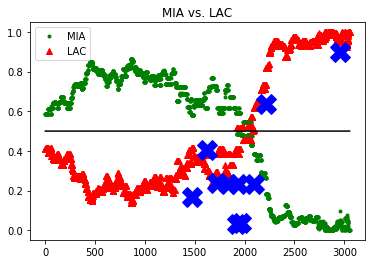

Game important plays: 
Top turning point descriptions: 
With 35.0 seconds left in quarter 4: Wizards Timeout: Regular (Reg.6 Short 0)
With 252.0 seconds left in quarter 5: Herro  3PT Jump Shot (25 PTS) (Dragic 10 AST)
With 76.0 seconds left in quarter 4: Beal REBOUND (Off:1 Def:7)
With 27.0 seconds left in quarter 4: Jones Jr. REBOUND (Off:1 Def:2)
With 31.0 seconds left in quarter 4: MISS Mahinmi 3' Cutting Layup Shot#@#Johnson BLOCK (2 BLK)
With 53.0 seconds left in quarter 4: MISS Smith 15' Jump Shot
With 81.0 seconds left in quarter 4: Dragic REBOUND (Off:1 Def:4)
With 78.0 seconds left in quarter 4: MISS Johnson 26' 3PT Jump Shot
With 51.0 seconds left in quarter 4: Adebayo REBOUND (Off:1 Def:6)
With 35.0 seconds left in quarter 4: Johnson 24' 3PT Jump Shot (7 PTS) (Herro 2 AST)
Done


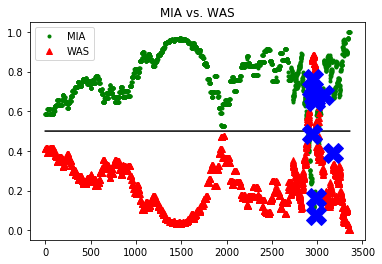

Game important plays: 
Top turning point descriptions: 
With 0.0 seconds left in quarter 4: SUB: Jones Jr. FOR Dragic
With 1.0 seconds left in quarter 4: Bjelica 1' Putback Layup (22 PTS)
With 26.0 seconds left in quarter 5: Out-of-Bounds
With 207.0 seconds left in quarter 4: Adebayo 1' Tip Dunk Shot (9 PTS)
With 125.0 seconds left in quarter 5: Fox 1' Driving Finger Roll Layup (14 PTS)
With 15.0 seconds left in quarter 5: HEAT Rebound
With 198.0 seconds left in quarter 4: Bjelica 8' Driving Floating Jump Shot (17 PTS) (Fox 6 AST)
With 571.0 seconds left in quarter 4: Ferrell 25' 3PT Step Back Jump Shot (3 PTS)
With 48.0 seconds left in quarter 5: Johnson REBOUND (Off:0 Def:6)
With 254.0 seconds left in quarter 3: Nunn 25' 3PT Jump Shot (16 PTS) (Jones Jr. 1 AST)
Done


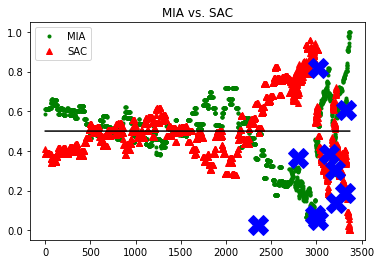

Game important plays: 
Top turning point descriptions: 
With 638.0 seconds left in quarter 4: White 25' 3PT Jump Shot (9 PTS) (Walker IV 2 AST)
With 688.0 seconds left in quarter 4: Jones Jr. 1' Tip Dunk Shot (6 PTS)
With 82.0 seconds left in quarter 4: Butler Free Throw 2 of 2 (16 PTS)
With 31.0 seconds left in quarter 3: Mills 25' 3PT Pullup Jump Shot (17 PTS)
With 202.0 seconds left in quarter 4: Adebayo Bad Pass Turnover (P2.T10)#@#White STEAL (2 STL)
With 318.0 seconds left in quarter 4: Dragic 7' Driving Floating Bank Jump Shot (19 PTS)
With 127.0 seconds left in quarter 4: Belinelli  3PT Jump Shot (10 PTS) (DeRozan 9 AST)
With 220.0 seconds left in quarter 4: Leonard L.B.FOUL (P3.PN) (M.Davis)
With 457.0 seconds left in quarter 3: Butler S.FOUL (P3.T1) (C.Washington)
With 56.0 seconds left in quarter 3: DeRozan 7' Floating Jump Shot (18 PTS)
Done


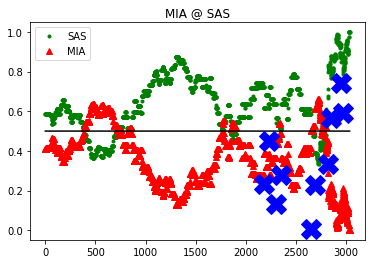

Game important plays: 
Top turning point descriptions: 
With 247.0 seconds left in quarter 4: Gallinari Free Throw 2 of 2 (26 PTS)
With 322.0 seconds left in quarter 2: Nunn  3PT Jump Shot (8 PTS) (Adebayo 2 AST)
With 107.0 seconds left in quarter 2: Robinson  3PT Jump Shot (11 PTS) (Butler 5 AST)
With 228.0 seconds left in quarter 4: Nunn 14' Floating Jump Shot (22 PTS) (Adebayo 5 AST)
With 99.0 seconds left in quarter 3: Olynyk 25' 3PT Jump Shot (7 PTS) (Dragic 3 AST)
With 178.0 seconds left in quarter 3: Adebayo Free Throw 1 of 2 (19 PTS)
With 47.0 seconds left in quarter 1: Robinson 26' 3PT Jump Shot (8 PTS) (Olynyk 1 AST)
With 232.0 seconds left in quarter 1: Butler 26' 3PT Jump Shot (7 PTS) (Nunn 1 AST)
With 647.0 seconds left in quarter 4: Dragic 26' 3PT Jump Shot (8 PTS) (Robinson 3 AST)
With 293.0 seconds left in quarter 4: SUB: Jones Jr. FOR Olynyk
Done


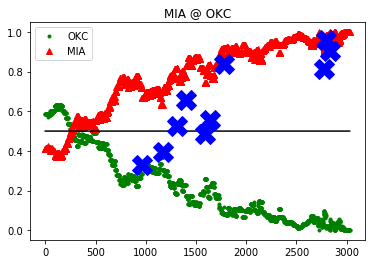

Game important plays: 
Top turning point descriptions: 
With 627.0 seconds left in quarter 4: Robinson 24' 3PT Jump Shot (11 PTS) (Leonard 2 AST)
With 680.0 seconds left in quarter 3: Leonard 25' 3PT Jump Shot (3 PTS) (Nunn 2 AST)
With 576.0 seconds left in quarter 2: Dragic 25' 3PT Step Back Jump Shot (9 PTS)
With 39.0 seconds left in quarter 2: Nunn 25' 3PT Jump Shot (20 PTS) (Adebayo 4 AST)
With 43.0 seconds left in quarter 3: Jones Jr. 1' Cutting Dunk Shot (5 PTS) (Dragic 4 AST)
With 204.0 seconds left in quarter 2: Nunn 26' 3PT Jump Shot (15 PTS) (Butler 3 AST)
With 97.0 seconds left in quarter 4: White Lost Ball Turnover (P1.T7)#@#Leonard STEAL (1 STL)
With 324.0 seconds left in quarter 4: Butler 30' 3PT Pullup Jump Shot (9 PTS)
With 32.0 seconds left in quarter 3: Dragic S.FOUL (P2.T2) (K.Mauer)
With 184.0 seconds left in quarter 4: DeRozan Free Throw 1 of 1 (28 PTS)
Done


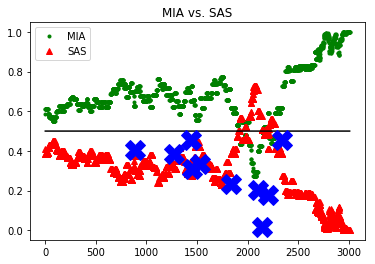

Game important plays: 
Top turning point descriptions: 
With 21.0 seconds left in quarter 4: Butler Free Throw 2 of 3 (25 PTS)
With 17.0 seconds left in quarter 4: Barrett REBOUND (Off:0 Def:5)
With 2.0 seconds left in quarter 4: Butler Bad Pass Turnover (P1.T15)#@#Barrett STEAL (2 STL)
With 338.0 seconds left in quarter 4: Robinson  3PT Jump Shot (11 PTS) (Adebayo 3 AST)
With 356.0 seconds left in quarter 4: Heat Timeout: Regular (Reg.5 Short 0)
With 98.0 seconds left in quarter 4: Gibson Free Throw 2 of 2 (14 PTS)
With 136.0 seconds left in quarter 4: Randle 25' 3PT Jump Shot (22 PTS) (Payton 5 AST)
With 308.0 seconds left in quarter 4: Nunn 24' 3PT Jump Shot (20 PTS) (Adebayo 4 AST)
With 587.0 seconds left in quarter 4: Herro 26' 3PT Jump Shot (15 PTS) (Dragic 4 AST)
With 323.0 seconds left in quarter 4: SUB: Johnson FOR Herro
Done


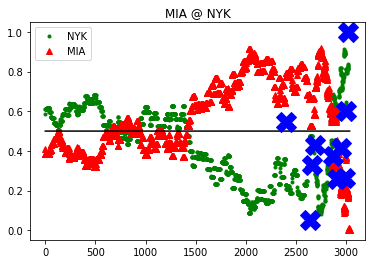

Game important plays: 
Top turning point descriptions: 
With 217.0 seconds left in quarter 4: Heat Timeout: Regular (Reg.4 Short 0)
With 25.0 seconds left in quarter 4: Prince 1' Floating Jump Shot (17 PTS) (Harris 6 AST)
With 536.0 seconds left in quarter 4: Johnson 27' 3PT Jump Shot (3 PTS) (Herro 4 AST)
With 54.0 seconds left in quarter 4: LeVert REBOUND (Off:2 Def:1)
With 99.0 seconds left in quarter 4: Jones Jr. REBOUND (Off:0 Def:4)
With 435.0 seconds left in quarter 4: Johnson 26' 3PT Jump Shot (6 PTS) (Dragic 5 AST)
With 574.0 seconds left in quarter 4: Jones Jr. 3' Cutting Layup Shot (6 PTS) (Herro 3 AST)
With 94.0 seconds left in quarter 3: Dragic 5' Finger Roll Layup (11 PTS)
With 153.0 seconds left in quarter 3: Heat Timeout: Regular (Reg.3 Short 0)
With 207.0 seconds left in quarter 3: Butler 11' Floating Jump Shot (25 PTS) (Dragic 4 AST)
Done


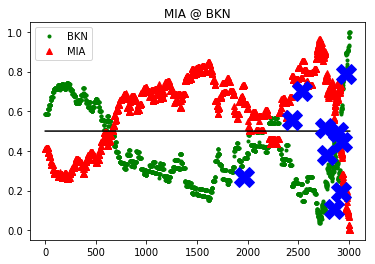

Game important plays: 
Top turning point descriptions: 
With 179.0 seconds left in quarter 2: Dragic 26' 3PT Pullup Jump Shot (6 PTS)
With 307.0 seconds left in quarter 1: Sabonis 1' Putback Layup (4 PTS)
With 364.0 seconds left in quarter 2: Herro 26' 3PT Step Back Jump Shot (9 PTS) (Robinson 3 AST)
With 432.0 seconds left in quarter 2: Jones Jr.  3PT Jump Shot (5 PTS) (Herro 1 AST)
With 555.0 seconds left in quarter 2: Herro 26' 3PT Jump Shot (6 PTS) (Dragic 2 AST)
With 690.0 seconds left in quarter 2: Herro 30' 3PT Pullup Jump Shot (3 PTS) (Leonard 1 AST)
With 687.0 seconds left in quarter 3: Nunn 24' 3PT Jump Shot (9 PTS) (Leonard 2 AST)
With 109.0 seconds left in quarter 2: Adebayo 3' Driving Layup (10 PTS)
With 399.0 seconds left in quarter 2: Dragic 2' Layup (3 PTS) (Adebayo 2 AST)
With 333.0 seconds left in quarter 1: Robinson  3PT Pullup Jump Shot (6 PTS)
Done


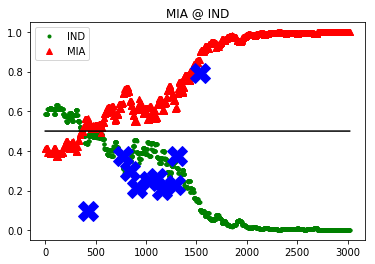

Game important plays: 
Top turning point descriptions: 
With 161.0 seconds left in quarter 3: Jones Jr. 26' 3PT Step Back Jump Shot (15 PTS)
With 128.0 seconds left in quarter 3: Dragic 27' 3PT Jump Shot (17 PTS) (Herro 1 AST)
With 694.0 seconds left in quarter 4: Dragic 26' 3PT Jump Shot (20 PTS) (Adebayo 6 AST)
With 109.0 seconds left in quarter 1: Dragic 26' 3PT Jump Shot (5 PTS) (Leonard 2 AST)
With 289.0 seconds left in quarter 1: Johnson  3PT Jump Shot (3 PTS) (Leonard 1 AST)
With 675.0 seconds left in quarter 2: Herro 26' 3PT Pullup Jump Shot (5 PTS)
With 683.0 seconds left in quarter 1: Robinson REBOUND (Off:0 Def:1)
With 662.0 seconds left in quarter 1: Leonard REBOUND (Off:0 Def:1)
With 463.0 seconds left in quarter 1: Leonard 27' 3PT Jump Shot (3 PTS) (Nunn 1 AST)
With 576.0 seconds left in quarter 1: Robinson REBOUND (Off:0 Def:2)
Done


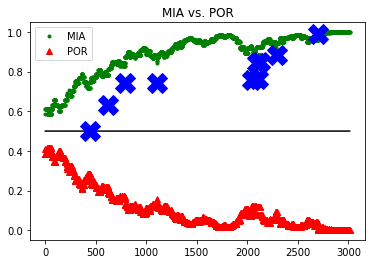

Game important plays: 
Top turning point descriptions: 
With 230.0 seconds left in quarter 3: Iwundu 24' 3PT Jump Shot (3 PTS) (Augustin 4 AST)
With 489.0 seconds left in quarter 2: Ross 26' 3PT Jump Shot (13 PTS) (Augustin 2 AST)
With 0.0 seconds left in quarter 3: Heat Rebound
With 87.0 seconds left in quarter 3: Ross 26' 3PT Pullup Jump Shot (25 PTS) (Augustin 5 AST)
With 82.0 seconds left in quarter 1: Bamba REBOUND (Off:1 Def:1)
With 692.0 seconds left in quarter 3: Butler 16' Turnaround Jump Shot (16 PTS)
With 126.0 seconds left in quarter 1: Ross 26' 3PT Pullup Jump Shot (6 PTS)
With 58.0 seconds left in quarter 1: Ross 26' 3PT Jump Shot (9 PTS) (Augustin 1 AST)
With 691.0 seconds left in quarter 2: Iwundu REBOUND (Off:2 Def:0)
With 304.0 seconds left in quarter 3: Vucevic 3' Driving Hook Shot (18 PTS) (Fultz 3 AST)
Done


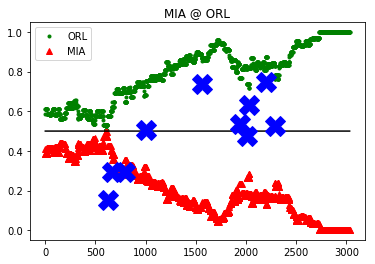

Game important plays: 
Top turning point descriptions: 
With 626.0 seconds left in quarter 4: Boucher 1' Putback Layup (2 PTS)
With 577.0 seconds left in quarter 4: Herro 26' 3PT Jump Shot (10 PTS) (Nunn 6 AST)
With 27.0 seconds left in quarter 3: Herro 24' 3PT Jump Shot (5 PTS) (Nunn 5 AST)
With 395.0 seconds left in quarter 3: Nunn 26' 3PT Jump Shot (7 PTS) (Butler 6 AST)
With 528.0 seconds left in quarter 4: Herro 26' 3PT Pullup Jump Shot (13 PTS) (Adebayo 2 AST)
With 273.0 seconds left in quarter 4: Jones Jr. 24' 3PT Jump Shot (6 PTS) (Nunn 8 AST)
With 216.0 seconds left in quarter 3: HEAT Timeout: Regular (Full 3 Short 0)
With 259.0 seconds left in quarter 3: Robinson  3PT Jump Shot (6 PTS) (Butler 7 AST)
With 0.0 seconds left in quarter 2: Instant Replay2nd Period (8:37 PM EST)
With 330.0 seconds left in quarter 2: Dragic 25' 3PT Jump Shot (8 PTS) (Butler 3 AST)
Done


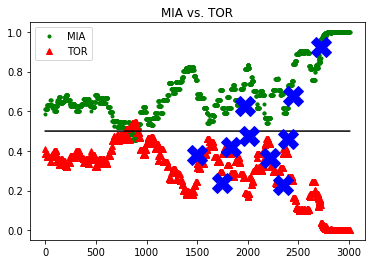

Game important plays: 
Top turning point descriptions: 
With 149.0 seconds left in quarter 2: Mathews 26' 3PT Jump Shot (20 PTS) (Thomas 4 AST)
With 315.0 seconds left in quarter 2: Mathews 26' 3PT Jump Shot (14 PTS) (McRae 5 AST)
With 259.0 seconds left in quarter 2: Mathews 26' 3PT Jump Shot (17 PTS) (Smith 5 AST)
With 5.0 seconds left in quarter 3: Smith 25' 3PT Pullup Jump Shot (9 PTS)
With 343.0 seconds left in quarter 2: McRae  3PT Jump Shot (20 PTS) (Brown Jr. 1 AST)
With 386.0 seconds left in quarter 2: Mathews Free Throw 1 of 3 (11 PTS)
With 403.0 seconds left in quarter 2: Adebayo REBOUND (Off:2 Def:2)
With 482.0 seconds left in quarter 3: Thomas 27' 3PT Jump Shot (3 PTS) (Payton II 1 AST)
With 68.0 seconds left in quarter 2: Silva 2' Layup (2 PTS)
With 59.0 seconds left in quarter 2: Smith 1' Driving Layup (4 PTS)
Done


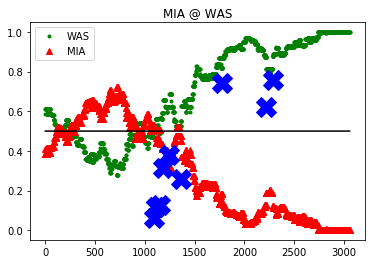

Game important plays: 
Top turning point descriptions: 
With 0.0 seconds left in quarter 4: HEAT Timeout: Regular (Full 6 Short 0)
With 18.0 seconds left in quarter 5: HEAT Timeout: Regular (Full 7 Short 0)
With 171.0 seconds left in quarter 4: Richardson 26' 3PT Jump Shot (17 PTS)
With 100.0 seconds left in quarter 4: Butler Free Throw 1 of 1 (22 PTS)
With 3.0 seconds left in quarter 4: Embiid Lost Ball Turnover (P3.T9)#@#Butler STEAL (2 STL)
With 0.0 seconds left in quarter 4: Simmons REBOUND (Off:3 Def:3)
With 74.0 seconds left in quarter 4: Embiid 26' 3PT Step Back Jump Shot (33 PTS)
With 6.0 seconds left in quarter 4: 76ers Timeout: Regular (Reg.7 Short 0)
With 299.0 seconds left in quarter 2: Korkmaz REBOUND (Off:0 Def:3)
With 42.0 seconds left in quarter 4: 76ers Timeout: Regular (Reg.6 Short 0)
Done


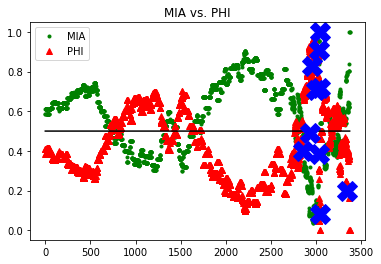

Game important plays: 
Top turning point descriptions: 
With 0.0 seconds left in quarter 4: Pacers Rebound
With 261.0 seconds left in quarter 4: Turner 25' 3PT Jump Shot (13 PTS) (Holiday 9 AST)
With 70.0 seconds left in quarter 4: Butler Offensive Foul Turnover (P4.T13)
With 199.0 seconds left in quarter 4: Lamb 17' Pullup Jump Shot (14 PTS)
With 54.0 seconds left in quarter 4: Adebayo REBOUND (Off:5 Def:9)
With 537.0 seconds left in quarter 3: Robinson 26' 3PT Jump Shot (12 PTS) (Butler 5 AST)
With 235.0 seconds left in quarter 3: Nunn 25' 3PT Jump Shot (17 PTS) (Dragic 4 AST)
With 504.0 seconds left in quarter 3: Nunn  3PT Step Back Jump Shot (14 PTS) (Robinson 2 AST)
With 629.0 seconds left in quarter 3: Robinson 27' 3PT Jump Shot (9 PTS) (Adebayo 4 AST)
With 19.0 seconds left in quarter 2: Robinson 27' 3PT Jump Shot (6 PTS) (Adebayo 3 AST)
Done


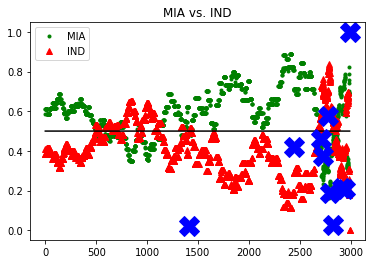

Game important plays: 
Top turning point descriptions: 
With 530.0 seconds left in quarter 4: Robinson 25' 3PT Jump Shot (3 PTS) (Adebayo 5 AST)
With 336.0 seconds left in quarter 3: Bogdanovic 1' Tip Layup Shot (12 PTS)
With 455.0 seconds left in quarter 4: Herro 27' 3PT Running Pull-Up Jump Shot (11 PTS)
With 473.0 seconds left in quarter 4: Adebayo REBOUND (Off:4 Def:7)
With 420.0 seconds left in quarter 2: Gobert 1' Putback Dunk (6 PTS)
With 591.0 seconds left in quarter 4: Gobert 3' Cutting Dunk Shot (12 PTS) (Mitchell 5 AST)
With 605.0 seconds left in quarter 4: Jazz Timeout: Regular (Reg.4 Short 0)
With 406.0 seconds left in quarter 4: Dragic  3PT Turnaround Jump Shot (13 PTS)
With 130.0 seconds left in quarter 3: Green 5' Running Layup (4 PTS) (Bogdanovic 1 AST)
With 474.0 seconds left in quarter 2: Herro 26' 3PT Jump Shot (3 PTS) (Olynyk 1 AST)
Done


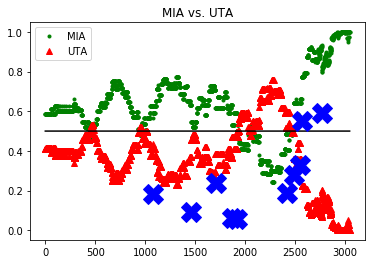

Game important plays: 
Top turning point descriptions: 
With 672.0 seconds left in quarter 1: Leonard REBOUND (Off:0 Def:1)
With 650.0 seconds left in quarter 1: Adebayo REBOUND (Off:0 Def:1)
With 523.0 seconds left in quarter 1: Leonard REBOUND (Off:0 Def:2)
With 538.0 seconds left in quarter 1: Robinson 25' 3PT Jump Shot (3 PTS) (Adebayo 1 AST)
With 472.0 seconds left in quarter 1: Robinson  3PT Jump Shot (6 PTS) (Butler 3 AST)
With 489.0 seconds left in quarter 1: Adebayo REBOUND (Off:0 Def:2)
With 577.0 seconds left in quarter 1: Nunn 26' 3PT Jump Shot (3 PTS) (Butler 2 AST)
With 261.0 seconds left in quarter 1: Butler 26' 3PT Jump Shot (5 PTS) (Nunn 2 AST)
With 422.0 seconds left in quarter 1: Ntilikina Out of Bounds - Bad Pass Turnover Turnover (P1.T1)
With 392.0 seconds left in quarter 1: Gibson Out of Bounds Lost Ball Turnover (P1.T2)
Done


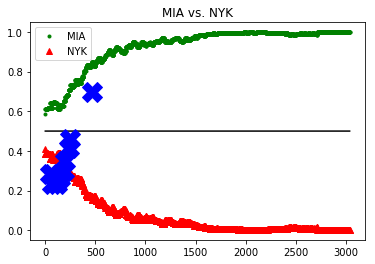

Game important plays: 
Top turning point descriptions: 
With 1.0 seconds left in quarter 4: Adebayo REBOUND (Off:3 Def:6)
With 37.0 seconds left in quarter 3: Nunn 27' 3PT Jump Shot (23 PTS) (Adebayo 2 AST)
With 228.0 seconds left in quarter 3: Heat Timeout: Regular (Reg.3 Short 0)
With 68.0 seconds left in quarter 4: Jones Jr. 28' 3PT Jump Shot (13 PTS) (Butler 5 AST)
With 581.0 seconds left in quarter 3: Leonard 26' 3PT Jump Shot (3 PTS) (Adebayo 1 AST)
With 365.0 seconds left in quarter 3: Leonard 26' 3PT Jump Shot (6 PTS) (Nunn 4 AST)
With 214.0 seconds left in quarter 2: 76ERS Timeout: Regular (Full 2 Short 0)
With 98.0 seconds left in quarter 2: Nunn 26' 3PT Running Pull-Up Jump Shot (13 PTS)
With 690.0 seconds left in quarter 3: Robinson 25' 3PT Jump Shot (7 PTS) (Butler 4 AST)
With 311.0 seconds left in quarter 3: Nunn 29' 3PT Jump Shot (20 PTS) (Leonard 2 AST)
Done


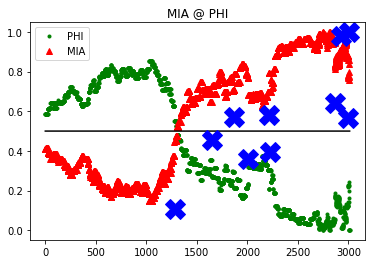

Game important plays: 
Top turning point descriptions: 
With 243.0 seconds left in quarter 4: Jackson Jr. 25' 3PT Jump Shot (15 PTS) (Melton 4 AST)
With 330.0 seconds left in quarter 4: Adebayo 1' Cutting Dunk Shot (14 PTS) (Butler 8 AST)
With 386.0 seconds left in quarter 4: GRIZZLIES Timeout: Regular (Full 5 Short 0)
With 261.0 seconds left in quarter 4: Melton REBOUND (Off:1 Def:2)
With 315.0 seconds left in quarter 4: Crowder REBOUND (Off:3 Def:0)
With 363.0 seconds left in quarter 1: Butler Free Throw 2 of 2 (2 PTS)
With 435.0 seconds left in quarter 4: GRIZZLIES Timeout: Regular (Full 4 Short 0)
With 183.0 seconds left in quarter 4: Clarke 2' Reverse Layup (14 PTS) (Crowder 2 AST)
With 314.0 seconds left in quarter 4: Crowder 1' Reverse Layup (8 PTS)
With 600.0 seconds left in quarter 4: MISS Nunn 9' Driving Floating Jump Shot#@#Jones BLOCK (1 BLK)
Done


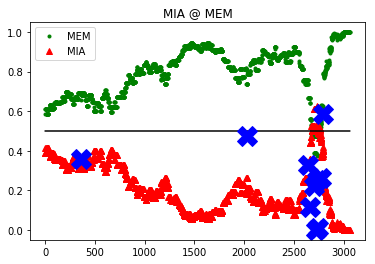

Game important plays: 
Top turning point descriptions: 
With 30.0 seconds left in quarter 4: Instant Replay4th Period (10:53 PM EST)
With 30.0 seconds left in quarter 4: MAVERICKS Timeout: Regular (Full 6 Short 0)
With 10.0 seconds left in quarter 5: Butler REBOUND (Off:1 Def:3)
With 42.0 seconds left in quarter 5: Butler REBOUND (Off:1 Def:2)
With 115.0 seconds left in quarter 5: Instant Replay1st OT (11:07 PM EST)
With 239.0 seconds left in quarter 4: Porzingis 26' 3PT Jump Shot (21 PTS) (Kleber 3 AST)
With 30.0 seconds left in quarter 4: Brunson L.B.FOUL (P4.PN) (S.Foster)
With 184.0 seconds left in quarter 5: Brunson 26' 3PT Pullup Jump Shot (18 PTS)
With 138.0 seconds left in quarter 5: Porzingis L.B.FOUL (P4.T2) (B.Nansel)
With 68.0 seconds left in quarter 4: Brunson 1' Driving Finger Roll Layup (15 PTS)
Done


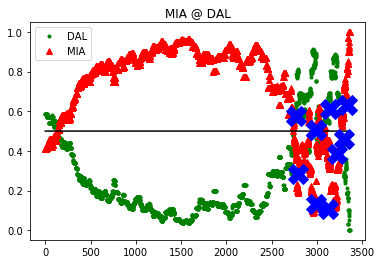

Game important plays: 
Top turning point descriptions: 
With 98.0 seconds left in quarter 4: Davis  3PT Jump Shot (32 PTS) (James 12 AST)
With 8.0 seconds left in quarter 4: Robinson Personal Take Foul (P3.PN) (G.Petraitis)
With 605.0 seconds left in quarter 4: Dudley 24' 3PT Jump Shot (3 PTS) (James 8 AST)
With 8.0 seconds left in quarter 4: Caldwell-Pope Free Throw 1 of 2 (14 PTS)
With 697.0 seconds left in quarter 4: James 26' 3PT Jump Shot (24 PTS) (Dudley 3 AST)
With 501.0 seconds left in quarter 3: HEAT Timeout: Regular (Full 3 Short 0)
With 410.0 seconds left in quarter 3: Davis 24' 3PT Jump Shot (23 PTS) (James 6 AST)
With 226.0 seconds left in quarter 4: James 1' Driving Layup (28 PTS)
With 286.0 seconds left in quarter 4: Caldwell-Pope  3PT Jump Shot (13 PTS) (James 10 AST)
With 4.0 seconds left in quarter 4: HEAT Timeout: Regular (Full 6 Short 0)
Done


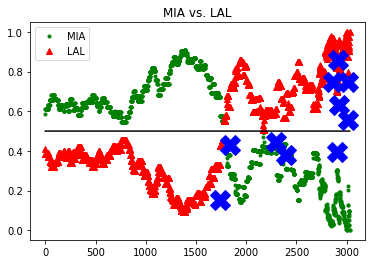

Game important plays: 
Top turning point descriptions: 
With 29.0 seconds left in quarter 4: Hawks Timeout: Regular (Reg.6 Short 0)
With 126.0 seconds left in quarter 4: Parker 2' Dunk (16 PTS) (Hunter 3 AST)
With 255.0 seconds left in quarter 4: Hunter 1' Driving Dunk (28 PTS) (Len 1 AST)
With 519.0 seconds left in quarter 4: Hunter 25' 3PT Jump Shot (22 PTS) (Crabbe 2 AST)
With 95.0 seconds left in quarter 4: Young 1' Driving Layup (21 PTS)
With 166.0 seconds left in quarter 4: Adebayo REBOUND (Off:2 Def:5)
With 646.0 seconds left in quarter 4: Crabbe  3PT Jump Shot (7 PTS) (Hunter 2 AST)
With 230.0 seconds left in quarter 5: Jones Jr. 2' Alley Oop Dunk (8 PTS) (Robinson 3 AST)
With 0.0 seconds left in quarter 4: HEAT Rebound
With 216.0 seconds left in quarter 5: Adebayo REBOUND (Off:3 Def:6)
Done


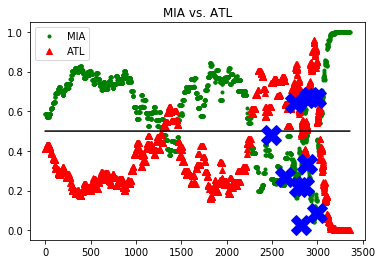

Game important plays: 
Top turning point descriptions: 
With 131.0 seconds left in quarter 4: Carter Jr. S.FOUL (P4.PN) (C.Washington)
With 7.0 seconds left in quarter 4: Herro 27' 3PT Jump Shot (16 PTS) (Butler 4 AST)
With 32.0 seconds left in quarter 4: LaVine REBOUND (Off:0 Def:5)
With 228.0 seconds left in quarter 5: Dunn REBOUND (Off:0 Def:5)
With 15.0 seconds left in quarter 4: HEAT Timeout: Regular (Full 6 Short 0)
With 252.0 seconds left in quarter 5: LaVine 2' Cutting Dunk Shot (18 PTS) (Dunn 2 AST)
With 15.0 seconds left in quarter 4: MISS LaVine 8' Driving Layup
With 84.0 seconds left in quarter 4: LaVine Free Throw 2 of 2 (14 PTS)
With 0.0 seconds left in quarter 4: HEAT Rebound
With 73.0 seconds left in quarter 4: Herro 2' Driving Layup (13 PTS) (Butler 3 AST)
Done


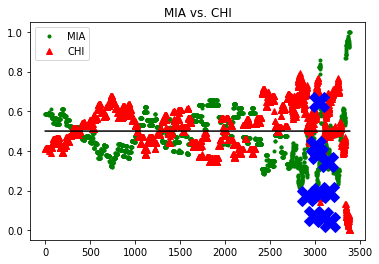

Game important plays: 
Top turning point descriptions: 
With 71.0 seconds left in quarter 2: Herro  3PT Fadeaway Jumper (13 PTS) (Butler 7 AST)
With 349.0 seconds left in quarter 2: Bertans 25' 3PT Jump Shot (12 PTS) (Beal 3 AST)
With 651.0 seconds left in quarter 2: Bertans 26' 3PT Pullup Jump Shot (6 PTS) (Chiozza 2 AST)
With 624.0 seconds left in quarter 2: Bertans 26' 3PT Pullup Jump Shot (9 PTS) (Brown Jr. 2 AST)
With 233.0 seconds left in quarter 2: Wagner 1' Layup (11 PTS) (Beal 4 AST)
With 105.0 seconds left in quarter 2: Wizards Timeout: Regular (Reg.3 Short 0)
With 303.0 seconds left in quarter 2: Wagner 1' Driving Layup (9 PTS)
With 38.0 seconds left in quarter 2: Butler Free Throw 1 of 2 (15 PTS)
With 668.0 seconds left in quarter 2: Olynyk S.FOUL (P2.T1) (L.Richardson)
With 384.0 seconds left in quarter 2: Smith 1' Driving Finger Roll Layup (8 PTS)
Done


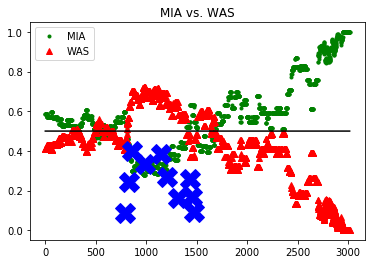

Game important plays: 
Top turning point descriptions: 
With 104.0 seconds left in quarter 2: Tatum 25' 3PT Step Back Jump Shot (13 PTS) (Walker 2 AST)
With 144.0 seconds left in quarter 3: Ojeleye  3PT Jump Shot (5 PTS) (Wanamaker 3 AST)
With 106.0 seconds left in quarter 3: Brown  3PT Jump Shot (21 PTS)
With 38.0 seconds left in quarter 2: Brown 24' 3PT Jump Shot (9 PTS) (Walker 3 AST)
With 172.0 seconds left in quarter 2: Leonard P.FOUL (P2.PN) (K.Lane)
With 631.0 seconds left in quarter 2: Herro 25' 3PT Step Back Jump Shot (3 PTS)
With 450.0 seconds left in quarter 3: Walker 27' 3PT Pullup Jump Shot (22 PTS)
With 318.0 seconds left in quarter 2: Olynyk 14' Turnaround Fadeaway (4 PTS)
With 74.0 seconds left in quarter 2: Walker 3' Driving Finger Roll Layup (17 PTS)
With 144.0 seconds left in quarter 2: Walker Free Throw 1 of 2 (14 PTS)
Done


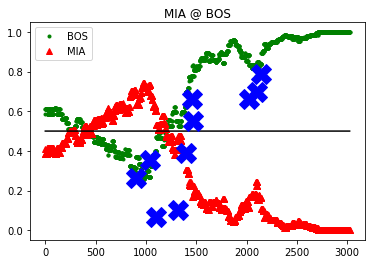

Game important plays: 
Top turning point descriptions: 
With 42.0 seconds left in quarter 4: Instant Replay4th Period (9:51 PM EST)
With 622.0 seconds left in quarter 2: Ibaka 1' Tip Layup Shot (2 PTS)
With 84.0 seconds left in quarter 5: Nunn Offensive Foul Turnover (P2.T13)
With 480.0 seconds left in quarter 2: Herro 27' 3PT Pullup Jump Shot (6 PTS)
With 75.0 seconds left in quarter 5: Adebayo REBOUND (Off:3 Def:3)
With 48.0 seconds left in quarter 2: Winslow 2' Turnaround Bank Hook Shot (6 PTS) (Butler 7 AST)
With 82.0 seconds left in quarter 4: Lowry Free Throw 2 of 2 (12 PTS)
With 224.0 seconds left in quarter 2: Olynyk 2' Reverse Layup (4 PTS) (Butler 4 AST)
With 301.0 seconds left in quarter 2: Adebayo 2' Reverse Layup (8 PTS)
With 619.0 seconds left in quarter 3: Siakam Free Throw 1 of 2 (11 PTS)
Done


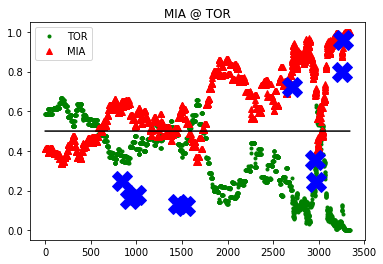

Game important plays: 
Top turning point descriptions: 
With 11.0 seconds left in quarter 4: Winslow Free Throw 1 of 2 (10 PTS)
With 11.0 seconds left in quarter 4: Winslow REBOUND (Off:2 Def:3)
With 400.0 seconds left in quarter 4: Harris 25' 3PT Step Back Jump Shot (19 PTS) (Prince 4 AST)
With 362.0 seconds left in quarter 4: Harris 25' 3PT Pullup Jump Shot (22 PTS) (Allen 2 AST)
With 594.0 seconds left in quarter 4: Temple REBOUND (Off:1 Def:4)
With 29.0 seconds left in quarter 4: Butler Free Throw 2 of 2 (20 PTS)
With 67.0 seconds left in quarter 4: Butler Free Throw 2 of 2 (17 PTS)
With 11.0 seconds left in quarter 4: Winslow Free Throw 2 of 2 (10 PTS)
With 96.0 seconds left in quarter 4: Dragic Free Throw 1 of 1 (24 PTS)
With 198.0 seconds left in quarter 4: Prince REBOUND (Off:2 Def:5)
Done


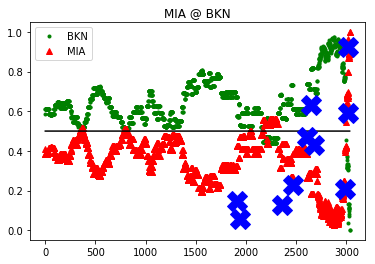

Game important plays: 
Top turning point descriptions: 
With 259.0 seconds left in quarter 3: Herro  3PT Jump Shot (13 PTS) (Butler 6 AST)
With 488.0 seconds left in quarter 3: Robinson 25' 3PT Jump Shot (17 PTS) (Adebayo 2 AST)
With 322.0 seconds left in quarter 2: Poole Free Throw 2 of 2 (11 PTS)
With 256.0 seconds left in quarter 2: Cauley-Stein 1' Tip Dunk Shot (2 PTS)
With 352.0 seconds left in quarter 2: Nunn  3PT Jump Shot (9 PTS) (Butler 5 AST)
With 161.0 seconds left in quarter 2: Cauley-Stein Bad Pass Turnover (P1.T2)#@#Olynyk STEAL (1 STL)
With 683.0 seconds left in quarter 1: Adebayo REBOUND (Off:0 Def:1)
With 614.0 seconds left in quarter 1: Leonard REBOUND (Off:0 Def:1)
With 431.0 seconds left in quarter 2: HEAT Timeout: Regular (Full 1 Short 0)
With 208.0 seconds left in quarter 1: Herro 24' 3PT Jump Shot (3 PTS) (Dragic 1 AST)
Done


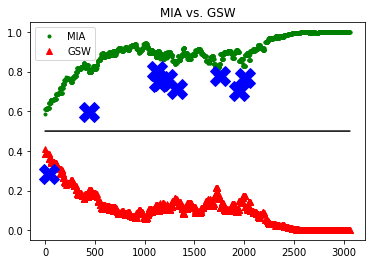

Game important plays: 
Top turning point descriptions: 
With 610.0 seconds left in quarter 2: Clark 25' 3PT Jump Shot (5 PTS) (Westbrook 4 AST)
With 348.0 seconds left in quarter 2: Harden 27' 3PT Jump Shot (16 PTS)
With 269.0 seconds left in quarter 1: Harden 28' 3PT Jump Shot (8 PTS) (Hartenstein 1 AST)
With 281.0 seconds left in quarter 1: ROCKETS Timeout: Regular (Full 1 Short 0)
With 659.0 seconds left in quarter 1: ROCKETS Rebound
With 626.0 seconds left in quarter 1: Westbrook REBOUND (Off:1 Def:1)
With 593.0 seconds left in quarter 1: Harden REBOUND (Off:0 Def:1)
With 573.0 seconds left in quarter 1: Adebayo Out of Bounds - Bad Pass Turnover Turnover (P1.T1)
With 543.0 seconds left in quarter 1: Westbrook REBOUND (Off:1 Def:2)
With 636.0 seconds left in quarter 2: Clark 1' Cutting Dunk Shot (2 PTS) (Westbrook 3 AST)
Done


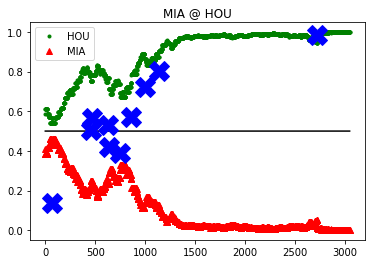

Game important plays: 
Top turning point descriptions: 
With 495.0 seconds left in quarter 2: Olynyk 26' 3PT Jump Shot (6 PTS) (Dragic 4 AST)
With 406.0 seconds left in quarter 2: Nunn 25' 3PT Jump Shot (9 PTS) (Butler 3 AST)
With 607.0 seconds left in quarter 2: Herro 27' 3PT Jump Shot (10 PTS) (Dragic 2 AST)
With 555.0 seconds left in quarter 2: Olynyk 25' 3PT Jump Shot (3 PTS) (Dragic 3 AST)
With 27.0 seconds left in quarter 1: Robinson 24' 3PT Jump Shot (6 PTS) (Olynyk 1 AST)
With 360.0 seconds left in quarter 2: Nunn 25' 3PT Pullup Jump Shot (12 PTS)
With 171.0 seconds left in quarter 1: Herro 26' 3PT Jump Shot (3 PTS) (Butler 2 AST)
With 263.0 seconds left in quarter 1: Robinson 24' 3PT Jump Shot (3 PTS) (Adebayo 3 AST)
With 703.0 seconds left in quarter 3: Nunn 24' 3PT Jump Shot (15 PTS) (Butler 5 AST)
With 402.0 seconds left in quarter 1: Nunn 25' 3PT Jump Shot (6 PTS) (Adebayo 2 AST)
Done


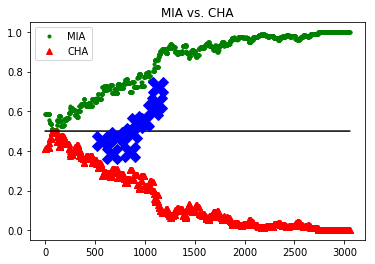

Game important plays: 
Top turning point descriptions: 
With 608.0 seconds left in quarter 1: Adebayo 1' Tip Layup Shot (2 PTS)
With 669.0 seconds left in quarter 1: Nunn Lost Ball Turnover (P1.T1)#@#Simmons STEAL (1 STL)
With 642.0 seconds left in quarter 1: Horford REBOUND (Off:0 Def:1)
With 582.0 seconds left in quarter 1: Simmons REBOUND (Off:0 Def:1)
With 559.0 seconds left in quarter 1: Simmons REBOUND (Off:0 Def:2)
With 526.0 seconds left in quarter 1: Harris REBOUND (Off:0 Def:1)
With 549.0 seconds left in quarter 1: Richardson 26' 3PT Jump Shot (3 PTS) (Horford 1 AST)
With 79.0 seconds left in quarter 1: Herro Out of Bounds Lost Ball Turnover (P1.T5)
With 297.0 seconds left in quarter 2: Horford 25' 3PT Jump Shot (9 PTS) (Simmons 5 AST)
With 432.0 seconds left in quarter 1: Simmons REBOUND (Off:0 Def:3)
Done


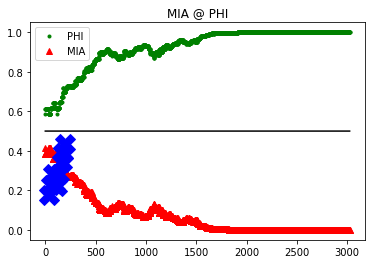

Game important plays: 
Top turning point descriptions: 
With 49.0 seconds left in quarter 1: Herro 26' 3PT Jump Shot (3 PTS) (Robinson 2 AST)
With 193.0 seconds left in quarter 1: Butler 25' 3PT Jump Shot (3 PTS) (Silva 1 AST)
With 293.0 seconds left in quarter 1: Nunn 24' 3PT Jump Shot (13 PTS) (Adebayo 3 AST)
With 157.0 seconds left in quarter 1: Dragic 25' 3PT Jump Shot (3 PTS) (Herro 1 AST)
With 400.0 seconds left in quarter 1: Leonard 25' 3PT Jump Shot (5 PTS) (Butler 3 AST)
With 705.0 seconds left in quarter 2: Dragic 25' 3PT Jump Shot (6 PTS) (Olynyk 1 AST)
With 588.0 seconds left in quarter 1: Adebayo REBOUND (Off:0 Def:1)
With 516.0 seconds left in quarter 1: Leonard REBOUND (Off:0 Def:2)
With 553.0 seconds left in quarter 1: Nunn REBOUND (Off:0 Def:2)
With 517.0 seconds left in quarter 1: MISS Markkanen 1' Tip Layup Shot
Done


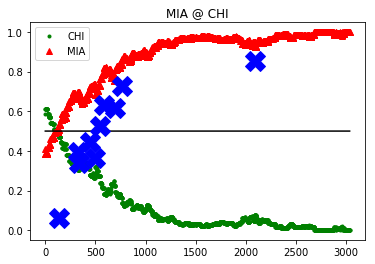

Game important plays: 
Top turning point descriptions: 
With 439.0 seconds left in quarter 1: Nance Jr. 1' Tip Dunk Shot (4 PTS)
With 688.0 seconds left in quarter 1: Nance Jr. 1' Tip Layup Shot (2 PTS)
With 327.0 seconds left in quarter 1: Robinson 26' 3PT Jump Shot (3 PTS) (Adebayo 1 AST)
With 490.0 seconds left in quarter 1: Sexton Free Throw 1 of 1 (3 PTS)
With 670.0 seconds left in quarter 2: Robinson 30' 3PT Jump Shot (6 PTS) (Herro 1 AST)
With 220.0 seconds left in quarter 1: Nunn 24' 3PT Step Back Jump Shot (7 PTS)
With 640.0 seconds left in quarter 1: HEAT Rebound
With 609.0 seconds left in quarter 1: Robinson REBOUND (Off:0 Def:1)
With 708.0 seconds left in quarter 1: Garland Bad Pass Turnover (P1.T1)#@#Butler STEAL (1 STL)
With 646.0 seconds left in quarter 2: Herro  3PT Jump Shot (5 PTS) (Dragic 1 AST)
Done


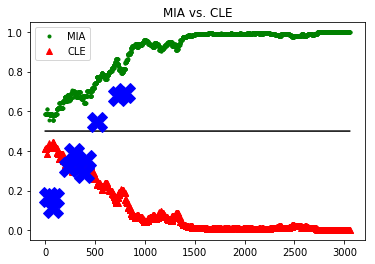

Game important plays: 
Top turning point descriptions: 
With 410.0 seconds left in quarter 3: Hayes 1' Tip Layup Shot (8 PTS)
With 241.0 seconds left in quarter 3: Butler 25' 3PT Jump Shot (10 PTS) (Silva 1 AST)
With 445.0 seconds left in quarter 3: Robinson  3PT Jump Shot (10 PTS) (Adebayo 2 AST)
With 178.0 seconds left in quarter 1: Hayes 1' Tip Dunk Shot (2 PTS)
With 460.0 seconds left in quarter 2: Olynyk 25' 3PT Jump Shot (3 PTS) (Robinson 1 AST)
With 366.0 seconds left in quarter 3: Leonard 2' Driving Layup (4 PTS)
With 519.0 seconds left in quarter 2: HEAT Timeout: Regular (Full 2 Short 0)
With 543.0 seconds left in quarter 3: Nunn  Driving Dunk (13 PTS)
With 580.0 seconds left in quarter 3: Robinson 1' Running Layup (7 PTS)
With 0.0 seconds left in quarter 2: Adebayo 12' Floating Jump Shot (14 PTS) (Butler 8 AST)
Done


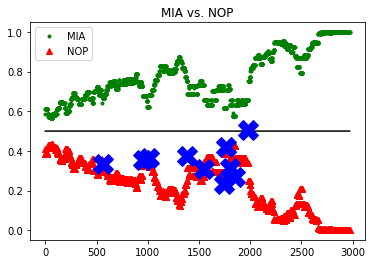

Game important plays: 
Top turning point descriptions: 
With 457.0 seconds left in quarter 2: Clarkson 1' Putback Layup (10 PTS)
With 0.0 seconds left in quarter 1: Dellavedova Free Throw 2 of 3 (3 PTS)
With 554.0 seconds left in quarter 2: Robinson 25' 3PT Jump Shot (6 PTS) (Adebayo 3 AST)
With 637.0 seconds left in quarter 2: Olynyk 27' 3PT Jump Shot (3 PTS) (Dragic 4 AST)
With 482.0 seconds left in quarter 2: Nunn 26' 3PT Jump Shot (12 PTS) (Adebayo 4 AST)
With 433.0 seconds left in quarter 2: Herro 26' 3PT Jump Shot (5 PTS) (Adebayo 5 AST)
With 422.0 seconds left in quarter 4: Heat Timeout: Regular (Reg.5 Short 0)
With 231.0 seconds left in quarter 1: Dragic 26' 3PT Jump Shot (3 PTS) (Nunn 3 AST)
With 388.0 seconds left in quarter 1: Sexton Free Throw 1 of 1 (5 PTS)
With 532.0 seconds left in quarter 2: Adebayo 2' Cutting Layup Shot (4 PTS) (Dragic 5 AST)
Done


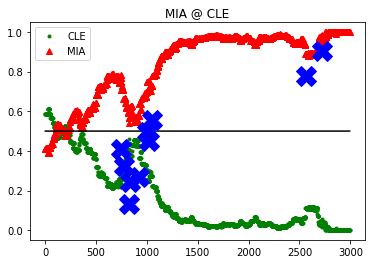

Game important plays: 
Top turning point descriptions: 
With 343.0 seconds left in quarter 4: Nunn 24' 3PT Jump Shot (18 PTS) (Butler 12 AST)
With 383.0 seconds left in quarter 4: SUB: Nunn FOR Robinson
With 697.0 seconds left in quarter 1: Adebayo REBOUND (Off:0 Def:1)
With 541.0 seconds left in quarter 2: Dragic 25' 3PT Jump Shot (8 PTS) (Olynyk 2 AST)
With 630.0 seconds left in quarter 2: Dragic 26' 3PT Jump Shot (5 PTS) (Nunn 3 AST)
With 663.0 seconds left in quarter 1: Adebayo REBOUND (Off:0 Def:2)
With 615.0 seconds left in quarter 1: Adebayo REBOUND (Off:0 Def:3)
With 579.0 seconds left in quarter 1: Butler REBOUND (Off:0 Def:1)
With 196.0 seconds left in quarter 1: Frazier Bad Pass Turnover (P1.T4)#@#Butler STEAL (2 STL)
With 531.0 seconds left in quarter 1: Robinson  3PT Jump Shot (5 PTS) (Butler 2 AST)
Done


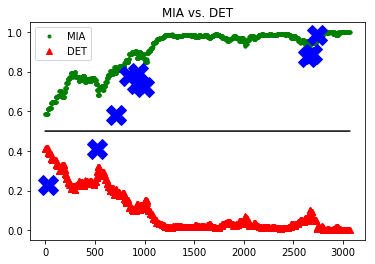

Game important plays: 
Top turning point descriptions: 
With 60.0 seconds left in quarter 2: Daniels 25' 3PT Jump Shot (3 PTS) (James 4 AST)
With 404.0 seconds left in quarter 2: Kuzma  3PT Jump Shot (5 PTS) (Caruso 4 AST)
With 305.0 seconds left in quarter 3: James  3PT Jump Shot (11 PTS) (Caldwell-Pope 3 AST)
With 130.0 seconds left in quarter 2: Davis 15' Turnaround Jump Shot (16 PTS) (James 3 AST)
With 360.0 seconds left in quarter 4: James 2' Driving Layup (19 PTS)
With 153.0 seconds left in quarter 2: Davis 1' Alley Oop Dunk (14 PTS) (Bradley 2 AST)
With 676.0 seconds left in quarter 3: James 2' Driving Dunk (7 PTS)
With 500.0 seconds left in quarter 4: James 1' Driving Layup (17 PTS) (Cook 2 AST)
With 225.0 seconds left in quarter 2: Howard 3' Alley Oop Layup (2 PTS) (Davis 2 AST)
With 415.0 seconds left in quarter 3: Davis 3' Cutting Layup Shot (22 PTS) (Bradley 3 AST)
Done


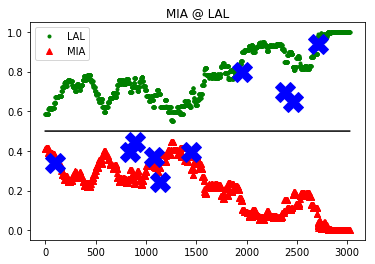

Game important plays: 
Top turning point descriptions: 
With 89.0 seconds left in quarter 3: Dragic 25' 3PT Pullup Jump Shot (10 PTS)
With 0.0 seconds left in quarter 3: Dragic 29' 3PT Step Back Jump Shot (15 PTS)
With 200.0 seconds left in quarter 2: Butler 26' 3PT Step Back Jump Shot (21 PTS) (Adebayo 3 AST)
With 673.0 seconds left in quarter 4: Dragic 27' 3PT Jump Shot (18 PTS) (Robinson 1 AST)
With 614.0 seconds left in quarter 4: Dragic 25' 3PT Pullup Jump Shot (21 PTS) (Olynyk 2 AST)
With 126.0 seconds left in quarter 3: Dragic 11' Driving Floating Jump Shot (7 PTS)
With 168.0 seconds left in quarter 3: Adebayo 1' Alley Oop Dunk (11 PTS) (Dragic 4 AST)
With 595.0 seconds left in quarter 3: Nunn 26' 3PT Jump Shot (11 PTS) (Butler 3 AST)
With 394.0 seconds left in quarter 1: Leonard 25' 3PT Jump Shot (6 PTS) (Adebayo 2 AST)
With 299.0 seconds left in quarter 2: Adebayo REBOUND (Off:1 Def:3)
Done


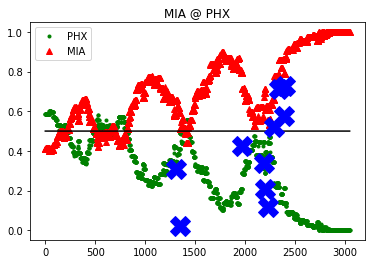

Game important plays: 
Top turning point descriptions: 
With 18.0 seconds left in quarter 1: Winslow 1' Tip Layup Shot (2 PTS)
With 153.0 seconds left in quarter 2: Murray 25' 3PT Pullup Jump Shot (11 PTS)
With 38.0 seconds left in quarter 1: NUGGETS Rebound
With 618.0 seconds left in quarter 3: Jokic 26' 3PT Jump Shot (5 PTS) (Murray 3 AST)
With 107.0 seconds left in quarter 1: Craig  3PT Jump Shot (3 PTS) (Beasley 1 AST)
With 51.0 seconds left in quarter 2: Barton 26' 3PT Jump Shot (12 PTS) (Plumlee 1 AST)
With 69.0 seconds left in quarter 1: Grant  3PT Jump Shot (5 PTS) (Morris 1 AST)
With 268.0 seconds left in quarter 2: Murray 5' Putback Layup (8 PTS)
With 204.0 seconds left in quarter 2: Plumlee 15' Jump Shot (6 PTS) (Barton 2 AST)
With 601.0 seconds left in quarter 1: Leonard Free Throw 1 of 1 (5 PTS)
Done


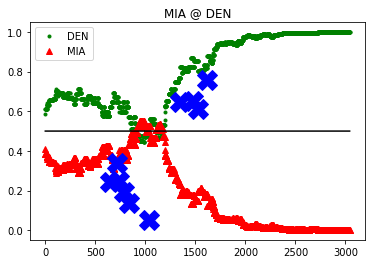

Game important plays: 
Top turning point descriptions: 
With 644.0 seconds left in quarter 1: Gordon Bad Pass Turnover (P1.T2)#@#Adebayo STEAL (1 STL)
With 671.0 seconds left in quarter 1: Robinson REBOUND (Off:0 Def:1)
With 699.0 seconds left in quarter 1: Westbrook Bad Pass Turnover (P1.T1)#@#Butler STEAL (1 STL)
With 612.0 seconds left in quarter 1: Leonard REBOUND (Off:0 Def:1)
With 583.0 seconds left in quarter 1: Harden Bad Pass Turnover (P1.T3)
With 555.0 seconds left in quarter 1: Harden Free Throw 2 of 2 (2 PTS)
With 540.0 seconds left in quarter 1: Butler 26' 3PT Pullup Jump Shot (8 PTS) (Nunn 2 AST)
With 530.0 seconds left in quarter 1: Nunn REBOUND (Off:0 Def:1)
With 432.0 seconds left in quarter 1: Butler REBOUND (Off:1 Def:1)
With 604.0 seconds left in quarter 1: Butler 26' 3PT Jump Shot (3 PTS) (Adebayo 1 AST)
Done


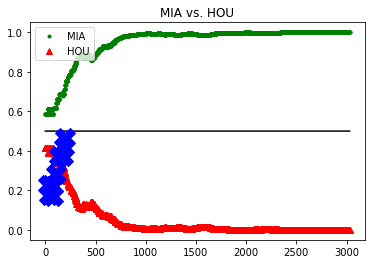

Game important plays: 
Top turning point descriptions: 
With 585.0 seconds left in quarter 4: Parker 1' Tip Dunk Shot (19 PTS)
With 566.0 seconds left in quarter 4: Herro 24' 3PT Jump Shot (13 PTS) (Olynyk 1 AST)
With 579.0 seconds left in quarter 3: Len 1' Putback Dunk (5 PTS)
With 620.0 seconds left in quarter 4: Dragic Free Throw 1 of 2 (4 PTS)
With 328.0 seconds left in quarter 4: Leonard 27' 3PT Pullup Jump Shot (13 PTS) (Butler 9 AST)
With 1.0 seconds left in quarter 3: Herro 25' 3PT Pullup Jump Shot (10 PTS) (Dragic 3 AST)
With 705.0 seconds left in quarter 3: Robinson  3PT Jump Shot (7 PTS) (Butler 5 AST)
With 504.0 seconds left in quarter 3: Hunter Free Throw 2 of 2 (2 PTS)
With 59.0 seconds left in quarter 1: Collins 1' Putback Dunk (7 PTS)
With 521.0 seconds left in quarter 3: Nunn  3PT Jump Shot (15 PTS) (Butler 7 AST)
Done


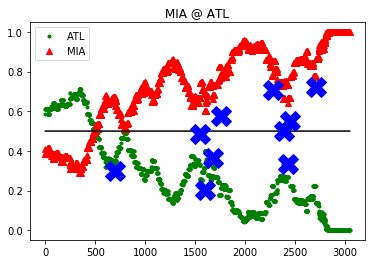

Game important plays: 
Top turning point descriptions: 
With 39.0 seconds left in quarter 2: Herro Free Throw 1 of 3 (19 PTS)
With 597.0 seconds left in quarter 2: Herro  3PT Jump Shot (3 PTS) (Dragic 2 AST)
With 181.0 seconds left in quarter 2: Nunn 24' 3PT Jump Shot (5 PTS) (Herro 1 AST)
With 59.0 seconds left in quarter 1: Dragic  3PT Step Back Jump Shot (6 PTS)
With 44.0 seconds left in quarter 1: Dragic 27' 3PT Step Back Jump Shot (9 PTS)
With 118.0 seconds left in quarter 1: Dragic 25' 3PT Jump Shot (3 PTS)
With 661.0 seconds left in quarter 3: Nunn  3PT Jump Shot (10 PTS) (Winslow 2 AST)
With 82.0 seconds left in quarter 2: Herro 24' 3PT Jump Shot (17 PTS) (Leonard 2 AST)
With 399.0 seconds left in quarter 2: Herro 17' Jump Shot (10 PTS) (Adebayo 1 AST)
With 269.0 seconds left in quarter 1: Butler  3PT Jump Shot (10 PTS) (Nunn 2 AST)
Done


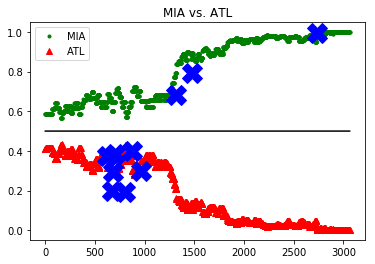

Game important plays: 
Top turning point descriptions: 
With 139.0 seconds left in quarter 4: Wiggins 27' 3PT Jump Shot (22 PTS) (Layman 2 AST)
With 243.0 seconds left in quarter 3: Instant Replay3rd Period (8:46 PM EST)
With 176.0 seconds left in quarter 4: Wiggins 27' 3PT Jump Shot (19 PTS) (Teague 8 AST)
With 195.0 seconds left in quarter 3: Nunn  3PT Jump Shot (25 PTS) (Dragic 3 AST)
With 262.0 seconds left in quarter 4: Wiggins Free Throw 2 of 2 (14 PTS)
With 155.0 seconds left in quarter 3: Dragic  3PT Jump Shot (9 PTS) (Winslow 5 AST)
With 223.0 seconds left in quarter 4: Winslow Free Throw 1 of 2 (16 PTS)
With 368.0 seconds left in quarter 4: Winslow 1' Driving Layup (15 PTS)
With 310.0 seconds left in quarter 4: Robinson  3PT Jump Shot (18 PTS) (Adebayo 5 AST)
With 547.0 seconds left in quarter 3: Adebayo REBOUND (Off:2 Def:4)
Done


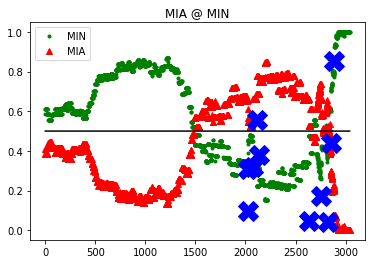

Game important plays: 
Top turning point descriptions: 
With 590.0 seconds left in quarter 2: G. Hill 27' 3PT Jump Shot (5 PTS) (Antetokounmpo 5 AST)
With 503.0 seconds left in quarter 2: Korver 24' 3PT Jump Shot (6 PTS) (Antetokounmpo 7 AST)
With 570.0 seconds left in quarter 2: Matthews  3PT Running Jump Shot (6 PTS) (Antetokounmpo 6 AST)
With 471.0 seconds left in quarter 2: Korver 26' 3PT Jump Shot (9 PTS) (G. Hill 3 AST)
With 392.0 seconds left in quarter 2: Matthews 26' 3PT Jump Shot (9 PTS) (Lopez 1 AST)
With 668.0 seconds left in quarter 2: Lopez 26' 3PT Jump Shot (3 PTS) (Antetokounmpo 4 AST)
With 438.0 seconds left in quarter 1: SUB: G. Hill FOR Bledsoe
With 295.0 seconds left in quarter 2: Lopez 27' 3PT Jump Shot (6 PTS) (Ilyasova 1 AST)
With 214.0 seconds left in quarter 2: Ilyasova 25' 3PT Jump Shot (5 PTS) (Bledsoe 1 AST)
With 424.0 seconds left in quarter 1: Middleton 26' 3PT Jump Shot (11 PTS) (G. Hill 1 AST)
Done


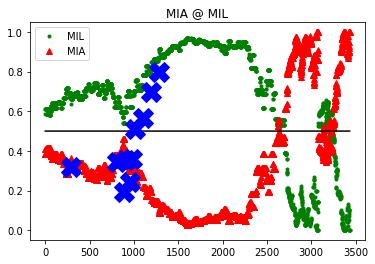

Game important plays: 
Top turning point descriptions: 
With 308.0 seconds left in quarter 3: Dragic 27' 3PT Jump Shot (9 PTS)
With 6.0 seconds left in quarter 2: SUB: Silva FOR Olynyk
With 611.0 seconds left in quarter 4: Winslow 9' Turnaround Fadeaway (21 PTS)
With 705.0 seconds left in quarter 4: Allen 5' Driving Floating Jump Shot (2 PTS) (Morant 4 AST)
With 125.0 seconds left in quarter 3: Jones 14' Pullup Jump Shot (13 PTS) (Allen 2 AST)
With 581.0 seconds left in quarter 4: Silva 2' Layup (2 PTS)
With 414.0 seconds left in quarter 2: Robinson 24' 3PT Jump Shot (3 PTS) (Winslow 4 AST)
With 532.0 seconds left in quarter 4: Silva 2' Alley Oop Dunk (4 PTS) (Dragic 3 AST)
With 330.0 seconds left in quarter 3: Nunn 4' Driving Finger Roll Layup (13 PTS)
With 330.0 seconds left in quarter 2: HEAT Timeout: Regular (Full 2 Short 0)
Done


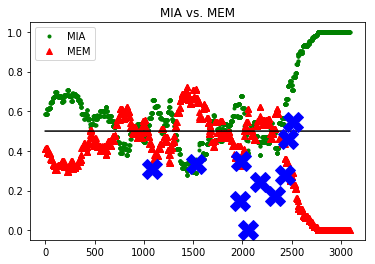

In [21]:
generate_win_probability_team('MIA', 'game')

Home team important plays: 
Top turning point descriptions: 
With 348.0 seconds left in quarter 3: Thompson S.FOUL (P3.T2) (K.Cutler)
With 4.0 seconds left in quarter 2: LAKERS Rebound
With 420.0 seconds left in quarter 3: SUB: Knight FOR Sexton
With 130.0 seconds left in quarter 2: James Free Throw 2 of 2 (8 PTS)
With 358.0 seconds left in quarter 2: Cavaliers Timeout: Regular (Reg.1 Short 0)
With 227.0 seconds left in quarter 2: SUB: McGee FOR Howard
With 329.0 seconds left in quarter 3: Cavaliers Timeout: Regular (Reg.2 Short 0)
With 0.0 seconds left in quarter 3: MISS Henson 79' 3PT Jump Shot
With 318.0 seconds left in quarter 1: Thompson Offensive Foul Turnover (P2.T3)
With 448.0 seconds left in quarter 1: SUB: Knight FOR Garland
Done
Visiting team important plays: 
Top turning point descriptions: 
With 534.0 seconds left in quarter 3: Thompson 1' Tip Layup Shot (15 PTS)
With 239.0 seconds left in quarter 2: SUB: Kuzma FOR Dudley
With 284.0 seconds left in quarter 1: SUB: Howard F

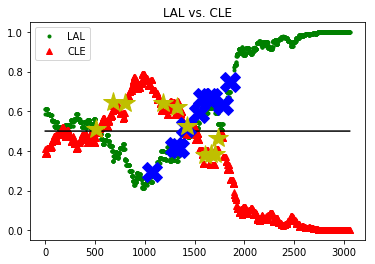

Home team important plays: 
Top turning point descriptions: 
With 658.0 seconds left in quarter 2: Adams 1' Tip Layup Shot (4 PTS)
With 367.0 seconds left in quarter 1: SUB: Schroder FOR Adams
With 604.0 seconds left in quarter 2: MISS Diallo Free Throw 2 of 2
With 0.0 seconds left in quarter 1: End of 1st Period (8:34 PM EST)
With 258.0 seconds left in quarter 2: Cook Offensive Foul Turnover (P1.T6)
With 286.0 seconds left in quarter 3: Lakers Timeout: Regular (Reg.4 Short 0)
With 418.0 seconds left in quarter 2: SUB: Bradley FOR Caruso
With 152.0 seconds left in quarter 3: SUB: Ferguson FOR Paul
With 555.0 seconds left in quarter 4: Howard S.FOUL (P1.T1) (T.Ford)
With 17.0 seconds left in quarter 2: SUB: Ferguson FOR Gallinari
Done
Visiting team important plays: 
Top turning point descriptions: 
With 260.0 seconds left in quarter 1: Out-of-Bounds
With 223.0 seconds left in quarter 1: SUB: Diallo FOR Gallinari
With 423.0 seconds left in quarter 1: Kuzma Free Throw 2 of 2 (4 PTS)
With 

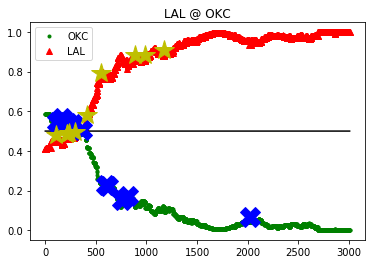

Home team important plays: 
Top turning point descriptions: 
With 143.0 seconds left in quarter 1: Marjanovic 1' Putback Layup (4 PTS)
With 238.0 seconds left in quarter 1: Howard Violation:Defensive Goaltending (B.Adair)
With 285.0 seconds left in quarter 2: Lakers Timeout: Regular (Reg.3 Short 0)
With 303.0 seconds left in quarter 2: Caldwell-Pope S.FOUL (P1.PN) (B.Forte)
With 77.0 seconds left in quarter 1: Doncic Free Throw 2 of 2 (4 PTS)
With 179.0 seconds left in quarter 2: MISS Doncic Free Throw 3 of 3
With 251.0 seconds left in quarter 1: SUB: Caruso FOR Bradley
With 519.0 seconds left in quarter 1: Hardaway Jr. Free Throw 2 of 2 (2 PTS)
With 432.0 seconds left in quarter 3: Lakers Timeout: Regular (Reg.4 Short 0)
With 631.0 seconds left in quarter 2: Marjanovic Free Throw 2 of 2 (10 PTS)
Done
Visiting team important plays: 
Top turning point descriptions: 
With 223.0 seconds left in quarter 1: Instant Replay1st Period (10:09 PM EST)
With 360.0 seconds left in quarter 1: Out-of

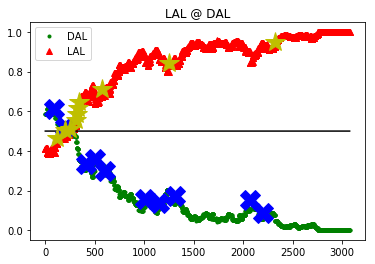

Home team important plays: 
Top turning point descriptions: 
With 540.0 seconds left in quarter 2: Gibson S.FOUL (P2.T2) (E.Lewis)
With 556.0 seconds left in quarter 1: James Lost Ball Turnover (P1.T1)#@#Bullock STEAL (1 STL)
With 422.0 seconds left in quarter 1: Randle P.FOUL (P1.T4) (M.Ayotte)
With 422.0 seconds left in quarter 1: Randle P.FOUL (P1.T4) (M.Ayotte)
With 393.0 seconds left in quarter 1: James Bad Pass Turnover (P2.T4)#@#Bullock STEAL (2 STL)
With 624.0 seconds left in quarter 2: SUB: Barrett FOR Dotson
With 118.0 seconds left in quarter 1: Ntilikina Violation:Kicked Ball (M.Ayotte)
With 369.0 seconds left in quarter 2: LAKERS Violation: Delay of game Violation
With 110.0 seconds left in quarter 1: Kuzma Free Throw 2 of 2 (2 PTS)
With 276.0 seconds left in quarter 1: SUB: Kuzma FOR McGee
Done
Visiting team important plays: 
Top turning point descriptions: 
With 224.0 seconds left in quarter 1: Out-of-Bounds
With 53.0 seconds left in quarter 1: Ntilikina Free Throw 2 of 2

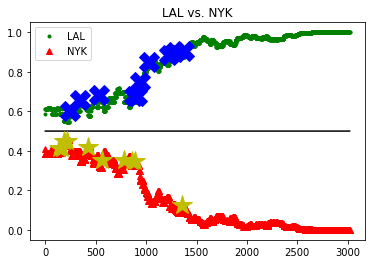

Home team important plays: 
Top turning point descriptions: 
With 281.0 seconds left in quarter 4: LAKERS Rebound
With 220.0 seconds left in quarter 4: Davis Free Throw 2 of 2 (15 PTS)
With 168.0 seconds left in quarter 4: Davis Free Throw 2 of 2 (17 PTS)
With 644.0 seconds left in quarter 4: Pistons Timeout: Regular (Reg.4 Short 0)
With 599.0 seconds left in quarter 4: Howard REBOUND (Off:4 Def:2)
With 666.0 seconds left in quarter 4: LAKERS Violation: Delay of game Violation
With 541.0 seconds left in quarter 4: Doumbouya S.FOUL (P3.T2) (J.Tiven)
With 102.0 seconds left in quarter 3: SUB: Maker FOR Drummond
With 513.0 seconds left in quarter 4: Pistons Timeout: Regular (Reg.5 Short 0)
With 327.0 seconds left in quarter 2: Brown S.FOUL (P1.T3) (J.Tiven)
Done
Visiting team important plays: 
Top turning point descriptions: 
With 59.0 seconds left in quarter 3: LAKERS Timeout: Regular (Full 4 Short 0)
With 380.0 seconds left in quarter 2: LAKERS Timeout: Regular (Full 2 Short 0)
With 177

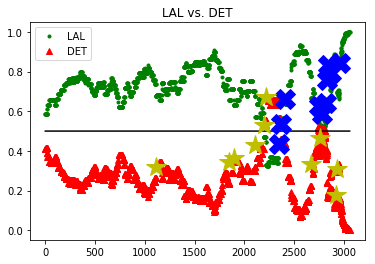

Home team important plays: 
Top turning point descriptions: 
With 96.0 seconds left in quarter 2: Ingram S.FOUL (P2.T2) (E.Malloy)
With 49.0 seconds left in quarter 2: SUB: Hart FOR Ingram
With 377.0 seconds left in quarter 1: Bradley Free Throw 1 of 2 (1 PTS)
With 264.0 seconds left in quarter 1: MISS Ingram 32' 3PT Jump Shot
With 252.0 seconds left in quarter 1: Caldwell-Pope Free Throw 1 of 2 (1 PTS)
With 96.0 seconds left in quarter 2: SUB: Hayes FOR Favors
With 482.0 seconds left in quarter 4: Williams S.FOUL (P2.T2) (B.Taylor)
With 531.0 seconds left in quarter 3: Pelicans Timeout: Regular (Reg.2 Short 0)
With 6.0 seconds left in quarter 2: Davis Free Throw 2 of 2 (21 PTS)
With 550.0 seconds left in quarter 1: MISS James Free Throw 2 of 2
Done
Visiting team important plays: 
Top turning point descriptions: 
With 133.0 seconds left in quarter 2: LAKERS Timeout: Regular (Full 4 Short 0)
With 259.0 seconds left in quarter 4: SUB: Redick FOR Hart
With 548.0 seconds left in quarter 1:

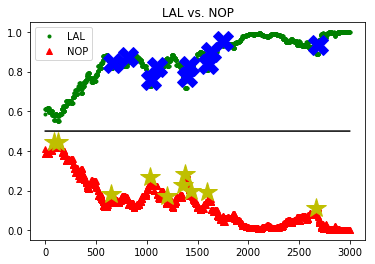

Home team important plays: 
Top turning point descriptions: 
With 299.0 seconds left in quarter 4: Bridges REBOUND (Off:0 Def:6)
With 249.0 seconds left in quarter 4: Bridges Personal Take Foul (P3.PN) (M.Dagher)
With 430.0 seconds left in quarter 1: SUB: Ayton FOR Saric
With 396.0 seconds left in quarter 1: LAKERS Timeout: Regular (Full 1 Short 0)
With 154.0 seconds left in quarter 4: MISS McGee Free Throw 2 of 2
With 343.0 seconds left in quarter 1: SUB: Diallo FOR Baynes
With 330.0 seconds left in quarter 1: SUB: Bridges FOR Oubre Jr.
With 299.0 seconds left in quarter 4: Ayton Offensive Foul Turnover (P2.T14)
With 430.0 seconds left in quarter 1: Saric S.FOUL (P2.T3) (T.Washington)
With 330.0 seconds left in quarter 1: Diallo S.FOUL (P1.PN) (T.Washington)
Done
Visiting team important plays: 
Top turning point descriptions: 
With 491.0 seconds left in quarter 4: Daniels S.FOUL (P1.T1) (T.Washington)
With 436.0 seconds left in quarter 1: Booker Free Throw 2 of 2 (8 PTS)
With 420.0 se

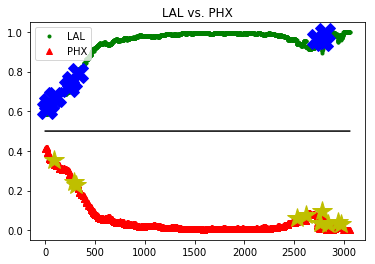

Home team important plays: 
Top turning point descriptions: 
With 65.0 seconds left in quarter 1: Doncic S.FOUL (P1.PN) (J.Van Duyne)
With 261.0 seconds left in quarter 1: SUB: Kuzma FOR McGee
With 603.0 seconds left in quarter 2: SUB: Finney-Smith FOR Kleber
With 11.0 seconds left in quarter 1: Kleber L.B.FOUL (P1.PN) (K.Scott)
With 603.0 seconds left in quarter 2: Kleber S.FOUL (P2.T1) (J.Van Duyne)
With 65.0 seconds left in quarter 1: SUB: Wright FOR Doncic
With 0.0 seconds left in quarter 1: End of 1st Period (10:09 PM EST)
With 542.0 seconds left in quarter 2: Marjanovic Offensive Foul Turnover (P1.T4)
With 468.0 seconds left in quarter 2: Out-of-Bounds
With 254.0 seconds left in quarter 2: Davis Free Throw 2 of 2 (12 PTS)
Done
Visiting team important plays: 
Top turning point descriptions: 
With 247.0 seconds left in quarter 1: Kuzma S.FOUL (P1.PN) (K.Scott)
With 146.0 seconds left in quarter 1: SUB: Powell FOR Porzingis
With 274.0 seconds left in quarter 2: SUB: Bradley FOR Cald

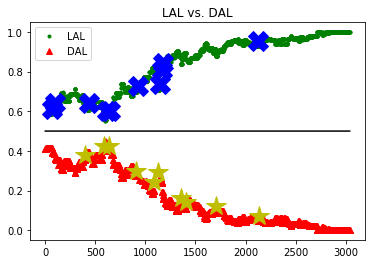

Home team important plays: 
Top turning point descriptions: 
With 358.0 seconds left in quarter 3: Lakers Timeout: Regular (Reg.4 Short 0)
With 452.0 seconds left in quarter 2: Whiteside 1' Tip Layup Shot (6 PTS)
With 3.0 seconds left in quarter 3: Caldwell-Pope S.FOUL (P3.PN) (P.Fraher)
With 392.0 seconds left in quarter 3: McGee S.FOUL (P4.PN) (J.Williams)
With 183.0 seconds left in quarter 3: MISS Little Free Throw 2 of 2
With 211.0 seconds left in quarter 3: SUB: Tolliver FOR Whiteside
With 178.0 seconds left in quarter 2: Lakers Timeout: Regular (Reg.3 Short 0)
With 57.0 seconds left in quarter 2: MISS Whiteside Free Throw 2 of 2
With 390.0 seconds left in quarter 2: SUB: Davis FOR Kuzma
With 599.0 seconds left in quarter 2: Lakers Timeout: Regular (Reg.2 Short 0)
Done
Visiting team important plays: 
Top turning point descriptions: 
With 0.0 seconds left in quarter 3: End of 3rd Period (12:00 AM EST)
With 234.0 seconds left in quarter 4: TRAIL BLAZERS Timeout: Regular (Full 5 Shor

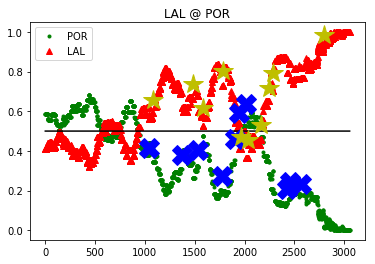

Home team important plays: 
Top turning point descriptions: 
With 41.0 seconds left in quarter 4: MISS James Free Throw 2 of 2
With 178.0 seconds left in quarter 4: Harrell REBOUND (Off:3 Def:2)
With 509.0 seconds left in quarter 4: Clippers Timeout: Regular (Reg.4 Short 0)
With 84.0 seconds left in quarter 4: Harrell REBOUND (Off:4 Def:2)
With 353.0 seconds left in quarter 3: James 1' Putback Dunk (10 PTS)
With 603.0 seconds left in quarter 4: Harrell S.FOUL (P2.T2) (S.Foster)
With 1.0 seconds left in quarter 2: Davis Free Throw 2 of 3 (14 PTS)
With 398.0 seconds left in quarter 4: Clippers Timeout: Regular (Reg.5 Short 0)
With 333.0 seconds left in quarter 3: Clippers Timeout: Regular (Reg.3 Short 0)
With 172.0 seconds left in quarter 2: Zubac S.FOUL (P2.T3) (M.Smith)
Done
Visiting team important plays: 
Top turning point descriptions: 
With 271.0 seconds left in quarter 4: Harrell 1' Tip Layup Shot (18 PTS)
With 314.0 seconds left in quarter 4: LAKERS Timeout: Regular (Full 5 Short 

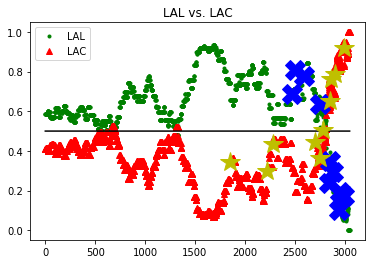

Home team important plays: 
Top turning point descriptions: 
With 219.0 seconds left in quarter 2: Howard 1' Putback Layup (6 PTS)
With 1.0 seconds left in quarter 1: Davis 1' Putback Dunk (11 PTS)
With 438.0 seconds left in quarter 3: Green Free Throw 3 of 3 (2 PTS)
With 203.0 seconds left in quarter 1: Davis 1' Tip Layup Shot (8 PTS)
With 210.0 seconds left in quarter 3: SUB: Plumlee FOR Jokic
With 324.0 seconds left in quarter 2: Nuggets Timeout: Regular (Reg.2 Short 0)
With 308.0 seconds left in quarter 1: Green REBOUND (Off:1 Def:1)
With 180.0 seconds left in quarter 2: Davis Free Throw 2 of 2 (13 PTS)
With 269.0 seconds left in quarter 3: SUB: Caruso FOR Bradley
With 0.0 seconds left in quarter 2: End of 2nd Period (10:37 PM EST)
Done
Visiting team important plays: 
Top turning point descriptions: 
With 34.0 seconds left in quarter 2: LAKERS Timeout: Regular (Full 3 Short 0)
With 508.0 seconds left in quarter 3: LAKERS Timeout: Regular (Full 4 Short 0)
With 337.0 seconds left in 

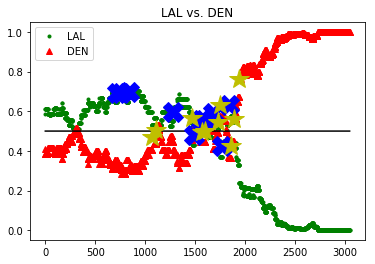

Home team important plays: 
Top turning point descriptions: 
With 299.0 seconds left in quarter 4: Matthews 28' 3PT Jump Shot (12 PTS) (Lopez 2 AST)
With 668.0 seconds left in quarter 2: Antetokounmpo 1' Tip Layup Shot (7 PTS)
With 444.0 seconds left in quarter 1: Antetokounmpo 1' Putback Dunk (5 PTS)
With 472.0 seconds left in quarter 1: Blood Rule
With 472.0 seconds left in quarter 1: Blood Rule
With 231.0 seconds left in quarter 4: BUCKS Timeout: Regular (Full 4 Short 0)
With 680.0 seconds left in quarter 1: Out-of-Bounds
With 114.0 seconds left in quarter 1: SUB: Antetokounmpo FOR Ilyasova
With 30.0 seconds left in quarter 1: SUB: Middleton FOR Ilyasova
With 428.0 seconds left in quarter 2: Lakers Timeout: Regular (Reg.3 Short 0)
Done
Visiting team important plays: 
Top turning point descriptions: 
With 231.0 seconds left in quarter 4: SUB: Caruso FOR Howard
With 123.0 seconds left in quarter 4: Davis 2' Running Dunk (36 PTS) (James 11 AST)
With 528.0 seconds left in quarter 1: Ant

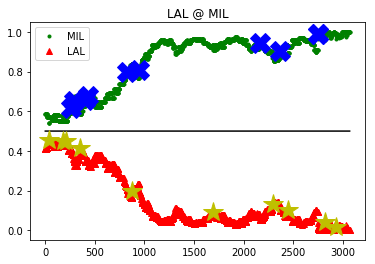

Home team important plays: 
Top turning point descriptions: 
With 36.0 seconds left in quarter 4: Lakers Timeout: Regular (Reg.7 Short 0)
With 119.0 seconds left in quarter 4: Howard L.B.FOUL (P4.PN) (J.Capers)
With 119.0 seconds left in quarter 4: Turner Free Throw 2 of 2 (16 PTS)
With 3.0 seconds left in quarter 3: Howard Bad Pass Turnover (P3.T12)#@#McConnell STEAL (3 STL)
With 11.0 seconds left in quarter 4: Out-of-Bounds
With 10.0 seconds left in quarter 4: SUB: Howard FOR Caruso
With 330.0 seconds left in quarter 4: SUB: James FOR Caldwell-Pope
With 0.0 seconds left in quarter 4: Lakers Rebound
With 338.0 seconds left in quarter 3: Sabonis 1' Putback Layup (21 PTS)
With 615.0 seconds left in quarter 4: SUB: Caruso FOR Daniels
Done
Visiting team important plays: 
Top turning point descriptions: 
With 239.0 seconds left in quarter 4: PACERS Timeout: Regular (Full 5 Short 0)
With 375.0 seconds left in quarter 4: PACERS Timeout: Regular (Full 4 Short 0)
With 438.0 seconds left in qua

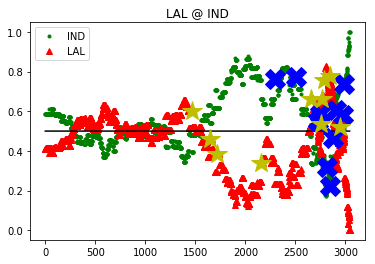

Home team important plays: 
Top turning point descriptions: 
With 601.0 seconds left in quarter 3: Lakers Timeout: Regular (Reg.2 Short 0)
With 260.0 seconds left in quarter 3: Young Free Throw 2 of 3 (23 PTS)
With 137.0 seconds left in quarter 4: Young Free Throw 2 of 2 (30 PTS)
With 66.0 seconds left in quarter 3: Lakers Timeout: Regular (Reg.4 Short 0)
With 19.0 seconds left in quarter 4: Hunter Free Throw 2 of 2 (8 PTS)
With 18.0 seconds left in quarter 3: Parker Free Throw 2 of 2 (12 PTS)
With 301.0 seconds left in quarter 3: Lakers Timeout: Regular (Reg.3 Short 0)
With 17.0 seconds left in quarter 2: Green Violation:Defensive Goaltending (T.Brown)
With 216.0 seconds left in quarter 1: Lakers Timeout: Regular (Reg.1 Short 0)
With 398.0 seconds left in quarter 4: SUB: Davis FOR Dudley
Done
Visiting team important plays: 
Top turning point descriptions: 
With 5.0 seconds left in quarter 4: Carter Personal Take Foul (P4.PN) (L.Wood)
With 501.0 seconds left in quarter 4: HAWKS Timeout

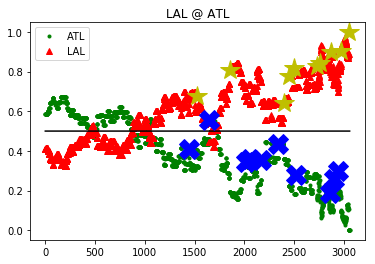

Home team important plays: 
Top turning point descriptions: 
With 8.0 seconds left in quarter 4: Robinson Personal Take Foul (P3.PN) (G.Petraitis)
With 346.0 seconds left in quarter 4: Davis Violation:Defensive Goaltending (K.Fitzgerald)
With 4.0 seconds left in quarter 4: HEAT Timeout: Regular (Full 6 Short 0)
With 227.0 seconds left in quarter 3: Lakers Timeout: Regular (Reg.4 Short 0)
With 103.0 seconds left in quarter 3: Jones Jr. Free Throw 2 of 2 (17 PTS)
With 586.0 seconds left in quarter 4: Olynyk Free Throw 2 of 2 (12 PTS)
With 129.0 seconds left in quarter 3: Butler Free Throw 2 of 2 (20 PTS)
With 419.0 seconds left in quarter 4: SUB: Davis FOR Dudley
With 597.0 seconds left in quarter 3: Butler Free Throw 2 of 2 (12 PTS)
With 343.0 seconds left in quarter 3: Jones Jr. Free Throw 2 of 2 (12 PTS)
Done
Visiting team important plays: 
Top turning point descriptions: 
With 8.0 seconds left in quarter 4: MISS Caldwell-Pope Free Throw 2 of 2
With 501.0 seconds left in quarter 3: HE

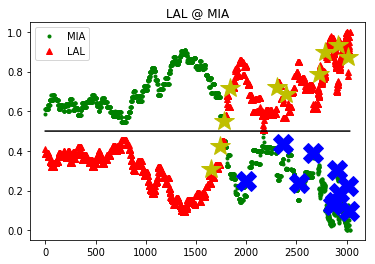

Home team important plays: 
Top turning point descriptions: 
With 150.0 seconds left in quarter 3: Gordon 1' Tip Dunk Shot (14 PTS)
With 461.0 seconds left in quarter 3: Isaac Free Throw 2 of 2 (5 PTS)
With 241.0 seconds left in quarter 4: James S.FOUL (P2.T3) (K.Mauer)
With 447.0 seconds left in quarter 3: Lakers Timeout: Regular (Reg.4 Short 0)
With 201.0 seconds left in quarter 4: Lakers Timeout: Regular (Reg.5 Short 0)
With 288.0 seconds left in quarter 3: SUB: Ross FOR Fournier
With 216.0 seconds left in quarter 2: Bamba 1' Tip Layup Shot (11 PTS)
With 351.0 seconds left in quarter 4: Bamba Free Throw 2 of 2 (13 PTS)
With 511.0 seconds left in quarter 3: Gordon Free Throw 2 of 2 (10 PTS)
With 582.0 seconds left in quarter 2: Gordon 1' Tip Layup Shot (3 PTS)
Done
Visiting team important plays: 
Top turning point descriptions: 
With 557.0 seconds left in quarter 4: MAGIC Timeout: Regular (Full 4 Short 0)
With 699.0 seconds left in quarter 4: Howard 1' Tip Layup Shot (2 PTS)
With 33.

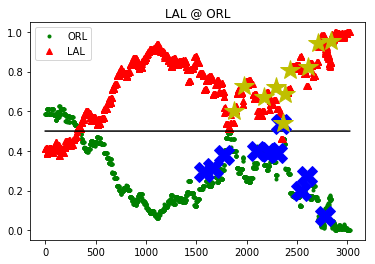

Home team important plays: 
Top turning point descriptions: 
With 224.0 seconds left in quarter 2: Timberwolves Timeout: Regular (Reg.2 Short 0)
With 383.0 seconds left in quarter 2: Howard 1' Tip Layup Shot (4 PTS)
With 115.0 seconds left in quarter 2: Caldwell-Pope Free Throw 2 of 2 (4 PTS)
With 160.0 seconds left in quarter 2: James Free Throw 2 of 2 (16 PTS)
With 424.0 seconds left in quarter 1: McGee 1' Tip Dunk Shot (4 PTS)
With 119.0 seconds left in quarter 2: Out-of-Bounds
With 418.0 seconds left in quarter 4: Timberwolves Timeout: Regular (Reg.5 Short 0)
With 164.0 seconds left in quarter 3: Davis 1' Tip Dunk Shot (38 PTS)
With 670.0 seconds left in quarter 1: Davis Free Throw 1 of 1 (3 PTS)
With 327.0 seconds left in quarter 1: SUB: Caruso FOR Green
Done
Visiting team important plays: 
Top turning point descriptions: 
With 345.0 seconds left in quarter 2: LAKERS Timeout: Regular (Full 3 Short 0)
With 520.0 seconds left in quarter 4: LAKERS Timeout: Regular (Full 5 Short 0)
Wi

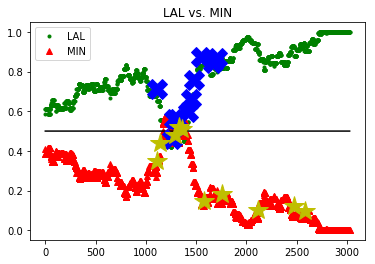

Home team important plays: 
Top turning point descriptions: 
With 103.0 seconds left in quarter 2: SUB: Rondo FOR Caruso
With 377.0 seconds left in quarter 1: Lakers Timeout: Regular (Reg.1 Short 0)
With 304.0 seconds left in quarter 2: Lakers Timeout: Regular (Reg.2 Short 0)
With 392.0 seconds left in quarter 1: Anthony Free Throw 1 of 1 (5 PTS)
With 207.0 seconds left in quarter 1: McGee P.FOUL (P2.T2) (J.Goble)
With 690.0 seconds left in quarter 2: Howard Offensive Foul Turnover (P1.T5)
With 30.0 seconds left in quarter 1: SUB: Caldwell-Pope FOR Daniels
With 619.0 seconds left in quarter 1: Out-of-Bounds
With 619.0 seconds left in quarter 1: Out-of-Bounds
With 116.0 seconds left in quarter 1: Blood Rule
Done
Visiting team important plays: 
Top turning point descriptions: 
With 177.0 seconds left in quarter 2: Tolliver S.FOUL (P1.T3) (J.Goble)
With 508.0 seconds left in quarter 2: TRAIL BLAZERS Timeout: Regular (Full 3 Short 0)
With 15.0 seconds left in quarter 2: Bazemore S.FOUL (P2

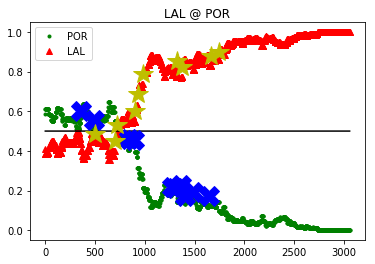

Home team important plays: 
Top turning point descriptions: 
With 411.0 seconds left in quarter 2: Davis 1' Tip Layup Shot (6 PTS)
With 17.0 seconds left in quarter 1: MISS Kuzma Free Throw 3 of 3
With 17.0 seconds left in quarter 1: MISS Kuzma Free Throw 3 of 3
With 67.0 seconds left in quarter 1: Out-of-Bounds
With 306.0 seconds left in quarter 1: McGee L.B.FOUL (P1.T1) (S.Foster)
With 108.0 seconds left in quarter 1: MISS Gobert 1' Tip Layup Shot
With 121.0 seconds left in quarter 1: Out-of-Bounds
With 211.0 seconds left in quarter 2: Caldwell-Pope S.FOUL (P1.T2) (S.Foster)
With 524.0 seconds left in quarter 2: SUB: O'Neale FOR Exum
With 232.0 seconds left in quarter 3: SUB: Davis FOR Ingles
Done
Visiting team important plays: 
Top turning point descriptions: 
With 0.0 seconds left in quarter 1: Instant Replay1st Period (9:38 PM EST)
With 17.0 seconds left in quarter 1: Gobert REBOUND (Off:1 Def:2)
With 200.0 seconds left in quarter 1: SUB: Ingles FOR Davis
With 108.0 seconds left i

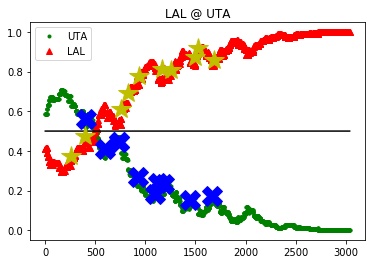

Home team important plays: 
Top turning point descriptions: 
With 251.0 seconds left in quarter 4: Lakers Timeout: Regular (Reg.5 Short 0)
With 290.0 seconds left in quarter 3: Equipment Malfunction
With 516.0 seconds left in quarter 3: Lakers Timeout: Regular (Reg.4 Short 0)
With 380.0 seconds left in quarter 3: Millsap 1' Tip Layup Shot (14 PTS)
With 143.0 seconds left in quarter 4: Jokic Free Throw 2 of 2 (13 PTS)
With 264.0 seconds left in quarter 4: James Offensive Foul Turnover (P4.T15)
With 286.0 seconds left in quarter 4: SUB: James FOR Howard
With 136.0 seconds left in quarter 2: Millsap 1' Tip Dunk Shot (9 PTS)
With 647.0 seconds left in quarter 4: Hernangomez 1' Tip Dunk Shot (4 PTS)
With 553.0 seconds left in quarter 3: Davis S.FOUL (P2.T2) (M.Smith)
Done
Visiting team important plays: 
Top turning point descriptions: 
With 105.0 seconds left in quarter 4: Barton L.B.FOUL (P4.PN) (M.Dagher)
With 105.0 seconds left in quarter 4: Caruso Free Throw 2 of 2 (6 PTS)
With 216.0 se

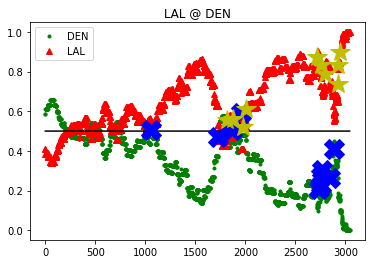

Home team important plays: 
Top turning point descriptions: 
With 0.0 seconds left in quarter 2: End of 2nd Period (5:06 PM EST)
With 175.0 seconds left in quarter 2: Porzingis S.FOUL (P3.PN) (D.Richardson)
With 204.0 seconds left in quarter 2: Porzingis S.FOUL (P2.PN) (M.Ayotte)
With 487.0 seconds left in quarter 3: Davis Free Throw 2 of 2 (22 PTS)
With 130.0 seconds left in quarter 3: Mavericks Timeout: Regular (Reg.3 Short 0)
With 296.0 seconds left in quarter 2: SUB: Hardaway Jr. FOR Curry
With 573.0 seconds left in quarter 2: Marjanovic S.FOUL (P1.T2) (D.Richardson)
With 175.0 seconds left in quarter 2: Howard REBOUND (Off:1 Def:1)
With 204.0 seconds left in quarter 2: Davis Free Throw 1 of 1 (15 PTS)
With 632.0 seconds left in quarter 1: Finney-Smith L.B.FOUL (P1.T1) (D.Richardson)
Done
Visiting team important plays: 
Top turning point descriptions: 
With 513.0 seconds left in quarter 3: McGee Violation:Defensive Goaltending (D.Richardson)
With 596.0 seconds left in quarter 2: LA

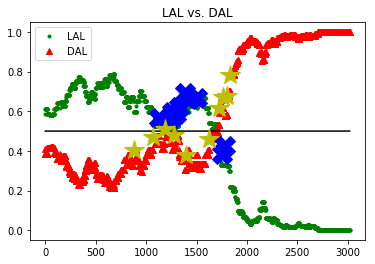

Home team important plays: 
Top turning point descriptions: 
With 204.0 seconds left in quarter 1: SUB: Caruso FOR James
With 191.0 seconds left in quarter 1: MISS Davis Free Throw 1 of 1
With 191.0 seconds left in quarter 1: MISS Davis Free Throw 1 of 1
With 381.0 seconds left in quarter 1: Davis Free Throw 2 of 2 (2 PTS)
With 164.0 seconds left in quarter 1: Wagner Offensive Foul Turnover (P2.T6)
With 172.0 seconds left in quarter 1: SUB: McRae FOR Beal
With 191.0 seconds left in quarter 1: Beal S.FOUL (P1.T4) (P.Ransom)
With 193.0 seconds left in quarter 2: Howard 1' Tip Layup Shot (2 PTS)
With 299.0 seconds left in quarter 1: Wizards Timeout: Regular (Reg.1 Short 0)
With 149.0 seconds left in quarter 1: SUB: Bonga FOR Hachimura
Done
Visiting team important plays: 
Top turning point descriptions: 
With 27.0 seconds left in quarter 1: SUB: Green FOR Caruso
With 47.0 seconds left in quarter 1: McRae Free Throw 2 of 2 (2 PTS)
With 599.0 seconds left in quarter 2: McRae Lost Ball Turnov

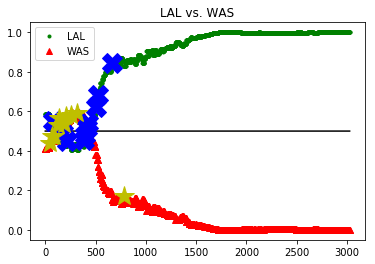

Home team important plays: 
Top turning point descriptions: 
With 32.0 seconds left in quarter 1: Holiday 1' Tip Layup Shot (12 PTS)
With 0.0 seconds left in quarter 1: Instant Replay1st Period (10:11 PM EST)
With 312.0 seconds left in quarter 2: Howard S.FOUL (P1.T2) (Z.Zarba)
With 471.0 seconds left in quarter 1: Out-of-Bounds
With 334.0 seconds left in quarter 3: Lakers Timeout: Regular (Reg.3 Short 0)
With 226.0 seconds left in quarter 2: Davis Offensive Foul Turnover (P1.T6)
With 306.0 seconds left in quarter 1: Kuzma Offensive Foul Turnover (P1.T4)
With 312.0 seconds left in quarter 2: SUB: Williams FOR Hart
With 452.0 seconds left in quarter 1: Ingram Free Throw 2 of 2 (5 PTS)
With 164.0 seconds left in quarter 2: Lakers Timeout: Regular (Reg.2 Short 0)
Done
Visiting team important plays: 
Top turning point descriptions: 
With 232.0 seconds left in quarter 2: SUB: James FOR Caruso
With 323.0 seconds left in quarter 2: Okafor S.FOUL (P4.T4) (D.Collins)
With 517.0 seconds left in 

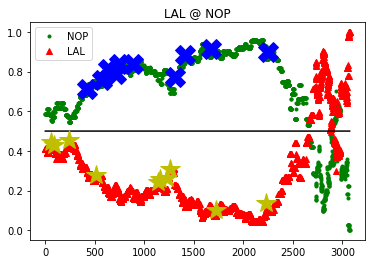

Home team important plays: 
Top turning point descriptions: 
With 162.0 seconds left in quarter 3: Howard S.FOUL (P3.T3) (E.Lewis)
With 280.0 seconds left in quarter 3: Lakers Timeout: Regular (Reg.4 Short 0)
With 1.0 seconds left in quarter 1: Aldridge 1' Putback Layup (12 PTS)
With 516.0 seconds left in quarter 3: Davis S.FOUL (P3.T1) (E.Lewis)
With 19.0 seconds left in quarter 3: SUB: Poeltl FOR Aldridge
With 56.0 seconds left in quarter 3: Aldridge Free Throw 2 of 2 (30 PTS)
With 364.0 seconds left in quarter 2: Lakers Timeout: Regular (Reg.2 Short 0)
With 235.0 seconds left in quarter 2: Lakers Timeout: Regular (Reg.3 Short 0)
With 455.0 seconds left in quarter 2: Howard L.B.FOUL (P1.T3) (R.Acosta)
With 592.0 seconds left in quarter 2: James Offensive Foul Turnover (P2.T3)
Done
Visiting team important plays: 
Top turning point descriptions: 
With 449.0 seconds left in quarter 3: SPURS Timeout: Regular (Full 4 Short 0)
With 315.0 seconds left in quarter 3: Green 1' Tip Layup Shot (

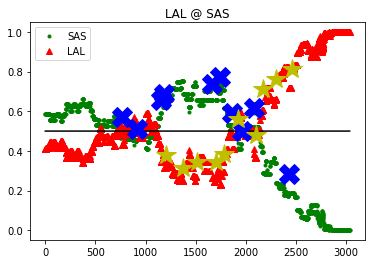

Home team important plays: 
Top turning point descriptions: 
With 1.0 seconds left in quarter 4: GRIZZLIES Timeout: Regular (Full 7 Short 0)
With 223.0 seconds left in quarter 4: Out-of-Bounds
With 492.0 seconds left in quarter 4: Lakers Timeout: Regular (Reg.6 Short 0)
With 315.0 seconds left in quarter 3: Jackson Jr. 1' Tip Layup Shot (18 PTS)
With 257.0 seconds left in quarter 4: Howard S.FOUL (P4.PN) (D.Guthrie)
With 141.0 seconds left in quarter 3: Lakers Timeout: Regular (Reg.5 Short 0)
With 148.0 seconds left in quarter 2: Lakers Timeout: Regular (Reg.3 Short 0)
With 32.0 seconds left in quarter 3: SUB: Morant FOR Jones
With 176.0 seconds left in quarter 1: Clarke 1' Tip Layup Shot (2 PTS)
With 257.0 seconds left in quarter 4: Morant Free Throw 1 of 1 (24 PTS)
Done
Visiting team important plays: 
Top turning point descriptions: 
With 0.0 seconds left in quarter 4: Instant Replay4th Period (10:34 PM EST)
With 232.0 seconds left in quarter 4: SUB: James FOR Howard
With 591.0 secon

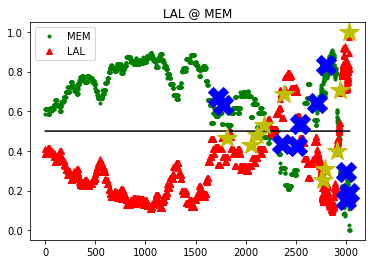

Home team important plays: 
Top turning point descriptions: 
With 384.0 seconds left in quarter 4: Lakers Timeout: Regular (Reg.5 Short 0)
With 329.0 seconds left in quarter 4: Delay Of Game
With 247.0 seconds left in quarter 4: SUB: Gilgeous-Alexander FOR Schroder
With 253.0 seconds left in quarter 2: SUB: McGee FOR Howard
With 70.0 seconds left in quarter 2: Paul Free Throw 2 of 2 (4 PTS)
With 697.0 seconds left in quarter 2: Howard L.B.FOUL (P1.T1) (J.DeRosa)
With 0.0 seconds left in quarter 1: MISS Davis 62' 3PT Pullup Jump Shot
With 266.0 seconds left in quarter 2: Out-of-Bounds
With 481.0 seconds left in quarter 2: Caruso Violation:Kicked Ball (J.DeRosa)
With 534.0 seconds left in quarter 2: Double Technical - Schroder, Rondo (E.Malloy)
Done
Visiting team important plays: 
Top turning point descriptions: 
With 156.0 seconds left in quarter 4: Adams S.FOUL (P3.PN) (E.Malloy)
With 625.0 seconds left in quarter 3: Ferguson L.B.FOUL (P3.T1) (M.Ervin)
With 0.0 seconds left in quarter 

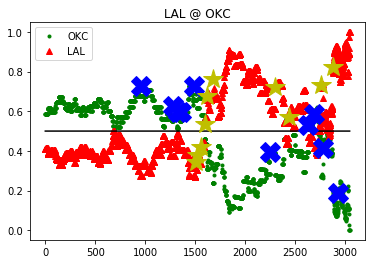

Home team important plays: 
Top turning point descriptions: 
With 55.0 seconds left in quarter 4: Thunder Timeout: Regular (Reg.6 Short 0)
With 0.0 seconds left in quarter 3: Instant Replay3rd Period (12:25 AM EST)
With 438.0 seconds left in quarter 3: Noel S.FOUL (P1.T2) (J.Orr)
With 418.0 seconds left in quarter 4: McGee 1' Tip Dunk Shot (8 PTS)
With 307.0 seconds left in quarter 2: Howard 1' Tip Dunk Shot (2 PTS)
With 145.0 seconds left in quarter 3: Ferguson S.FOUL (P3.PN) (T.Maddox)
With 13.0 seconds left in quarter 1: SUB: Bazley FOR Gallinari
With 465.0 seconds left in quarter 3: SUB: Noel FOR Adams
With 407.0 seconds left in quarter 3: Thunder Timeout: Regular (Reg.4 Short 0)
With 159.0 seconds left in quarter 2: MISS Rondo Free Throw 2 of 2
Done
Visiting team important plays: 
Top turning point descriptions: 
With 262.0 seconds left in quarter 4: Court Cleanup
With 102.0 seconds left in quarter 4: Out-of-Bounds
With 128.0 seconds left in quarter 4: Gilgeous-Alexander Free Thro

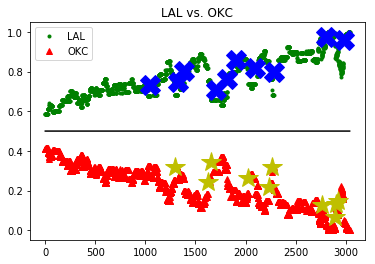

Home team important plays: 
Top turning point descriptions: 
With 601.0 seconds left in quarter 1: James 1' Running Alley Oop Dunk Shot (2 PTS) (Green 1 AST)
With 381.0 seconds left in quarter 3: Davis Free Throw 2 of 2 (10 PTS)
With 606.0 seconds left in quarter 3: Out-of-Bounds
With 364.0 seconds left in quarter 3: Delay Of Game
With 364.0 seconds left in quarter 3: McGee Violation:Defensive Goaltending (D.Guthrie)
With 352.0 seconds left in quarter 3: MISS Davis 27' 3PT Jump Shot
With 525.0 seconds left in quarter 1: Hawks Timeout: Regular (Reg.1 Short 0)
With 658.0 seconds left in quarter 2: Kuzma Free Throw 2 of 2 (2 PTS)
With 50.0 seconds left in quarter 3: Rondo 1' Tip Layup Shot (12 PTS)
With 265.0 seconds left in quarter 2: Hawks Timeout: Regular (Reg.3 Short 0)
Done
Visiting team important plays: 
Top turning point descriptions: 
With 108.0 seconds left in quarter 1: Daniels S.FOUL (P1.T4) (M.Smith)
With 506.0 seconds left in quarter 2: LAKERS Timeout: Regular (Full 2 Short 0

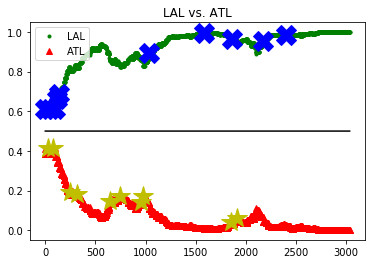

Home team important plays: 
Top turning point descriptions: 
With 5.0 seconds left in quarter 4: SUB: Green FOR Kuzma
With 0.0 seconds left in quarter 4: End of 4th Period (12:59 AM EST)
With 267.0 seconds left in quarter 4: Caldwell-Pope 4' Running Finger Roll Layup (11 PTS) (James 10 AST)
With 56.0 seconds left in quarter 4: Out-of-Bounds
With 166.0 seconds left in quarter 4: Kings Timeout: Regular (Reg.6 Short 0)
With 654.0 seconds left in quarter 3: Bjelica S.FOUL (P4.T2) (R.Mott)
With 125.0 seconds left in quarter 4: SUB: Kuzma FOR Howard
With 565.0 seconds left in quarter 3: Kings Timeout: Regular (Reg.3 Short 0)
With 215.0 seconds left in quarter 3: Dedmon S.FOUL (P1.PN) (R.Mott)
With 520.0 seconds left in quarter 4: Kings Timeout: Regular (Reg.4 Short 0)
Done
Visiting team important plays: 
Top turning point descriptions: 
With 204.0 seconds left in quarter 4: Holmes Free Throw 1 of 1 (17 PTS)
With 125.0 seconds left in quarter 4: Caruso S.FOUL (P3.PN) (R.Mott)
With 125.0 secon

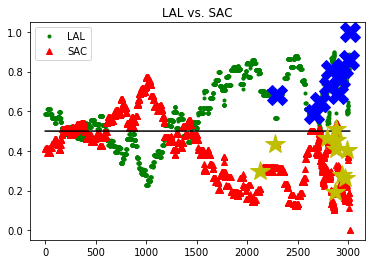

Home team important plays: 
Top turning point descriptions: 
With 182.0 seconds left in quarter 2: Kuzma 26' 3PT Jump Shot (9 PTS) (James 6 AST)
With 364.0 seconds left in quarter 1: James 1' Putback Layup (9 PTS)
With 611.0 seconds left in quarter 3: Warriors Timeout: Regular (Reg.3 Short 0)
With 250.0 seconds left in quarter 1: Warriors Timeout: Regular (Reg.1 Short 0)
With 623.0 seconds left in quarter 2: Howard 1' Putback Dunk (5 PTS)
With 436.0 seconds left in quarter 2: Howard 1' Tip Layup Shot (9 PTS)
With 642.0 seconds left in quarter 3: Bradley Free Throw 2 of 2 (4 PTS)
With 93.0 seconds left in quarter 1: SUB: Kuzma FOR Dudley
With 691.0 seconds left in quarter 2: Howard Free Throw 2 of 2 (3 PTS)
With 140.0 seconds left in quarter 2: Out-of-Bounds
Done
Visiting team important plays: 
Top turning point descriptions: 
With 266.0 seconds left in quarter 2: LAKERS Timeout: Regular (Full 2 Short 0)
With 645.0 seconds left in quarter 2: Spellman 1' Tip Layup Shot (2 PTS)
With 250.0

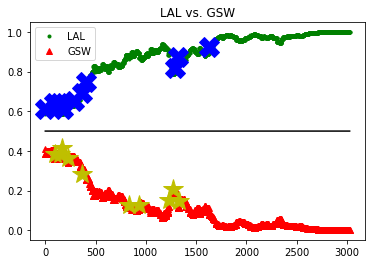

Home team important plays: 
Top turning point descriptions: 
With 247.0 seconds left in quarter 4: SUB: Caruso FOR Howard
With 334.0 seconds left in quarter 4: Bradley S.FOUL (P2.T3) (S.Foster)
With 247.0 seconds left in quarter 4: Howard L.B.FOUL (P5.PN) (S.Foster)
With 227.0 seconds left in quarter 4: Green P.FOUL (P5.PN) (J.Van Duyne)
With 133.0 seconds left in quarter 3: Davis S.FOUL (P1.T2) (S.Wall)
With 559.0 seconds left in quarter 3: McGee Violation:Defensive Goaltending (S.Foster)
With 209.0 seconds left in quarter 4: Lakers Timeout: Regular (Reg.6 Short 0)
With 232.0 seconds left in quarter 1: Lakers Timeout: Regular (Reg.1 Short 0)
With 227.0 seconds left in quarter 4: SUB: Kuzma FOR Green
With 407.0 seconds left in quarter 2: Booker Free Throw 2 of 2 (10 PTS)
Done
Visiting team important plays: 
Top turning point descriptions: 
With 233.0 seconds left in quarter 3: Davis Free Throw Flagrant 2 of 3 (17 PTS)
With 230.0 seconds left in quarter 4: MISS James Free Throw 1 of 1
W

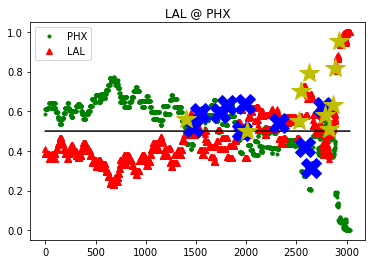

Home team important plays: 
Top turning point descriptions: 
With 415.0 seconds left in quarter 2: James 1' Tip Layup Shot (9 PTS)
With 259.0 seconds left in quarter 4: James 1' Putback Layup (11 PTS)
With 232.0 seconds left in quarter 1: Davis 1' Putback Layup (6 PTS)
With 340.0 seconds left in quarter 1: McGee 1' Tip Layup Shot (4 PTS)
With 139.0 seconds left in quarter 2: Anunoby S.FOUL (P3.T4) (J.Williams)
With 317.0 seconds left in quarter 2: SUB: Cook FOR Kuzma
With 18.0 seconds left in quarter 3: Davis P.FOUL (P1.T1) (L.Richardson)
With 625.0 seconds left in quarter 2: Hollis-Jefferson Offensive Foul Turnover (P1.T5)
With 317.0 seconds left in quarter 2: Howard REBOUND (Off:1 Def:1)
With 455.0 seconds left in quarter 4: SUB: VanVleet FOR Thomas
Done
Visiting team important plays: 
Top turning point descriptions: 
With 618.0 seconds left in quarter 4: Boucher 1' Tip Layup Shot (10 PTS)
With 665.0 seconds left in quarter 4: Davis 1' Tip Dunk Shot (8 PTS)
With 685.0 seconds left in

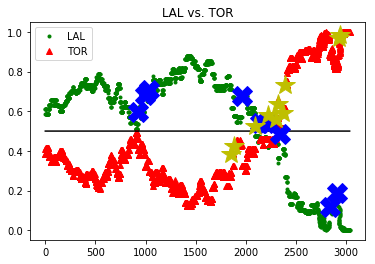

Home team important plays: 
Top turning point descriptions: 
With 305.0 seconds left in quarter 3: Heat Timeout: Regular (Reg.2 Short 0)
With 382.0 seconds left in quarter 3: MISS James Free Throw Flagrant 2 of 2
With 622.0 seconds left in quarter 1: McGee 1' Tip Layup Shot (2 PTS)
With 147.0 seconds left in quarter 1: SUB: Caruso FOR Green
With 0.0 seconds left in quarter 2: End of 2nd Period (11:37 PM EST)
With 431.0 seconds left in quarter 2: Out-of-Bounds
With 36.0 seconds left in quarter 1: Davis Free Throw 1 of 1 (12 PTS)
With 36.0 seconds left in quarter 1: Silva S.FOUL (P1.T1) (C.Kirkland)
With 556.0 seconds left in quarter 1: Heat Timeout: Regular (Reg.1 Short 0)
With 0.0 seconds left in quarter 1: End of 1st Period (11:08 PM EST)
Done
Visiting team important plays: 
Top turning point descriptions: 
With 430.0 seconds left in quarter 3: Bradley S.FOUL (P3.T3) (C.Kirkland)
With 32.0 seconds left in quarter 2: SUB: Cook FOR Bradley
With 289.0 seconds left in quarter 2: Butler Fr

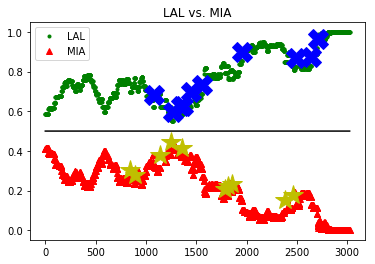

Home team important plays: 
Top turning point descriptions: 
With 341.0 seconds left in quarter 2: Lakers Timeout: Regular (Reg.3 Short 0)
With 1.0 seconds left in quarter 3: MISS Caruso 45' 3PT Running Jump Shot
With 397.0 seconds left in quarter 4: Satoransky Bad Pass Turnover (P1.T13)#@#Caruso STEAL (1 STL)
With 36.0 seconds left in quarter 1: Out-of-Bounds
With 556.0 seconds left in quarter 4: BULLS Rebound
With 144.0 seconds left in quarter 1: Lakers Timeout: Regular (Reg.1 Short 0)
With 662.0 seconds left in quarter 2: Lakers Timeout: Regular (Reg.2 Short 0)
With 448.0 seconds left in quarter 3: Lakers Timeout: Regular (Reg.4 Short 0)
With 548.0 seconds left in quarter 3: Green S.FOUL (P1.T1) (J.Goble)
With 606.0 seconds left in quarter 2: White Free Throw 2 of 3 (10 PTS)
Done
Visiting team important plays: 
Top turning point descriptions: 
With 533.0 seconds left in quarter 4: White S.FOUL (P1.T3) (S.Mehta)
With 368.0 seconds left in quarter 4: BULLS Timeout: Regular (Full 5 Sho

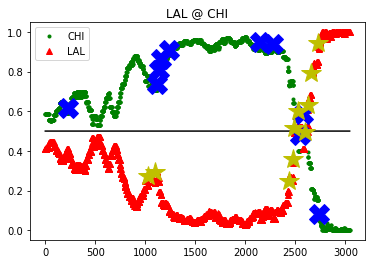

Home team important plays: 
Top turning point descriptions: 
With 0.0 seconds left in quarter 3: End of 3rd Period (8:50 PM EST)
With 272.0 seconds left in quarter 4: Murray Free Throw 1 of 1 (14 PTS)
With 213.0 seconds left in quarter 3: Lakers Timeout: Regular (Reg.4 Short 0)
With 152.0 seconds left in quarter 4: Murray Free Throw 2 of 2 (18 PTS)
With 600.0 seconds left in quarter 4: White Free Throw 2 of 2 (12 PTS)
With 146.0 seconds left in quarter 2: SUB: Caldwell-Pope FOR Green
With 395.0 seconds left in quarter 3: McGee S.FOUL (P4.T3) (M.Ayotte)
With 477.0 seconds left in quarter 2: MISS DeRozan Free Throw 2 of 2
With 428.0 seconds left in quarter 2: SPURS Timeout: Regular (Full 2 Short 0)
With 508.0 seconds left in quarter 2: DeRozan REBOUND (Off:2 Def:0)
Done
Visiting team important plays: 
Top turning point descriptions: 
With 408.0 seconds left in quarter 4: Howard 1' Putback Dunk (10 PTS)
With 328.0 seconds left in quarter 4: Poeltl S.FOUL (P1.T4) (J.Van Duyne)
With 428.0 s

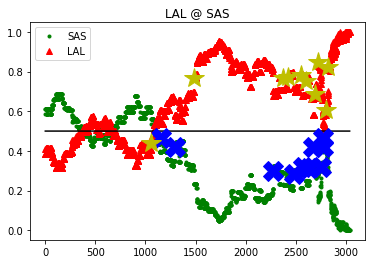

Home team important plays: 
Top turning point descriptions: 
With 30.0 seconds left in quarter 4: Lakers Timeout: Regular (Reg.6 Short 0)
With 40.0 seconds left in quarter 4: MAVERICKS Timeout: Regular (Full 7 Short 0)
With 119.0 seconds left in quarter 3: Lakers Timeout: Regular (Reg.5 Short 0)
With 498.0 seconds left in quarter 3: McGee S.FOUL (P3.T1) (L.Wood)
With 188.0 seconds left in quarter 5: James Offensive Foul Turnover (P4.T11)
With 6.0 seconds left in quarter 4: Lakers Timeout: Regular (Reg.7 Short 0)
With 498.0 seconds left in quarter 3: MISS Porzingis Free Throw 1 of 1
With 30.0 seconds left in quarter 4: SUB: Caruso FOR Howard
With 0.0 seconds left in quarter 4: Green  3PT Jump Shot (13 PTS) (James 14 AST)
With 12.0 seconds left in quarter 4: Doncic REBOUND (Off:1 Def:12)
Done
Visiting team important plays: 
Top turning point descriptions: 
With 0.0 seconds left in quarter 4: Instant Replay4th Period (12:06 AM EST)
With 308.0 seconds left in quarter 4: MAVERICKS Timeout: 

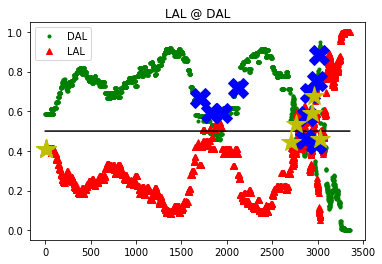

Home team important plays: 
Top turning point descriptions: 
With 322.0 seconds left in quarter 3: Davis Free Throw 2 of 2 (26 PTS)
With 671.0 seconds left in quarter 2: Howard 1' Putback Dunk (2 PTS)
With 0.0 seconds left in quarter 2: Instant Replay2nd Period (11:40 PM EST)
With 388.0 seconds left in quarter 3: James Free Throw 2 of 2 (11 PTS)
With 232.0 seconds left in quarter 3: Grizzlies Timeout: Regular (Reg.4 Short 0)
With 463.0 seconds left in quarter 3: Davis Free Throw 2 of 2 (24 PTS)
With 521.0 seconds left in quarter 3: MISS James Free Throw 2 of 2
With 545.0 seconds left in quarter 3: Davis Free Throw 2 of 2 (22 PTS)
With 267.0 seconds left in quarter 3: SUB: Anderson FOR Valanciunas
With 518.0 seconds left in quarter 2: Grizzlies Timeout: Regular (Reg.2 Short 0)
Done
Visiting team important plays: 
Top turning point descriptions: 
With 347.0 seconds left in quarter 3: Valanciunas Free Throw Flagrant 2 of 2 (14 PTS)
With 582.0 seconds left in quarter 3: Valanciunas 1' Putb

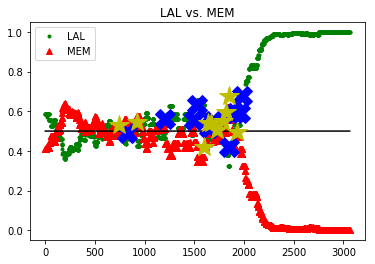

Home team important plays: 
Top turning point descriptions: 
With 470.0 seconds left in quarter 3: Hornets Timeout: Regular (Reg.4 Short 0)
With 566.0 seconds left in quarter 3: Bacon S.FOUL (P3.T1) (C.Blair)
With 28.0 seconds left in quarter 3: Washington S.FOUL (P4.PN) (J.Tiven)
With 5.0 seconds left in quarter 2: SUB: Caldwell-Pope FOR Daniels
With 100.0 seconds left in quarter 2: James Free Throw 2 of 2 (2 PTS)
With 130.0 seconds left in quarter 2: Davis Free Throw 2 of 2 (21 PTS)
With 512.0 seconds left in quarter 1: McGee 1' Tip Dunk Shot (6 PTS)
With 233.0 seconds left in quarter 1: SUB: Howard FOR McGee
With 647.0 seconds left in quarter 2: Washington S.FOUL (P1.T1) (C.Blair)
With 615.0 seconds left in quarter 1: Bacon Offensive Foul Turnover (P1.T2)
Done
Visiting team important plays: 
Top turning point descriptions: 
With 1.0 seconds left in quarter 1: Graham Free Throw 2 of 3 (3 PTS)
With 273.0 seconds left in quarter 2: Zeller 1' Tip Layup Shot (13 PTS)
With 295.0 seconds l

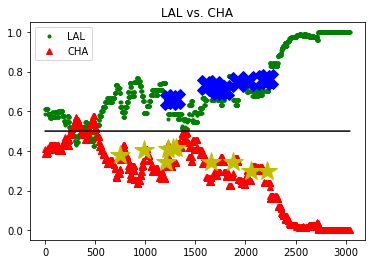

Home team important plays: 
Top turning point descriptions: 
With 464.0 seconds left in quarter 3: Jazz Timeout: Regular (Reg.3 Short 0)
With 29.0 seconds left in quarter 2: Ingles S.FOUL (P3.T3) (K.Cutler)
With 541.0 seconds left in quarter 3: James Free Throw 2 of 2 (13 PTS)
With 306.0 seconds left in quarter 3: O'Neale S.FOUL (P2.T4) (K.Cutler)
With 440.0 seconds left in quarter 2: Bradley Free Throw Flagrant 2 of 2 (7 PTS)
With 225.0 seconds left in quarter 1: Green Offensive Foul Turnover (P1.T4)
With 505.0 seconds left in quarter 1: Gobert L.B.FOUL (P1.T1) (K.Cutler)
With 299.0 seconds left in quarter 4: Jazz T.Foul (Def. 3 Sec Bradley ) (D.Guthrie)
With 29.0 seconds left in quarter 2: Davis 2' Running Layup (16 PTS) (James 5 AST)
With 29.0 seconds left in quarter 2: SUB: O'Neale FOR Ingles
Done
Visiting team important plays: 
Top turning point descriptions: 
With 67.0 seconds left in quarter 2: LAKERS Timeout: Regular (Full 2 Short 0)
With 0.0 seconds left in quarter 2: Green Vi

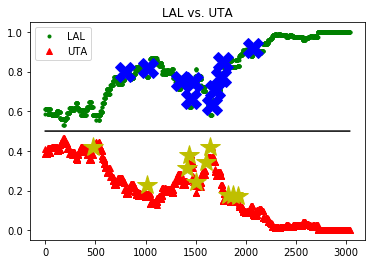

Home team important plays: 
Top turning point descriptions: 
With 584.0 seconds left in quarter 4: Lakers Timeout: Regular (Reg.4 Short 0)
With 367.0 seconds left in quarter 2: Lakers Timeout: Regular (Reg.2 Short 0)
With 299.0 seconds left in quarter 4: Leonard Out of Bounds - Bad Pass Turnover Turnover (P5.T11)
With 648.0 seconds left in quarter 4: SUB: Daniels FOR Cook
With 596.0 seconds left in quarter 3: Lakers Timeout: Regular (Reg.3 Short 0)
With 624.0 seconds left in quarter 1: Zubac 1' Tip Layup Shot (2 PTS)
With 86.0 seconds left in quarter 2: SUB: Beverley FOR Leonard
With 645.0 seconds left in quarter 1: Out-of-Bounds
With 0.0 seconds left in quarter 3: End of 3rd Period (12:33 AM EST)
With 193.0 seconds left in quarter 4: MISS Harrell Free Throw 2 of 2
Done
Visiting team important plays: 
Top turning point descriptions: 
With 498.0 seconds left in quarter 4: CLIPPERS Timeout: Regular (Full 4 Short 0)
With 474.0 seconds left in quarter 3: Beverley S.FOUL (P4.T2) (M.Lindsay)

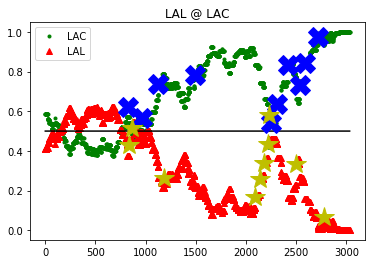

In [12]:
generate_win_probability_team('LAL', 'no_game')

Game important plays: 
Top turning point descriptions: 
With 595.0 seconds left in quarter 3: Lillard 1' Tip Layup Shot (24 PTS)
With 299.0 seconds left in quarter 2: DiVincenzo 28' 3PT Jump Shot (10 PTS) (Antetokounmpo 4 AST)
With 188.0 seconds left in quarter 2: Bledsoe 26' 3PT Pullup Jump Shot (9 PTS) (Antetokounmpo 5 AST)
With 414.0 seconds left in quarter 3: Bledsoe 25' 3PT Step Back Jump Shot (18 PTS)
With 517.0 seconds left in quarter 2: Matthews 25' 3PT Jump Shot (3 PTS) (Antetokounmpo 3 AST)
With 643.0 seconds left in quarter 3: Bledsoe REBOUND (Off:1 Def:3)
With 695.0 seconds left in quarter 2: DiVincenzo REBOUND (Off:1 Def:2)
With 504.0 seconds left in quarter 3: Antetokounmpo 2' Alley Oop Layup (23 PTS) (Bledsoe 3 AST)
With 501.0 seconds left in quarter 2: Tolliver S.FOUL (P2.T2) (P.Fraher)
With 451.0 seconds left in quarter 3: Bledsoe 1' Driving Layup (15 PTS) (Middleton 1 AST)
Done


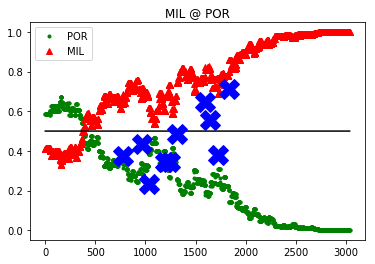

Game important plays: 
Top turning point descriptions: 
With 625.0 seconds left in quarter 3: Hield 2' Tip Layup Shot (6 PTS)
With 287.0 seconds left in quarter 3: Brown  3PT Jump Shot (3 PTS) (G. Hill 2 AST)
With 354.0 seconds left in quarter 3: Lopez REBOUND (Off:1 Def:0)
With 416.0 seconds left in quarter 3: Giles III 2' Layup (10 PTS) (Bjelica 2 AST)
With 263.0 seconds left in quarter 3: DiVincenzo 25' 3PT Jump Shot (6 PTS) (G. Hill 3 AST)
With 311.0 seconds left in quarter 3: Middleton 3' Driving Layup (20 PTS) (Lopez 1 AST)
With 466.0 seconds left in quarter 3: Giles III 6' Hook Shot (8 PTS) (Fox 7 AST)
With 548.0 seconds left in quarter 3: Bledsoe 13' Pullup Jump Shot (19 PTS)
With 570.0 seconds left in quarter 3: Middleton 17' Fadeaway Jumper (15 PTS)
With 365.0 seconds left in quarter 3: Bjelica Lost Ball Turnover (P2.T11)#@#Middleton STEAL (1 STL)
Done


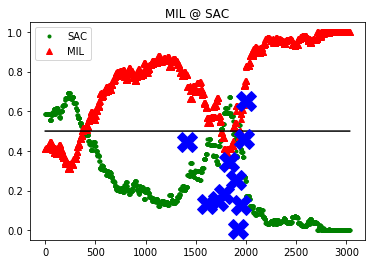

Game important plays: 
Top turning point descriptions: 
With 128.0 seconds left in quarter 4: Lee Free Throw 3 of 3 (15 PTS)
With 425.0 seconds left in quarter 3: Cauley-Stein 1' Tip Layup Shot (10 PTS)
With 438.0 seconds left in quarter 3: Lopez 28' 3PT Jump Shot (10 PTS) (Antetokounmpo 2 AST)
With 593.0 seconds left in quarter 4: Korver 30' 3PT Running Jump Shot (4 PTS) (Antetokounmpo 4 AST)
With 97.0 seconds left in quarter 2: Middleton 29' 3PT Pullup Jump Shot (10 PTS) (DiVincenzo 2 AST)
With 75.0 seconds left in quarter 2: Matthews  3PT Pullup Jump Shot (3 PTS) (DiVincenzo 3 AST)
With 665.0 seconds left in quarter 3: Lopez 27' 3PT Jump Shot (7 PTS) (Matthews 1 AST)
With 197.0 seconds left in quarter 2: Middleton 27' 3PT Jump Shot (5 PTS) (DiVincenzo 1 AST)
With 120.0 seconds left in quarter 2: Middleton Free Throw 1 of 2 (7 PTS)
With 1.0 seconds left in quarter 3: SUB: Smailagic FOR Paschall
Done


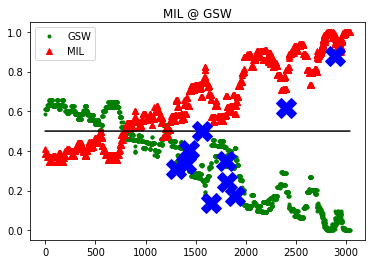

Game important plays: 
Top turning point descriptions: 
With 547.0 seconds left in quarter 3: Forbes  3PT Jump Shot (5 PTS) (DeRozan 5 AST)
With 616.0 seconds left in quarter 2: Gay 26' 3PT Jump Shot (5 PTS) (White 1 AST)
With 103.0 seconds left in quarter 3: Mills 25' 3PT Pullup Jump Shot (15 PTS)
With 498.0 seconds left in quarter 2: Murray 25' 3PT Pullup Jump Shot (8 PTS)
With 447.0 seconds left in quarter 2: Lyles  3PT Jump Shot (3 PTS) (DeRozan 2 AST)
With 136.0 seconds left in quarter 3: Gay 12' Pullup Jump Shot (7 PTS) (Walker IV 1 AST)
With 582.0 seconds left in quarter 3: Aldridge 2' Driving Finger Roll Layup (12 PTS)
With 0.0 seconds left in quarter 1: End of 1st Period (9:02 PM EST)
With 22.0 seconds left in quarter 3: Mills  3PT Step Back Jump Shot (18 PTS)
With 666.0 seconds left in quarter 4: Gay REBOUND (Off:1 Def:6)
Done


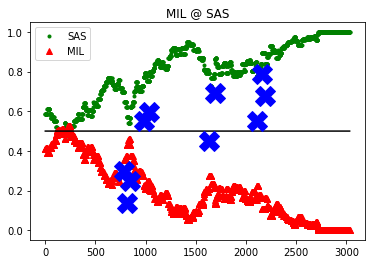

Game important plays: 
Top turning point descriptions: 
With 289.0 seconds left in quarter 2: DeRozan 1' Tip Layup Shot (8 PTS)
With 226.0 seconds left in quarter 3: Antetokounmpo 26' 3PT Jump Shot (24 PTS)
With 346.0 seconds left in quarter 2: Korver 27' 3PT Jump Shot (9 PTS) (Antetokounmpo 1 AST)
With 395.0 seconds left in quarter 2: Bledsoe 25' 3PT Pullup Jump Shot (14 PTS) (Matthews 1 AST)
With 528.0 seconds left in quarter 3: Bledsoe REBOUND (Off:1 Def:1)
With 445.0 seconds left in quarter 2: Korver 26' 3PT Jump Shot (6 PTS) (Bledsoe 4 AST)
With 274.0 seconds left in quarter 2: Ilyasova 28' 3PT Step Back Jump Shot (7 PTS) (G. Hill 3 AST)
With 155.0 seconds left in quarter 2: Middleton 27' 3PT Jump Shot (10 PTS) (G. Hill 4 AST)
With 314.0 seconds left in quarter 3: Antetokounmpo 1' Running Layup (17 PTS)
With 703.0 seconds left in quarter 2: Bledsoe 26' 3PT Jump Shot (5 PTS) (Korver 4 AST)
Done


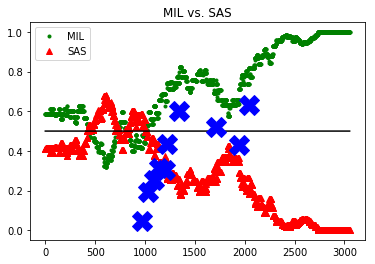

Game important plays: 
Top turning point descriptions: 
With 0.0 seconds left in quarter 4: MISS Covington 88' 3PT Jump Shot#@#Antetokounmpo BLOCK (2 BLK)
With 111.0 seconds left in quarter 4: Antetokounmpo 27' 3PT Jump Shot (32 PTS) (Lopez 3 AST)
With 1.0 seconds left in quarter 4: Lopez REBOUND (Off:0 Def:4)
With 417.0 seconds left in quarter 4: Middleton 26' 3PT Pullup Jump Shot (13 PTS)
With 525.0 seconds left in quarter 4: Korver 26' 3PT Jump Shot (8 PTS) (Middleton 4 AST)
With 46.0 seconds left in quarter 4: MISS Dieng Free Throw 2 of 2
With 44.0 seconds left in quarter 4: Antetokounmpo REBOUND (Off:3 Def:14)
With 323.0 seconds left in quarter 4: G. Hill S.FOUL (P1.T2) (N.Buchert)
With 192.0 seconds left in quarter 2: Lopez 27' 3PT Running Jump Shot (7 PTS) (Ilyasova 3 AST)
With 426.0 seconds left in quarter 4: Antetokounmpo 2' Layup (25 PTS)
Done


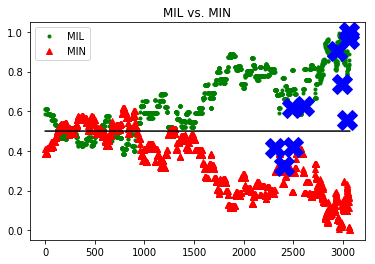

Game important plays: 
Top turning point descriptions: 
With 650.0 seconds left in quarter 3: Lopez 24' 3PT Jump Shot (9 PTS) (Antetokounmpo 3 AST)
With 172.0 seconds left in quarter 2: Ilyasova REBOUND (Off:1 Def:2)
With 86.0 seconds left in quarter 2: SUB: Dunn FOR White
With 673.0 seconds left in quarter 3: Bledsoe 2' Cutting Layup Shot (10 PTS) (Antetokounmpo 2 AST)
With 473.0 seconds left in quarter 3: Bledsoe 25' 3PT Jump Shot (15 PTS)
With 117.0 seconds left in quarter 2: White 1' Driving Floating Bank Jump Shot (13 PTS)
With 592.0 seconds left in quarter 3: Bledsoe 1' Cutting Finger Roll Layup Shot (12 PTS) (Middleton 3 AST)
With 216.0 seconds left in quarter 2: Markkanen 25' 3PT Jump Shot (11 PTS) (Satoransky 3 AST)
With 229.0 seconds left in quarter 1: Connaughton 26' 3PT Jump Shot (3 PTS) (Ilyasova 1 AST)
With 329.0 seconds left in quarter 2: Middleton 1' Driving Layup (11 PTS)
Done


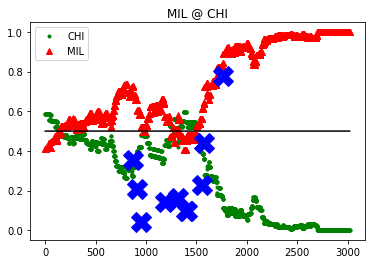

Game important plays: 
Top turning point descriptions: 
With 595.0 seconds left in quarter 4: Korver 26' 3PT Jump Shot (8 PTS) (Ilyasova 3 AST)
With 541.0 seconds left in quarter 4: Ilyasova 25' 3PT Jump Shot (14 PTS) (Connaughton 5 AST)
With 512.0 seconds left in quarter 3: Ilyasova 26' 3PT Jump Shot (11 PTS) (Middleton 4 AST)
With 77.0 seconds left in quarter 3: Lopez 1' Driving Layup (12 PTS) (Connaughton 4 AST)
With 116.0 seconds left in quarter 3: Middleton 9' Turnaround Fadeaway (19 PTS)
With 672.0 seconds left in quarter 4: G. Hill 1' Layup (11 PTS)
With 223.0 seconds left in quarter 3: Middleton 1' Driving Layup (17 PTS) (Connaughton 3 AST)
With 247.0 seconds left in quarter 3: G. Hill  Running Dunk (7 PTS) (Middleton 5 AST)
With 455.0 seconds left in quarter 4: DiVincenzo 27' 3PT Jump Shot (5 PTS) (Lopez 1 AST)
With 53.0 seconds left in quarter 3: G. Hill 1' Running Finger Roll Layup (9 PTS) (Middleton 6 AST)
Done


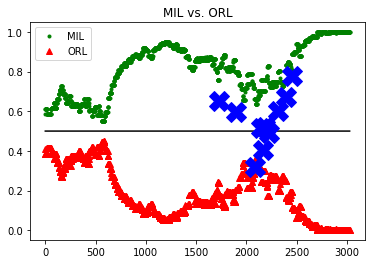

Game important plays: 
Top turning point descriptions: 
With 477.0 seconds left in quarter 2: Korver 33' 3PT Jump Shot (3 PTS) (Lopez 3 AST)
With 710.0 seconds left in quarter 1: Lopez Free Throw 1 of 1 (3 PTS)
With 338.0 seconds left in quarter 1: Lopez 26' 3PT Jump Shot (9 PTS) (Middleton 3 AST)
With 448.0 seconds left in quarter 2: Ilyasova 1' Cutting Layup Shot (6 PTS) (Middleton 5 AST)
With 537.0 seconds left in quarter 2: Ilyasova 1' Cutting Layup Shot (4 PTS) (Lopez 2 AST)
With 512.0 seconds left in quarter 2: Lopez 1' Alley Oop Dunk (15 PTS) (Middleton 4 AST)
With 493.0 seconds left in quarter 1: Young 27' 3PT Running Pull-Up Jump Shot (5 PTS)
With 422.0 seconds left in quarter 2: Ilyasova 18' Jump Shot (8 PTS) (Middleton 6 AST)
With 586.0 seconds left in quarter 2: Lopez 8' Turnaround Hook Shot (13 PTS) (Connaughton 1 AST)
With 244.0 seconds left in quarter 2: Middleton 26' 3PT Pullup Jump Shot (16 PTS)
Done


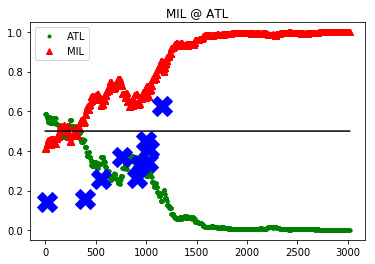

Game important plays: 
Top turning point descriptions: 
With 166.0 seconds left in quarter 1: Ennis III REBOUND (Off:2 Def:1)
With 6.0 seconds left in quarter 1: Embiid 25' 3PT Jump Shot (14 PTS)
With 205.0 seconds left in quarter 1: Horford 25' 3PT Step Back Jump Shot (3 PTS) (Simmons 3 AST)
With 61.0 seconds left in quarter 1: Burke  3PT Jump Shot (3 PTS) (Richardson 1 AST)
With 398.0 seconds left in quarter 1: Korkmaz Free Throw 1 of 3 (2 PTS)
With 348.0 seconds left in quarter 1: Harris 27' 3PT Jump Shot (5 PTS) (Horford 3 AST)
With 607.0 seconds left in quarter 2: Richardson 24' 3PT Jump Shot (8 PTS) (Embiid 1 AST)
With 332.0 seconds left in quarter 2: Harris 26' 3PT Pullup Jump Shot (12 PTS) (Simmons 5 AST)
With 431.0 seconds left in quarter 1: Embiid 25' 3PT Jump Shot (7 PTS) (Horford 2 AST)
With 506.0 seconds left in quarter 2: Richardson 27' 3PT Jump Shot (11 PTS) (Harris 1 AST)
Done


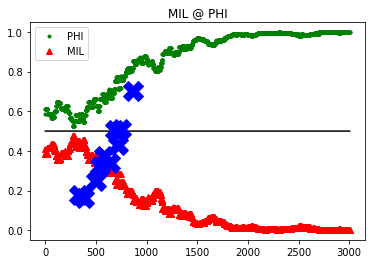

Game important plays: 
Top turning point descriptions: 
With 25.0 seconds left in quarter 2: G. Hill 26' 3PT Running Jump Shot (13 PTS) (Antetokounmpo 4 AST)
With 136.0 seconds left in quarter 2: G. Hill 26' 3PT Jump Shot (10 PTS) (Antetokounmpo 3 AST)
With 401.0 seconds left in quarter 2: Matthews 25' 3PT Step Back Jump Shot (8 PTS) (Middleton 2 AST)
With 585.0 seconds left in quarter 2: Korver 24' 3PT Jump Shot (3 PTS) (Lopez 1 AST)
With 332.0 seconds left in quarter 2: G. Hill 27' 3PT Jump Shot (3 PTS)
With 0.0 seconds left in quarter 1: Antetokounmpo REBOUND (Off:2 Def:2)
With 11.0 seconds left in quarter 1: Antetokounmpo REBOUND (Off:2 Def:1)
With 701.0 seconds left in quarter 2: Lopez 26' 3PT Jump Shot (3 PTS) (Connaughton 1 AST)
With 53.0 seconds left in quarter 2: DiVincenzo 3' Driving Layup (2 PTS)
With 214.0 seconds left in quarter 2: G. Hill 2' Driving Layup (5 PTS)
Done


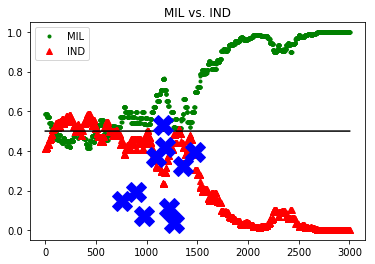

Game important plays: 
Top turning point descriptions: 
With 144.0 seconds left in quarter 2: MISS Ilyasova Free Throw 2 of 2
With 525.0 seconds left in quarter 2: Lopez  3PT Jump Shot (12 PTS) (Antetokounmpo 4 AST)
With 549.0 seconds left in quarter 2: Middleton 26' 3PT Jump Shot (6 PTS) (Antetokounmpo 3 AST)
With 205.0 seconds left in quarter 1: SUB: Portis FOR Randle
With 0.0 seconds left in quarter 2: G. Hill 25' 3PT Jump Shot (10 PTS) (Antetokounmpo 9 AST)
With 394.0 seconds left in quarter 2: DiVincenzo  3PT Jump Shot (8 PTS) (Antetokounmpo 5 AST)
With 367.0 seconds left in quarter 2: Korver  3PT Jump Shot (3 PTS) (Antetokounmpo 6 AST)
With 147.0 seconds left in quarter 1: G. Hill 25' 3PT Jump Shot (3 PTS) (Connaughton 2 AST)
With 205.0 seconds left in quarter 1: Bucks Timeout: Regular (Reg.1 Short 0)
With 63.0 seconds left in quarter 2: G. Hill 1' Running Dunk (7 PTS) (Antetokounmpo 8 AST)
Done


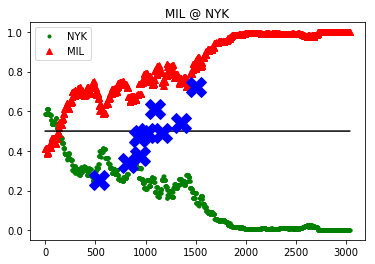

Game important plays: 
Top turning point descriptions: 
With 210.0 seconds left in quarter 1: Bradley S.FOUL (P1.T3) (M.Davis)
With 123.0 seconds left in quarter 4: Davis 2' Running Dunk (36 PTS) (James 11 AST)
With 548.0 seconds left in quarter 2: Antetokounmpo 29' 3PT Jump Shot (12 PTS) (DiVincenzo 2 AST)
With 231.0 seconds left in quarter 4: SUB: Caruso FOR Howard
With 668.0 seconds left in quarter 2: Antetokounmpo REBOUND (Off:2 Def:2)
With 444.0 seconds left in quarter 1: Antetokounmpo REBOUND (Off:1 Def:0)
With 312.0 seconds left in quarter 1: G. Hill 24' 3PT Jump Shot (6 PTS) (Middleton 1 AST)
With 339.0 seconds left in quarter 1: G. Hill 24' 3PT Jump Shot (3 PTS) (Antetokounmpo 3 AST)
With 162.0 seconds left in quarter 2: Davis 1' Tip Dunk Shot (7 PTS)
With 663.0 seconds left in quarter 4: Antetokounmpo 1' Alley Oop Dunk (25 PTS) (Middleton 2 AST)
Done


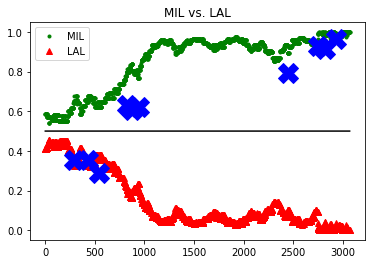

Game important plays: 
Top turning point descriptions: 
With 297.0 seconds left in quarter 3: Curry 28' 3PT Jump Shot (13 PTS) (Porzingis 3 AST)
With 5.0 seconds left in quarter 4: SUB: Matthews FOR Korver
With 621.0 seconds left in quarter 3: Finney-Smith 26' 3PT Jump Shot (11 PTS) (Brunson 5 AST)
With 251.0 seconds left in quarter 3: Curry 27' 3PT Jump Shot (17 PTS) (Finney-Smith 1 AST)
With 366.0 seconds left in quarter 4: Porzingis 30' 3PT Jump Shot (23 PTS)
With 2.0 seconds left in quarter 4: Mavericks Rebound
With 445.0 seconds left in quarter 4: Mavericks Timeout: Regular (Reg.5 Short 0)
With 329.0 seconds left in quarter 3: Curry 7' Driving Layup (10 PTS)
With 469.0 seconds left in quarter 1: Brunson 1' Tip Layup Shot (2 PTS)
With 644.0 seconds left in quarter 2: Connaughton 1' Putback Layup (5 PTS)
Done


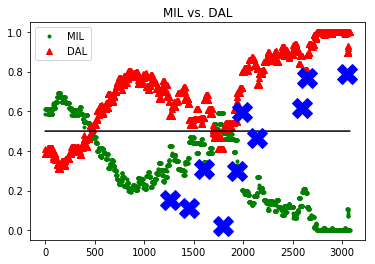

Game important plays: 
Top turning point descriptions: 
With 326.0 seconds left in quarter 1: Thompson 1' Tip Layup Shot (6 PTS)
With 337.0 seconds left in quarter 2: Lopez 27' 3PT Jump Shot (5 PTS) (Antetokounmpo 3 AST)
With 376.0 seconds left in quarter 2: Middleton 25' 3PT Pullup Jump Shot (9 PTS) (DiVincenzo 1 AST)
With 569.0 seconds left in quarter 2: Korver 28' 3PT Jump Shot (6 PTS) (Antetokounmpo 2 AST)
With 654.0 seconds left in quarter 2: Korver 25' 3PT Jump Shot (3 PTS)
With 398.0 seconds left in quarter 1: Love Out of Bounds - Bad Pass Turnover Turnover (P1.T2)
With 174.0 seconds left in quarter 2: Middleton 27' 3PT Pullup Jump Shot (14 PTS)
With 192.0 seconds left in quarter 1: Ilyasova 30' 3PT Jump Shot (3 PTS) (Connaughton 1 AST)
With 397.0 seconds left in quarter 2: Antetokounmpo 1' Cutting Layup Shot (15 PTS) (Middleton 4 AST)
With 435.0 seconds left in quarter 2: Antetokounmpo 1' Running Dunk (13 PTS)
Done


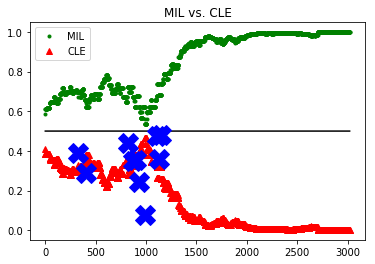

Game important plays: 
Top turning point descriptions: 
With 393.0 seconds left in quarter 4: Middleton  3PT Jump Shot (26 PTS) (G. Hill 4 AST)
With 594.0 seconds left in quarter 4: S. Hill 25' 3PT Jump Shot (8 PTS) (Jones 7 AST)
With 385.0 seconds left in quarter 3: Lopez 1' Tip Dunk Shot (7 PTS)
With 360.0 seconds left in quarter 4: Antetokounmpo 26' 3PT Jump Shot (28 PTS)
With 401.0 seconds left in quarter 3: Crowder 25' 3PT Jump Shot (11 PTS)
With 401.0 seconds left in quarter 3: Crowder 25' 3PT Jump Shot (11 PTS)
With 374.0 seconds left in quarter 3: Jackson Jr. 26' 3PT Jump Shot (22 PTS) (Crowder 2 AST)
With 281.0 seconds left in quarter 3: Jackson Jr. 26' 3PT Jump Shot (25 PTS) (Melton 3 AST)
With 0.0 seconds left in quarter 2: Instant Replay2nd Period (9:09 PM EST)
With 31.0 seconds left in quarter 2: Crowder 25' 3PT Jump Shot (8 PTS) (S. Hill 2 AST)
Done


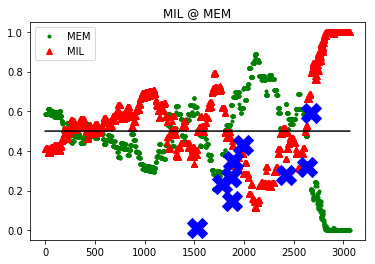

Game important plays: 
Top turning point descriptions: 
With 601.0 seconds left in quarter 1: Redick Free Throw 1 of 1 (4 PTS)
With 572.0 seconds left in quarter 1: Bledsoe REBOUND (Off:0 Def:1)
With 375.0 seconds left in quarter 1: Bledsoe 26' 3PT Jump Shot (9 PTS)
With 548.0 seconds left in quarter 1: Holiday Bad Pass Turnover (P1.T1)#@#Matthews STEAL (1 STL)
With 567.0 seconds left in quarter 1: Bledsoe 26' 3PT Running Jump Shot (3 PTS)
With 541.0 seconds left in quarter 1: Ilyasova 26' 3PT Jump Shot (3 PTS) (Bledsoe 1 AST)
With 526.0 seconds left in quarter 1: Middleton REBOUND (Off:0 Def:1)
With 515.0 seconds left in quarter 1: Bledsoe 26' 3PT Jump Shot (6 PTS)
With 145.0 seconds left in quarter 3: Brown 27' 3PT Jump Shot (5 PTS) (G. Hill 3 AST)
With 292.0 seconds left in quarter 1: DiVincenzo 26' 3PT Jump Shot (3 PTS) (Wilson 1 AST)
Done


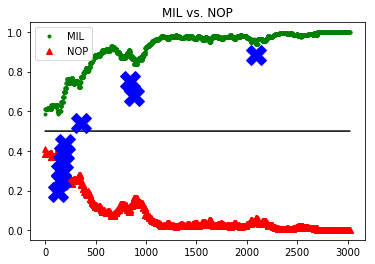

Game important plays: 
Top turning point descriptions: 
With 284.0 seconds left in quarter 4: Fultz Free Throw 2 of 2 (12 PTS)
With 333.0 seconds left in quarter 4: Middleton 26' 3PT Running Jump Shot (17 PTS) (Bledsoe 7 AST)
With 225.0 seconds left in quarter 4: Isaac 1' Putback Dunk (10 PTS)
With 529.0 seconds left in quarter 4: Middleton 26' 3PT Jump Shot (12 PTS) (Lopez 2 AST)
With 1.0 seconds left in quarter 3: Ilyasova 12' Turnaround Fadeaway (11 PTS) (Middleton 3 AST)
With 556.0 seconds left in quarter 4: G. Hill 1' Driving Finger Roll Layup (7 PTS)
With 587.0 seconds left in quarter 4: G. Hill 1' Cutting Layup Shot (5 PTS) (Middleton 4 AST)
With 164.0 seconds left in quarter 1: Ilyasova 26' 3PT Running Jump Shot (3 PTS) (Antetokounmpo 3 AST)
With 516.0 seconds left in quarter 2: Lopez 25' 3PT Jump Shot (6 PTS) (Antetokounmpo 4 AST)
With 674.0 seconds left in quarter 4: Lopez 5' Turnaround Hook Shot (4 PTS)
Done


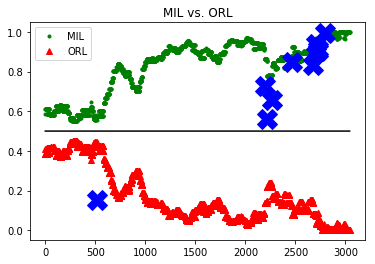

Game important plays: 
Top turning point descriptions: 
With 392.0 seconds left in quarter 1: Harkless Out of Bounds - Bad Pass Turnover Turnover (P1.T3)
With 629.0 seconds left in quarter 3: Matthews 26' 3PT Jump Shot (9 PTS) (Bledsoe 4 AST)
With 473.0 seconds left in quarter 2: Matthews 27' 3PT Jump Shot (3 PTS) (Middleton 1 AST)
With 375.0 seconds left in quarter 2: Matthews 24' 3PT Running Jump Shot (6 PTS) (Bledsoe 3 AST)
With 278.0 seconds left in quarter 1: Bledsoe 26' 3PT Pullup Jump Shot (5 PTS)
With 306.0 seconds left in quarter 1: Connaughton 26' 3PT Jump Shot (3 PTS) (Matthews 1 AST)
With 467.0 seconds left in quarter 3: Antetokounmpo 26' 3PT Jump Shot (20 PTS)
With 658.0 seconds left in quarter 2: BUCKS Timeout: Regular (Full 2 Short 0)
With 255.0 seconds left in quarter 1: Connaughton 27' 3PT Jump Shot (6 PTS) (Bledsoe 1 AST)
With 223.0 seconds left in quarter 1: Ilyasova 26' 3PT Step Back Jump Shot (3 PTS) (Bledsoe 2 AST)
Done


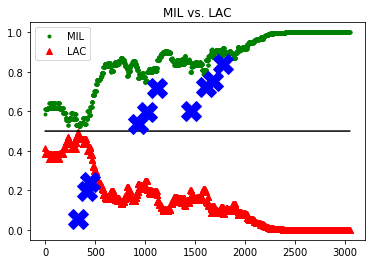

Game important plays: 
Top turning point descriptions: 
With 332.0 seconds left in quarter 2: Matthews P.FOUL (P1.PN) (P.Fraher)
With 20.0 seconds left in quarter 2: Drummond 1' Tip Dunk Shot (8 PTS)
With 478.0 seconds left in quarter 2: Bledsoe 26' 3PT Pullup Jump Shot (5 PTS)
With 601.0 seconds left in quarter 1: Antetokounmpo 1' Tip Layup Shot (2 PTS)
With 442.0 seconds left in quarter 2: Antetokounmpo 27' 3PT Jump Shot (16 PTS)
With 161.0 seconds left in quarter 2: Lopez 27' 3PT Jump Shot (3 PTS) (Matthews 1 AST)
With 62.0 seconds left in quarter 1: Galloway 26' 3PT Jump Shot (6 PTS) (Rose 2 AST)
With 96.0 seconds left in quarter 1: Wood REBOUND (Off:1 Def:0)
With 178.0 seconds left in quarter 1: Galloway  3PT Jump Shot (3 PTS) (Rose 1 AST)
With 317.0 seconds left in quarter 1: Griffin 25' 3PT Jump Shot (5 PTS) (Drummond 1 AST)
Done


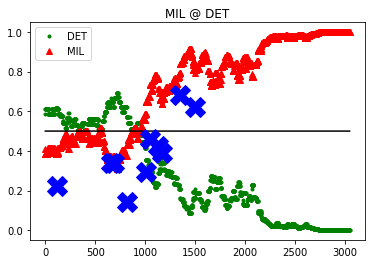

Game important plays: 
Top turning point descriptions: 
With 426.0 seconds left in quarter 1: Randle Free Throw 1 of 1 (5 PTS)
With 168.0 seconds left in quarter 1: G. Hill 26' 3PT Jump Shot (3 PTS) (Ilyasova 1 AST)
With 467.0 seconds left in quarter 1: Middleton 26' 3PT Jump Shot (6 PTS) (Antetokounmpo 2 AST)
With 522.0 seconds left in quarter 1: Antetokounmpo REBOUND (Off:1 Def:1)
With 503.0 seconds left in quarter 1: BUCKS Rebound
With 680.0 seconds left in quarter 1: Bledsoe REBOUND (Off:0 Def:1)
With 475.0 seconds left in quarter 1: Bledsoe REBOUND (Off:0 Def:2)
With 650.0 seconds left in quarter 1: Lopez REBOUND (Off:0 Def:1)
With 608.0 seconds left in quarter 1: Out-of-Bounds
With 585.0 seconds left in quarter 1: Middleton REBOUND (Off:0 Def:1)
Done


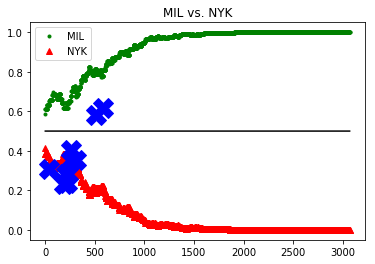

Game important plays: 
Top turning point descriptions: 
With 494.0 seconds left in quarter 2: Antetokounmpo REBOUND (Off:3 Def:3)
With 401.0 seconds left in quarter 2: Lopez 28' 3PT Jump Shot (11 PTS) (Antetokounmpo 2 AST)
With 575.0 seconds left in quarter 2: Antetokounmpo 27' 3PT Jump Shot (13 PTS) (Korver 1 AST)
With 641.0 seconds left in quarter 2: G. Hill 24' 3PT Jump Shot (10 PTS) (Middleton 1 AST)
With 328.0 seconds left in quarter 1: Batum Bad Pass Turnover (P1.T1)#@#Antetokounmpo STEAL (1 STL)
With 692.0 seconds left in quarter 2: Antetokounmpo REBOUND (Off:2 Def:2)
With 462.0 seconds left in quarter 2: Antetokounmpo 8' Turnaround Fadeaway (17 PTS)
With 63.0 seconds left in quarter 1: G. Hill 25' 3PT Jump Shot (7 PTS) (Wilson 1 AST)
With 429.0 seconds left in quarter 2: Antetokounmpo 3' Driving Layup (19 PTS) (Lopez 1 AST)
With 367.0 seconds left in quarter 1: Lopez  3PT Jump Shot (8 PTS) (Bledsoe 4 AST)
Done


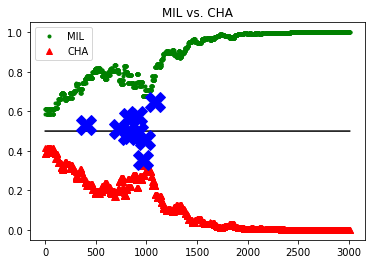

Game important plays: 
Top turning point descriptions: 
With 211.0 seconds left in quarter 4: Jump Ball Nance Jr. vs. Antetokounmpo: Tip to DiVincenzo
With 164.0 seconds left in quarter 4: Antetokounmpo 5' Driving Hook Shot (33 PTS)
With 127.0 seconds left in quarter 4: Middleton 4' Driving Floating Bank Jump Shot (12 PTS)
With 322.0 seconds left in quarter 4: Antetokounmpo 2' Dunk (27 PTS)
With 569.0 seconds left in quarter 4: Ilyasova 26' 3PT Jump Shot (10 PTS) (Antetokounmpo 2 AST)
With 449.0 seconds left in quarter 1: Antetokounmpo 1' Tip Dunk Shot (5 PTS)
With 150.0 seconds left in quarter 3: G. Hill  3PT Jump Shot (11 PTS) (Lopez 2 AST)
With 118.0 seconds left in quarter 3: G. Hill 27' 3PT Step Back Jump Shot (14 PTS)
With 197.0 seconds left in quarter 4: Antetokounmpo REBOUND (Off:3 Def:9)
With 1.0 seconds left in quarter 1: Lopez 29' 3PT Jump Shot (5 PTS) (Middleton 1 AST)
Done


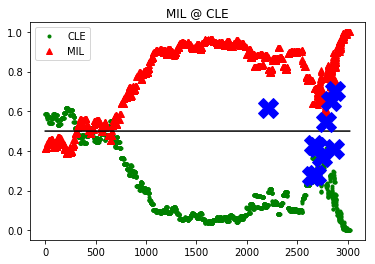

Game important plays: 
Top turning point descriptions: 
With 529.0 seconds left in quarter 4: Matthews  3PT Jump Shot (8 PTS) (DiVincenzo 2 AST)
With 317.0 seconds left in quarter 3: Bembry  3PT Jump Shot (3 PTS) (Crabbe 4 AST)
With 574.0 seconds left in quarter 3: Young 29' 3PT Jump Shot (21 PTS) (Parker 4 AST)
With 611.0 seconds left in quarter 4: Lopez REBOUND (Off:2 Def:1)
With 0.0 seconds left in quarter 2: Instant Replay2nd Period (9:14 PM EST)
With 619.0 seconds left in quarter 4: Antetokounmpo 1' Putback Layup (27 PTS)
With 705.0 seconds left in quarter 4: DiVincenzo  Driving Finger Roll Layup (8 PTS)
With 359.0 seconds left in quarter 4: Matthews 2' Layup (10 PTS) (Lopez 2 AST)
With 395.0 seconds left in quarter 4: Ilyasova 1' Tip Layup Shot (13 PTS)
With 469.0 seconds left in quarter 4: Bledsoe 15' Pullup Jump Shot (6 PTS)
Done


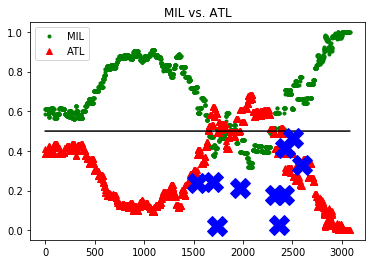

Game important plays: 
Top turning point descriptions: 
With 3.0 seconds left in quarter 4: Lopez REBOUND (Off:0 Def:7)
With 297.0 seconds left in quarter 4: Antetokounmpo 26' 3PT Jump Shot (42 PTS) (Lopez 2 AST)
With 275.0 seconds left in quarter 4: Antetokounmpo REBOUND (Off:4 Def:7)
With 267.0 seconds left in quarter 4: DiVincenzo REBOUND (Off:2 Def:3)
With 513.0 seconds left in quarter 3: Mitchell 27' 3PT Jump Shot (12 PTS)
With 552.0 seconds left in quarter 3: Bogdanovic 28' 3PT Jump Shot (16 PTS)
With 11.0 seconds left in quarter 3: Connaughton 25' 3PT Jump Shot (7 PTS) (Antetokounmpo 6 AST)
With 179.0 seconds left in quarter 4: Antetokounmpo 1' Driving Dunk (44 PTS) (Bledsoe 5 AST)
With 444.0 seconds left in quarter 3: Bogdanovic 27' 3PT Jump Shot (21 PTS)
With 614.0 seconds left in quarter 3: Green 7' Fadeaway Jumper (5 PTS) (Conley 8 AST)
Done


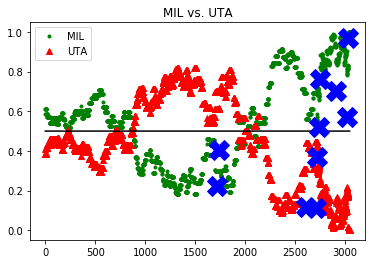

Game important plays: 
Top turning point descriptions: 
With 638.0 seconds left in quarter 3: Matthews Free Throw Technical (6 PTS)
With 460.0 seconds left in quarter 1: Drummond 1' Tip Layup Shot (4 PTS)
With 590.0 seconds left in quarter 1: Drummond 1' Tip Layup Shot (2 PTS)
With 361.0 seconds left in quarter 1: Matthews  3PT Jump Shot (3 PTS) (Antetokounmpo 2 AST)
With 300.0 seconds left in quarter 1: Bledsoe 27' 3PT Pullup Jump Shot (3 PTS)
With 274.0 seconds left in quarter 1: Lopez 24' 3PT Jump Shot (3 PTS) (Matthews 2 AST)
With 165.0 seconds left in quarter 1: Wilson  3PT Jump Shot (3 PTS) (G. Hill 1 AST)
With 651.0 seconds left in quarter 1: Drummond Out of Bounds Lost Ball Turnover (P1.T1)
With 679.0 seconds left in quarter 1: Antetokounmpo REBOUND (Off:0 Def:2)
With 622.0 seconds left in quarter 1: Bledsoe REBOUND (Off:0 Def:1)
Done


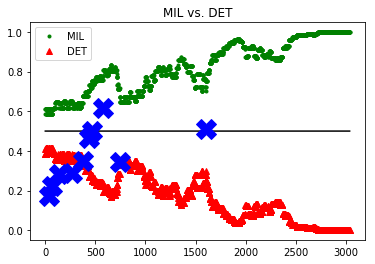

Game important plays: 
Top turning point descriptions: 
With 420.0 seconds left in quarter 4: Lopez 31' 3PT Jump Shot (10 PTS) (Antetokounmpo 13 AST)
With 298.0 seconds left in quarter 1: Anthony Traveling Turnover (P2.T2)
With 449.0 seconds left in quarter 3: BUCKS Timeout: Regular (Full 3 Short 0)
With 485.0 seconds left in quarter 3: DiVincenzo 27' 3PT Jump Shot (9 PTS) (Bledsoe 4 AST)
With 61.0 seconds left in quarter 1: G. Hill 26' 3PT Step Back Jump Shot (5 PTS)
With 631.0 seconds left in quarter 2: Bledsoe  3PT Jump Shot (10 PTS)
With 33.0 seconds left in quarter 1: Connaughton 24' 3PT Jump Shot (5 PTS) (Antetokounmpo 4 AST)
With 465.0 seconds left in quarter 2: Matthews 27' 3PT Jump Shot (6 PTS) (Bledsoe 2 AST)
With 209.0 seconds left in quarter 2: Brown  3PT Jump Shot (5 PTS) (Antetokounmpo 5 AST)
With 97.0 seconds left in quarter 2: Brown 27' 3PT Jump Shot (8 PTS) (Lopez 3 AST)
Done


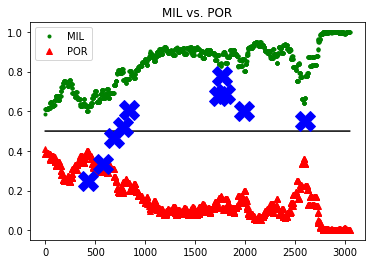

Game important plays: 
Top turning point descriptions: 
With 2.0 seconds left in quarter 1: G. Hill P.FOUL (P1.PN) (K.Fitzgerald)
With 261.0 seconds left in quarter 3: Antetokounmpo 25' 3PT Pullup Jump Shot (29 PTS)
With 70.0 seconds left in quarter 2: Parker 25' 3PT Jump Shot (10 PTS) (Crabbe 1 AST)
With 91.0 seconds left in quarter 3: Lopez 24' 3PT Jump Shot (5 PTS) (Brown 1 AST)
With 2.0 seconds left in quarter 1: SUB: Lopez FOR Lopez
With 620.0 seconds left in quarter 3: Matthews 25' 3PT Jump Shot (10 PTS) (Lopez 1 AST)
With 141.0 seconds left in quarter 3: Connaughton 1' Driving Layup (2 PTS) (Wilson 1 AST)
With 299.0 seconds left in quarter 3: Antetokounmpo 2' Cutting Dunk Shot (26 PTS) (G. Hill 3 AST)
With 589.0 seconds left in quarter 3: Antetokounmpo 9' Driving Hook Shot (15 PTS)
With 4.0 seconds left in quarter 1: Korver 25' 3PT Jump Shot (3 PTS) (Antetokounmpo 1 AST)
Done


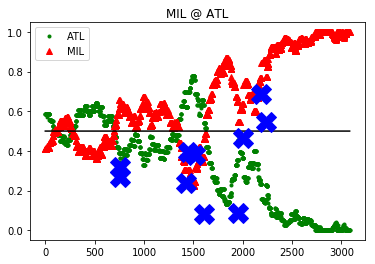

Game important plays: 
Top turning point descriptions: 
With 644.0 seconds left in quarter 4: G. Hill 25' 3PT Jump Shot (15 PTS) (Lopez 2 AST)
With 0.0 seconds left in quarter 3: End of 3rd Period (9:47 PM EST)
With 220.0 seconds left in quarter 3: Gafford 1' Tip Dunk Shot (18 PTS)
With 245.0 seconds left in quarter 3: G. Hill  3PT Jump Shot (8 PTS) (Brown 2 AST)
With 615.0 seconds left in quarter 3: Lopez 26' 3PT Jump Shot (6 PTS) (Bledsoe 4 AST)
With 304.0 seconds left in quarter 4: Bledsoe 2' Running Layup (7 PTS)
With 111.0 seconds left in quarter 3: Dunn 1' Putback Layup (6 PTS)
With 51.0 seconds left in quarter 2: Antetokounmpo REBOUND (Off:1 Def:1)
With 283.0 seconds left in quarter 4: Lopez Free Throw 1 of 2 (15 PTS)
With 283.0 seconds left in quarter 4: Bucks Rebound
Done


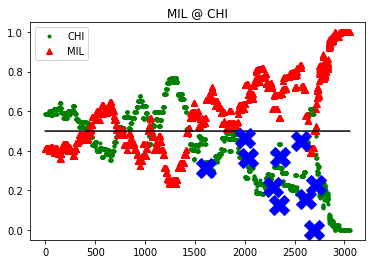

Game important plays: 
Top turning point descriptions: 
With 348.0 seconds left in quarter 2: DiVincenzo 26' 3PT Jump Shot (9 PTS) (Bledsoe 2 AST)
With 681.0 seconds left in quarter 4: Brown  3PT Jump Shot (5 PTS) (Antetokounmpo 6 AST)
With 222.0 seconds left in quarter 2: Matthews 25' 3PT Jump Shot (5 PTS) (Antetokounmpo 3 AST)
With 332.0 seconds left in quarter 3: Lopez 26' 3PT Jump Shot (9 PTS) (Antetokounmpo 5 AST)
With 109.0 seconds left in quarter 3: Ilyasova 13' Fadeaway Jumper (6 PTS) (G. Hill 3 AST)
With 540.0 seconds left in quarter 3: Antetokounmpo 24' 3PT Jump Shot (19 PTS) (Bledsoe 3 AST)
With 0.0 seconds left in quarter 1: End of 1st Period (7:32 PM EST)
With 585.0 seconds left in quarter 4: Brown  3PT Jump Shot (8 PTS) (Bledsoe 4 AST)
With 200.0 seconds left in quarter 1: Leaf 24' 3PT Jump Shot (3 PTS) (McDermott 1 AST)
With 382.0 seconds left in quarter 2: DiVincenzo 12' Driving Floating Bank Jump Shot (6 PTS)
Done


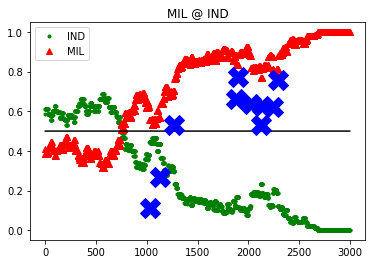

Game important plays: 
Top turning point descriptions: 
With 486.0 seconds left in quarter 3: Satoransky 25' 3PT Jump Shot (10 PTS) (LaVine 6 AST)
With 196.0 seconds left in quarter 4: SUB: Connaughton FOR DiVincenzo
With 331.0 seconds left in quarter 4: Connaughton 26' 3PT Jump Shot (6 PTS) (Antetokounmpo 4 AST)
With 631.0 seconds left in quarter 3: LaVine 25' 3PT Jump Shot (15 PTS) (Hutchison 3 AST)
With 205.0 seconds left in quarter 4: Matthews REBOUND (Off:0 Def:3)
With 219.0 seconds left in quarter 2: LaVine 29' 3PT Jump Shot (10 PTS)
With 257.0 seconds left in quarter 1: Young 1' Tip Layup Shot (2 PTS)
With 91.0 seconds left in quarter 3: Lopez 26' 3PT Jump Shot (13 PTS) (Connaughton 3 AST)
With 524.0 seconds left in quarter 2: White 26' 3PT Jump Shot (14 PTS)
With 475.0 seconds left in quarter 1: Carter Jr. 1' Tip Dunk Shot (4 PTS)
Done


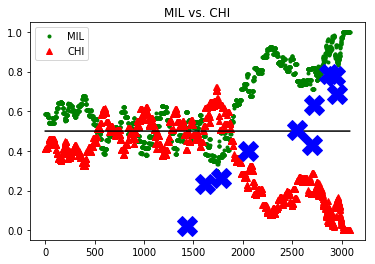

Game important plays: 
Top turning point descriptions: 
With 25.0 seconds left in quarter 4: Lopez 27' 3PT Jump Shot (15 PTS) (Matthews 2 AST)
With 32.0 seconds left in quarter 4: Bucks Timeout: Regular (Reg.5 Short 0)
With 154.0 seconds left in quarter 4: Bledsoe 26' 3PT Pullup Jump Shot (23 PTS)
With 355.0 seconds left in quarter 3: Bledsoe 26' 3PT Running Pull-Up Jump Shot (17 PTS) (Antetokounmpo 3 AST)
With 282.0 seconds left in quarter 4: Schroder OFF.Foul (P3) (B.Forte)
With 2.0 seconds left in quarter 2: Muscala 29' 3PT Jump Shot (12 PTS) (Paul 4 AST)
With 252.0 seconds left in quarter 4: Paul Lost Ball Turnover (P3.T15)#@#Antetokounmpo STEAL (1 STL)
With 76.0 seconds left in quarter 3: Brown 15' Pullup Jump Shot (9 PTS) (G. Hill 5 AST)
With 631.0 seconds left in quarter 3: Gallinari 29' 3PT Jump Shot (5 PTS) (Gilgeous-Alexander 4 AST)
With 158.0 seconds left in quarter 3: Ilyasova 3' Driving Layup (4 PTS) (G. Hill 4 AST)
Done


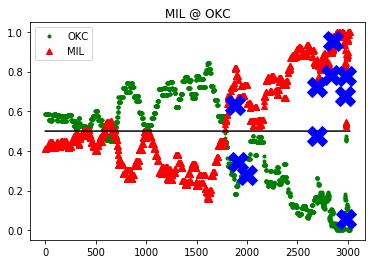

Game important plays: 
Top turning point descriptions: 
With 0.0 seconds left in quarter 4: Bogdanovic  3PT Jump Shot (33 PTS) (Ingles 3 AST)
With 8.0 seconds left in quarter 4: SUB: DiVincenzo FOR Korver
With 152.0 seconds left in quarter 4: O'Neale  3PT Jump Shot (11 PTS) (Mitchell 6 AST)
With 163.0 seconds left in quarter 4: Antetokounmpo Offensive Charge Foul (P5.PN) (L.Richardson)
With 203.0 seconds left in quarter 4: Gobert REBOUND (Off:2 Def:13)
With 348.0 seconds left in quarter 4: Antetokounmpo REBOUND (Off:3 Def:8)
With 230.0 seconds left in quarter 4: Bogdanovic Free Throw 1 of 2 (29 PTS)
With 328.0 seconds left in quarter 4: Mitchell 13' Floating Jump Shot (16 PTS)
With 8.0 seconds left in quarter 4: Gobert L.B.FOUL (P5.PN) (J.Williams)
With 249.0 seconds left in quarter 4: Gobert REBOUND (Off:2 Def:12)
Done


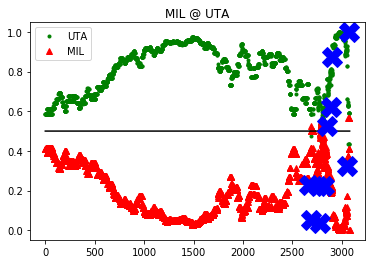

Game important plays: 
Top turning point descriptions: 
With 221.0 seconds left in quarter 3: G. Hill 24' 3PT Running Jump Shot (20 PTS) (Antetokounmpo 6 AST)
With 675.0 seconds left in quarter 4: Korver 26' 3PT Jump Shot (9 PTS) (Antetokounmpo 7 AST)
With 192.0 seconds left in quarter 3: Antetokounmpo 27' 3PT Pullup Jump Shot (25 PTS)
With 491.0 seconds left in quarter 4: Korver 27' 3PT Jump Shot (12 PTS) (Antetokounmpo 8 AST)
With 703.0 seconds left in quarter 4: Zubac 1' Tip Layup Shot (8 PTS)
With 10.0 seconds left in quarter 2: SUB: Harkless FOR Robinson
With 649.0 seconds left in quarter 2: Antetokounmpo 1' Tip Dunk Shot (6 PTS)
With 578.0 seconds left in quarter 3: Harrell 1' Putback Layup (18 PTS)
With 12.0 seconds left in quarter 4: Middleton Free Throw 1 of 2 (12 PTS)
With 30.0 seconds left in quarter 2: G. Hill 26' 3PT Running Pull-Up Jump Shot (17 PTS)
Done


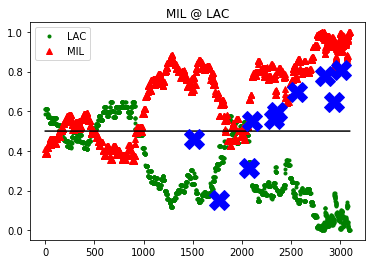

Game important plays: 
Top turning point descriptions: 
With 72.0 seconds left in quarter 2: G. Hill 26' 3PT Pullup Jump Shot (5 PTS)
With 690.0 seconds left in quarter 3: Matthews 26' 3PT Jump Shot (3 PTS) (Lopez 2 AST)
With 240.0 seconds left in quarter 2: Ilyasova 25' 3PT Jump Shot (5 PTS) (Middleton 3 AST)
With 0.0 seconds left in quarter 2: Bucks Timeout: Coach Challenge (Reg.2 Short 0)
With 0.0 seconds left in quarter 2: Bell S.FOUL (P1.PN) (B.Nansel)
With 560.0 seconds left in quarter 3: Teague Free Throw 2 of 2 (6 PTS)
With 342.0 seconds left in quarter 2: Bell Free Throw Flagrant 2 of 2 (4 PTS)
With 342.0 seconds left in quarter 2: Bell Free Throw Flagrant 2 of 2 (4 PTS)
With 342.0 seconds left in quarter 2: Bell Free Throw Flagrant 2 of 2 (4 PTS)
With 60.0 seconds left in quarter 1: Vonleh S.FOUL (P1.T3) (S.Wall)
Done


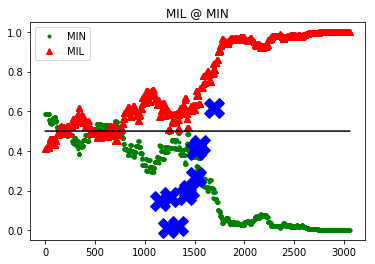

Game important plays: 
Top turning point descriptions: 
With 540.0 seconds left in quarter 1: Gasol Out of Bounds - Bad Pass Turnover Turnover (P1.T2)
With 272.0 seconds left in quarter 1: DiVincenzo 26' 3PT Jump Shot (3 PTS) (Middleton 1 AST)
With 682.0 seconds left in quarter 1: Bledsoe REBOUND (Off:0 Def:1)
With 23.0 seconds left in quarter 2: Brown 24' 3PT Jump Shot (6 PTS) (G. Hill 2 AST)
With 646.0 seconds left in quarter 1: Lowry Lost Ball Turnover (P1.T1)#@#Matthews STEAL (1 STL)
With 604.0 seconds left in quarter 1: Antetokounmpo REBOUND (Off:0 Def:1)
With 136.0 seconds left in quarter 1: DiVincenzo 28' 3PT Jump Shot (6 PTS) (Ilyasova 1 AST)
With 585.0 seconds left in quarter 1: Matthews REBOUND (Off:0 Def:1)
With 550.0 seconds left in quarter 1: Matthews REBOUND (Off:0 Def:2)
With 359.0 seconds left in quarter 1: G. Hill REBOUND (Off:0 Def:1)
Done


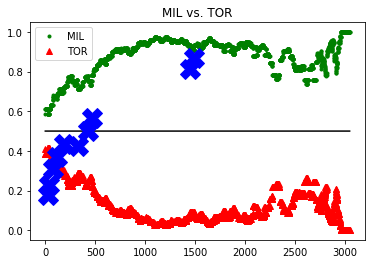

Game important plays: 
Top turning point descriptions: 
With 700.0 seconds left in quarter 2: DiVincenzo 26' 3PT Jump Shot (3 PTS) (Antetokounmpo 4 AST)
With 637.0 seconds left in quarter 2: DiVincenzo 26' 3PT Jump Shot (6 PTS) (G. Hill 1 AST)
With 65.0 seconds left in quarter 1: Ross 30' 3PT Pullup Jump Shot (4 PTS)
With 322.0 seconds left in quarter 2: Middleton 26' 3PT Jump Shot (5 PTS) (Bledsoe 4 AST)
With 317.0 seconds left in quarter 1: MAGIC Timeout: Regular (Full 1 Short 0)
With 705.0 seconds left in quarter 2: Brown REBOUND (Off:0 Def:3)
With 36.0 seconds left in quarter 1: MAGIC Rebound
With 56.0 seconds left in quarter 1: Antetokounmpo Lost Ball Turnover (P2.T5)#@#Ross STEAL (1 STL)
With 632.0 seconds left in quarter 1: Middleton Offensive Charge Foul (P1.T2) (M.Smith)
With 677.0 seconds left in quarter 1: Antetokounmpo Bad Pass Turnover (P1.T1)#@#Vucevic STEAL (1 STL)
Done


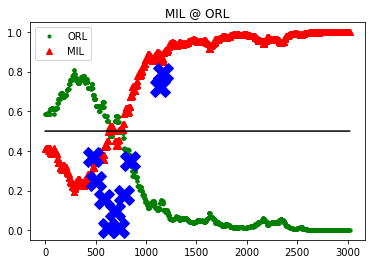

Game important plays: 
Top turning point descriptions: 
With 1.0 seconds left in quarter 2: Antetokounmpo Free Throw 1 of 3 (9 PTS)
With 652.0 seconds left in quarter 3: Lopez 24' 3PT Jump Shot (8 PTS) (Matthews 1 AST)
With 222.0 seconds left in quarter 1: Connaughton 27' 3PT Jump Shot (3 PTS) (G. Hill 1 AST)
With 341.0 seconds left in quarter 2: Matthews 24' 3PT Jump Shot (3 PTS) (Bledsoe 4 AST)
With 359.0 seconds left in quarter 1: Bledsoe 1' Driving Layup (5 PTS)
With 201.0 seconds left in quarter 1: Lopez 27' 3PT Jump Shot (3 PTS) (Connaughton 1 AST)
With 1.0 seconds left in quarter 2: CELTICS Timeout: Regular (Full 3 Short 0)
With 659.0 seconds left in quarter 2: Korver 26' 3PT Pullup Jump Shot (3 PTS) (Bledsoe 1 AST)
With 300.0 seconds left in quarter 1: Ilyasova 27' 3PT Step Back Jump Shot (3 PTS) (Middleton 1 AST)
With 198.0 seconds left in quarter 2: G. Hill 27' 3PT Jump Shot (7 PTS)
Done


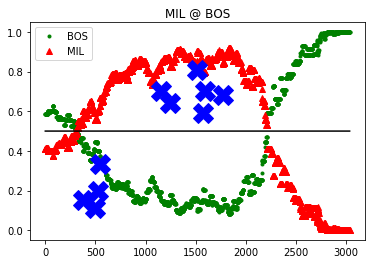

Game important plays: 
Top turning point descriptions: 
With 566.0 seconds left in quarter 4: Thompson 1' Tip Dunk Shot (11 PTS)
With 404.0 seconds left in quarter 1: Nance Jr. 1' Tip Dunk Shot (2 PTS)
With 431.0 seconds left in quarter 2: Thompson 1' Tip Dunk Shot (8 PTS)
With 606.0 seconds left in quarter 2: Connaughton 27' 3PT Jump Shot (11 PTS) (Bledsoe 4 AST)
With 645.0 seconds left in quarter 3: Matthews 26' 3PT Jump Shot (7 PTS) (Bledsoe 7 AST)
With 524.0 seconds left in quarter 4: Bledsoe 1' Reverse Layup (10 PTS) (Antetokounmpo 5 AST)
With 199.0 seconds left in quarter 2: G. Hill 24' 3PT Jump Shot (4 PTS) (Lopez 1 AST)
With 371.0 seconds left in quarter 3: Matthews 27' 3PT Jump Shot (12 PTS) (Lopez 1 AST)
With 94.0 seconds left in quarter 1: Connaughton 28' 3PT Jump Shot (3 PTS) (G. Hill 2 AST)
With 533.0 seconds left in quarter 2: Connaughton 27' 3PT Jump Shot (14 PTS) (Bledsoe 5 AST)
Done


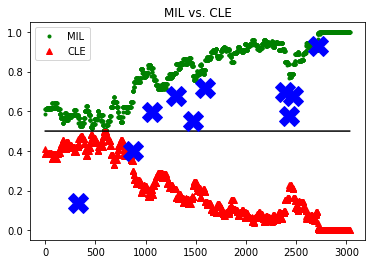

Game important plays: 
Top turning point descriptions: 
With 590.0 seconds left in quarter 2: G. Hill 27' 3PT Jump Shot (5 PTS) (Antetokounmpo 5 AST)
With 503.0 seconds left in quarter 2: Korver 24' 3PT Jump Shot (6 PTS) (Antetokounmpo 7 AST)
With 570.0 seconds left in quarter 2: Matthews  3PT Running Jump Shot (6 PTS) (Antetokounmpo 6 AST)
With 471.0 seconds left in quarter 2: Korver 26' 3PT Jump Shot (9 PTS) (G. Hill 3 AST)
With 392.0 seconds left in quarter 2: Matthews 26' 3PT Jump Shot (9 PTS) (Lopez 1 AST)
With 668.0 seconds left in quarter 2: Lopez 26' 3PT Jump Shot (3 PTS) (Antetokounmpo 4 AST)
With 438.0 seconds left in quarter 1: SUB: G. Hill FOR Bledsoe
With 295.0 seconds left in quarter 2: Lopez 27' 3PT Jump Shot (6 PTS) (Ilyasova 1 AST)
With 214.0 seconds left in quarter 2: Ilyasova 25' 3PT Jump Shot (5 PTS) (Bledsoe 1 AST)
With 424.0 seconds left in quarter 1: Middleton 26' 3PT Jump Shot (11 PTS) (G. Hill 1 AST)
Done


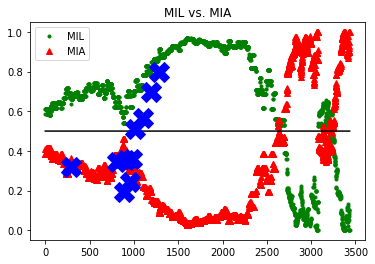

Game important plays: 
Top turning point descriptions: 
With 218.0 seconds left in quarter 4: Middleton 26' 3PT Jump Shot (11 PTS) (Bledsoe 1 AST)
With 92.0 seconds left in quarter 4: Matthews 26' 3PT Jump Shot (14 PTS) (G. Hill 6 AST)
With 331.0 seconds left in quarter 4: Lopez 26' 3PT Jump Shot (5 PTS) (G. Hill 5 AST)
With 482.0 seconds left in quarter 4: Westbrook 5' Running Layup (13 PTS) (Harden 12 AST)
With 359.0 seconds left in quarter 4: Matthews 5' Driving Floating Jump Shot (11 PTS) (Antetokounmpo 11 AST)
With 194.0 seconds left in quarter 4: Lopez 10' Hook Shot (7 PTS) (Bledsoe 2 AST)
With 120.0 seconds left in quarter 4: Ilyasova 21' Jump Shot (11 PTS) (Lopez 3 AST)
With 462.0 seconds left in quarter 4: Westbrook  Running Dunk (16 PTS) (Harden 13 AST)
With 207.0 seconds left in quarter 4: Harden OFF.Foul (P5) (M.Boland)
With 233.0 seconds left in quarter 4: Matthews REBOUND (Off:0 Def:4)
Done


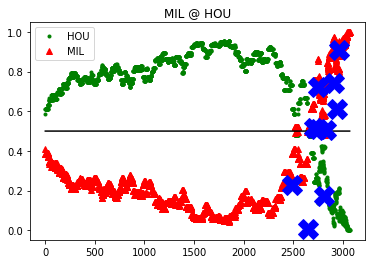

In [13]:
generate_win_probability_team('MIL', 'game')

Game important plays: 
Top turning point descriptions: 
With 132.0 seconds left in quarter 4: Williams Free Throw 2 of 3 (26 PTS)
With 624.0 seconds left in quarter 2: Porter Jr. 25' 3PT Jump Shot (7 PTS) (Plumlee 2 AST)
With 130.0 seconds left in quarter 4: Barton REBOUND (Off:0 Def:4)
With 105.0 seconds left in quarter 4: NUGGETS Rebound
With 149.0 seconds left in quarter 1: Craig 26' 3PT Jump Shot (3 PTS) (Barton 1 AST)
With 347.0 seconds left in quarter 2: Harris 26' 3PT Pullup Jump Shot (12 PTS) (Jokic 4 AST)
With 161.0 seconds left in quarter 4: Harrell OFF.Foul (P3) (N.Buchert)
With 318.0 seconds left in quarter 2: Barton 26' 3PT Jump Shot (6 PTS) (Jokic 5 AST)
With 315.0 seconds left in quarter 1: Murray 25' 3PT Jump Shot (5 PTS) (Jokic 2 AST)
With 518.0 seconds left in quarter 2: Plumlee 1' Dunk (2 PTS) (Morris 2 AST)
Done


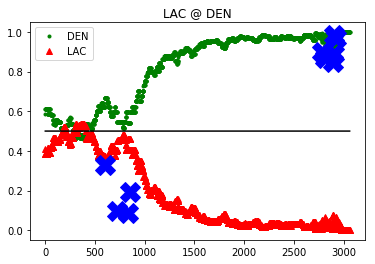

Game important plays: 
Top turning point descriptions: 
With 142.0 seconds left in quarter 4: Williams 26' 3PT Pullup Jump Shot (21 PTS) (Beverley 9 AST)
With 416.0 seconds left in quarter 4: Williams  3PT Fadeaway Jumper (18 PTS) (Beverley 8 AST)
With 272.0 seconds left in quarter 4: Burks Free Throw 1 of 1 (16 PTS)
With 398.0 seconds left in quarter 3: Green 26' 3PT Jump Shot (6 PTS) (Burks 4 AST)
With 214.0 seconds left in quarter 4: CLIPPERS Timeout: Regular (Full 5 Short 0)
With 364.0 seconds left in quarter 2: Smailagic 1' Tip Layup Shot (2 PTS)
With 583.0 seconds left in quarter 3: Shamet 25' 3PT Step Back Jump Shot (3 PTS) (Zubac 1 AST)
With 527.0 seconds left in quarter 4: Harrell 2' Cutting Layup Shot (8 PTS) (Beverley 7 AST)
With 572.0 seconds left in quarter 4: Paschall 1' Cutting Layup Shot (10 PTS) (Robinson III 4 AST)
With 163.0 seconds left in quarter 2: Spellman 25' 3PT Jump Shot (11 PTS) (Bowman 3 AST)
Done


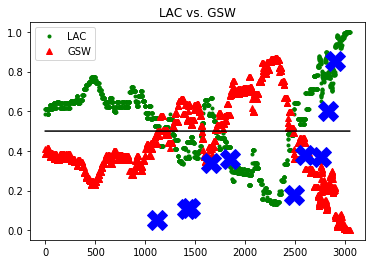

Game important plays: 
Top turning point descriptions: 
With 237.0 seconds left in quarter 4: Barrett 1' Tip Layup Shot (22 PTS)
With 290.0 seconds left in quarter 4: SUB: Harkless FOR Robinson
With 196.0 seconds left in quarter 4: Williams REBOUND (Off:1 Def:1)
With 79.0 seconds left in quarter 4: MISS Ntilikina Free Throw 1 of 1
With 93.0 seconds left in quarter 1: Harrell 1' Tip Layup Shot (4 PTS)
With 77.0 seconds left in quarter 4: Harkless REBOUND (Off:2 Def:4)
With 436.0 seconds left in quarter 2: Williams 25' 3PT Running Pull-Up Jump Shot (10 PTS)
With 175.0 seconds left in quarter 1: Green 1' Putback Layup (2 PTS)
With 408.0 seconds left in quarter 2: George 26' 3PT Running Pull-Up Jump Shot (15 PTS) (Beverley 2 AST)
With 677.0 seconds left in quarter 3: George 25' 3PT Jump Shot (24 PTS)
Done


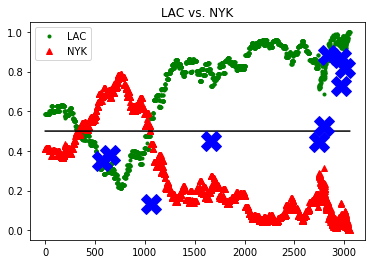

Game important plays: 
Top turning point descriptions: 
With 329.0 seconds left in quarter 2: Jackson Jr. 26' 3PT Jump Shot (10 PTS) (Crowder 5 AST)
With 345.0 seconds left in quarter 2: Grizzlies Timeout: Regular (Reg.3 Short 0)
With 94.0 seconds left in quarter 2: Crowder REBOUND (Off:2 Def:2)
With 464.0 seconds left in quarter 2: Allen  3PT Running Jump Shot (5 PTS) (Morant 3 AST)
With 491.0 seconds left in quarter 2: Brooks 26' 3PT Jump Shot (14 PTS) (Valanciunas 2 AST)
With 647.0 seconds left in quarter 2: Morant 27' 3PT Step Back Jump Shot (8 PTS) (S. Hill 2 AST)
With 72.0 seconds left in quarter 2: Morant 2' Driving Floating Jump Shot (12 PTS)
With 292.0 seconds left in quarter 1: Brooks 26' 3PT Running Pull-Up Jump Shot (8 PTS)
With 698.0 seconds left in quarter 3: Valanciunas 20' Jump Shot (2 PTS) (Morant 4 AST)
With 276.0 seconds left in quarter 1: Jackson Jr. 25' 3PT Jump Shot (7 PTS) (Jones 2 AST)
Done


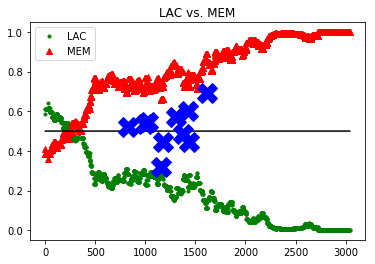

Game important plays: 
Top turning point descriptions: 
With 457.0 seconds left in quarter 2: George 25' 3PT Jump Shot (12 PTS) (Shamet 2 AST)
With 478.0 seconds left in quarter 2: George 28' 3PT Running Pull-Up Jump Shot (9 PTS)
With 364.0 seconds left in quarter 2: Snell S.FOUL (P1.T4) (J.Goble)
With 23.0 seconds left in quarter 2: CLIPPERS Timeout: Regular (Full 2 Short 0)
With 31.0 seconds left in quarter 2: Williams 25' 3PT Pullup Jump Shot (13 PTS)
With 347.0 seconds left in quarter 2: Leonard S.FOUL (P1.T3) (J.Goble)
With 116.0 seconds left in quarter 1: Williams 25' 3PT Jump Shot (3 PTS) (Green 2 AST)
With 214.0 seconds left in quarter 2: Williams 14' Fadeaway Jumper (10 PTS) (Zubac 1 AST)
With 188.0 seconds left in quarter 2: Harkless 1' Running Dunk (4 PTS)
With 273.0 seconds left in quarter 2: Leonard 10' Running Pull-Up Jump Shot (10 PTS)
Done


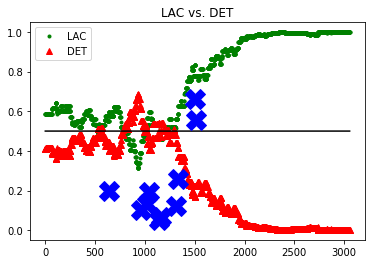

Game important plays: 
Top turning point descriptions: 
With 437.0 seconds left in quarter 2: George 6' Floating Jump Shot (8 PTS)
With 625.0 seconds left in quarter 2: Green 25' 3PT Jump Shot (3 PTS) (George 5 AST)
With 366.0 seconds left in quarter 2: George 25' 3PT Jump Shot (11 PTS)
With 274.0 seconds left in quarter 2: Zubac REBOUND (Off:3 Def:2)
With 236.0 seconds left in quarter 1: Hield 25' 3PT Jump Shot (5 PTS) (Bogdanovic 1 AST)
With 200.0 seconds left in quarter 2: Leonard 25' 3PT Jump Shot (8 PTS) (George 6 AST)
With 48.0 seconds left in quarter 2: Shamet 24' 3PT Jump Shot (6 PTS) (Leonard 5 AST)
With 612.0 seconds left in quarter 3: Shamet  3PT Jump Shot (9 PTS) (George 7 AST)
With 446.0 seconds left in quarter 3: Harkless 1' Putback Dunk (12 PTS)
With 646.0 seconds left in quarter 2: George 1' Driving Layup (4 PTS)
Done


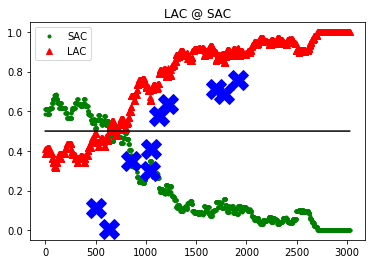

Game important plays: 
Top turning point descriptions: 
With 215.0 seconds left in quarter 4: Zubac Free Throw 2 of 2 (15 PTS)
With 194.0 seconds left in quarter 4: Mitchell 15' Pullup Jump Shot (26 PTS) (Ingles 7 AST)
With 142.0 seconds left in quarter 4: Bogdanovic 26' 3PT Running Pull-Up Jump Shot (15 PTS) (Ingles 8 AST)
With 254.0 seconds left in quarter 3: Ingles 26' 3PT Pullup Jump Shot (15 PTS)
With 567.0 seconds left in quarter 3: Ingles 26' 3PT Step Back Jump Shot (12 PTS)
With 429.0 seconds left in quarter 3: Mitchell 26' 3PT Jump Shot (15 PTS) (Bogdanovic 2 AST)
With 412.0 seconds left in quarter 4: Bogdanovic 10' Floating Jump Shot (12 PTS) (Clarkson 2 AST)
With 295.0 seconds left in quarter 4: Clarkson 1' Running Finger Roll Layup (19 PTS) (Bogdanovic 3 AST)
With 707.0 seconds left in quarter 3: George 24' 3PT Jump Shot (11 PTS) (Leonard 4 AST)
With 0.0 seconds left in quarter 2: MISS George 54' 3PT Running Jump Shot
Done


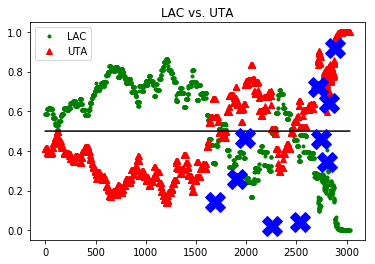

Game important plays: 
Top turning point descriptions: 
With 271.0 seconds left in quarter 4: Harrell 1' Tip Layup Shot (18 PTS)
With 178.0 seconds left in quarter 4: Harrell REBOUND (Off:3 Def:2)
With 84.0 seconds left in quarter 4: Harrell REBOUND (Off:4 Def:2)
With 314.0 seconds left in quarter 4: LAKERS Timeout: Regular (Full 5 Short 0)
With 544.0 seconds left in quarter 4: James 27' 3PT Pullup Jump Shot (17 PTS)
With 168.0 seconds left in quarter 4: Beverley REBOUND (Off:1 Def:7)
With 41.0 seconds left in quarter 4: MISS James Free Throw 2 of 2
With 428.0 seconds left in quarter 4: James 27' 3PT Jump Shot (20 PTS) (Caldwell-Pope 2 AST)
With 123.0 seconds left in quarter 4: Leonard Free Throw 1 of 2 (34 PTS)
With 510.0 seconds left in quarter 4: Caldwell-Pope 28' 3PT Jump Shot (13 PTS) (Rondo 5 AST)
Done


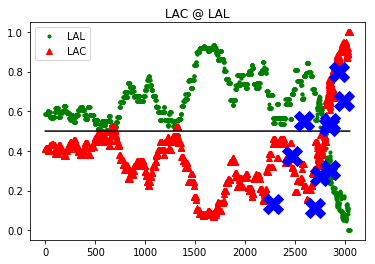

Game important plays: 
Top turning point descriptions: 
With 215.0 seconds left in quarter 4: Clippers Timeout: Regular (Reg.5 Short 0)
With 107.0 seconds left in quarter 4: Schroder 25' 3PT Jump Shot (22 PTS) (Paul 6 AST)
With 0.0 seconds left in quarter 3: End of 3rd Period (8:52 PM EST)
With 206.0 seconds left in quarter 3: Shamet 27' 3PT Running Pull-Up Jump Shot (5 PTS)
With 87.0 seconds left in quarter 4: Williams Bad Pass Turnover (P3.T16)#@#Adams STEAL (3 STL)
With 369.0 seconds left in quarter 4: Noel 1' Tip Dunk Shot (8 PTS)
With 650.0 seconds left in quarter 3: Bazley 1' Tip Dunk Shot (7 PTS)
With 146.0 seconds left in quarter 3: McGruder 25' 3PT Jump Shot (6 PTS) (Walton Jr. 1 AST)
With 683.0 seconds left in quarter 3: Patterson  3PT Jump Shot (10 PTS) (Williams 7 AST)
With 79.0 seconds left in quarter 4: Adams 2' Cutting Layup Shot (20 PTS) (Schroder 6 AST)
Done


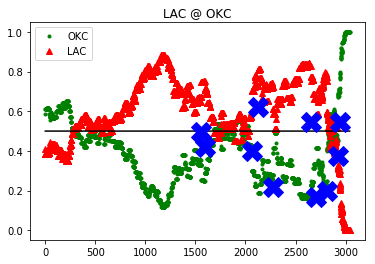

Game important plays: 
Top turning point descriptions: 
With 280.0 seconds left in quarter 2: Beverley  3PT Jump Shot (6 PTS) (Leonard 3 AST)
With 422.0 seconds left in quarter 2: Williams 25' 3PT Pullup Jump Shot (12 PTS) (Beverley 5 AST)
With 325.0 seconds left in quarter 2: Leonard Free Throw Flagrant 1 of 2 (11 PTS)
With 548.0 seconds left in quarter 2: SPURS Timeout: Regular (Full 3 Short 0)
With 441.0 seconds left in quarter 2: Harkless  3PT Jump Shot (6 PTS) (Beverley 4 AST)
With 589.0 seconds left in quarter 2: Gay 25' 3PT Jump Shot (3 PTS) (Poeltl 3 AST)
With 642.0 seconds left in quarter 2: Mills 26' 3PT Jump Shot (8 PTS) (Poeltl 2 AST)
With 325.0 seconds left in quarter 2: SUB: Beverley FOR Williams
With 70.0 seconds left in quarter 2: Williams 4' Driving Floating Jump Shot (14 PTS)
With 121.0 seconds left in quarter 2: Harkless 1' Dunk (8 PTS) (Leonard 4 AST)
Done


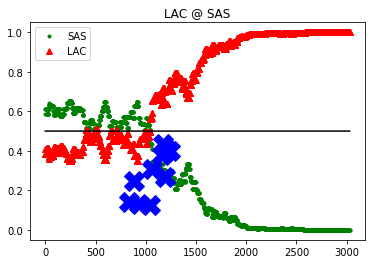

Game important plays: 
Top turning point descriptions: 
With 191.0 seconds left in quarter 4: Harden 28' 3PT Step Back Jump Shot (26 PTS)
With 339.0 seconds left in quarter 4: George 26' 3PT Jump Shot (30 PTS) (Beverley 7 AST)
With 129.0 seconds left in quarter 4: Leonard Bad Pass Turnover (P5.T18)#@#Tucker STEAL (1 STL)
With 172.0 seconds left in quarter 4: Tucker Free Throw 1 of 2 (9 PTS)
With 255.0 seconds left in quarter 3: Shamet  3PT Jump Shot (6 PTS) (Leonard 3 AST)
With 373.0 seconds left in quarter 4: Harrell 1' Layup (19 PTS) (Shamet 2 AST)
With 269.0 seconds left in quarter 4: Leonard 2' Driving Layup (25 PTS)
With 478.0 seconds left in quarter 2: Capela 1' Tip Dunk Shot (6 PTS)
With 152.0 seconds left in quarter 4: Tucker REBOUND (Off:1 Def:9)
With 177.0 seconds left in quarter 4: Harrell Lost Ball Turnover (P5.T17)#@#House Jr. STEAL (1 STL)
Done


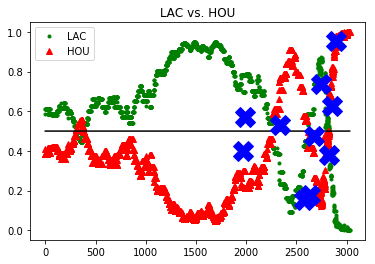

Game important plays: 
Top turning point descriptions: 
With 102.0 seconds left in quarter 2: Ayton 1' Tip Layup Shot (10 PTS)
With 446.0 seconds left in quarter 2: CLIPPERS Timeout: Regular (Full 2 Short 0)
With 290.0 seconds left in quarter 2: Zubac Free Throw 1 of 2 (6 PTS)
With 53.0 seconds left in quarter 1: Patterson 27' 3PT Pullup Jump Shot (3 PTS) (Harrell 1 AST)
With 534.0 seconds left in quarter 2: Williams 24' 3PT Jump Shot (3 PTS)
With 32.0 seconds left in quarter 1: Patterson 26' 3PT Running Jump Shot (6 PTS) (Williams 2 AST)
With 363.0 seconds left in quarter 1: Zubac REBOUND (Off:1 Def:1)
With 510.0 seconds left in quarter 3: Beverley 2' Floating Jump Shot (9 PTS)
With 591.0 seconds left in quarter 3: Beverley 6' Turnaround Hook Shot (7 PTS)
With 380.0 seconds left in quarter 2: George 20' Step Back Jump Shot (12 PTS)
Done


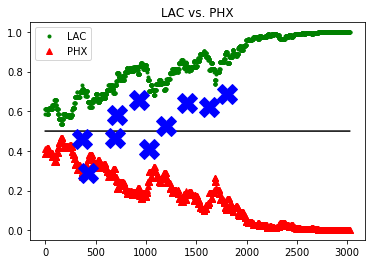

Game important plays: 
Top turning point descriptions: 
With 48.0 seconds left in quarter 4: Clippers Timeout: Regular (Reg.6 Short 0)
With 2.0 seconds left in quarter 4: LaVine 1' Driving Layup (30 PTS) (Dunn 4 AST)
With 152.0 seconds left in quarter 4: Shamet 25' 3PT Jump Shot (11 PTS) (George 6 AST)
With 269.0 seconds left in quarter 4: Clippers Timeout: Regular (Reg.4 Short 0)
With 32.0 seconds left in quarter 3: LaVine 25' 3PT Jump Shot (22 PTS) (Young 3 AST)
With 66.0 seconds left in quarter 3: Valentine 25' 3PT Jump Shot (6 PTS) (Satoransky 5 AST)
With 668.0 seconds left in quarter 4: Valentine 26' 3PT Pullup Jump Shot (9 PTS)
With 105.0 seconds left in quarter 4: George 5' Fadeaway Jumper (26 PTS)
With 529.0 seconds left in quarter 3: LaVine  3PT Step Back Jump Shot (17 PTS)
With 556.0 seconds left in quarter 4: Valentine Free Throw 1 of 2 (13 PTS)
Done


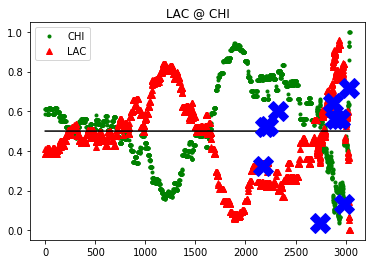

Game important plays: 
Top turning point descriptions: 
With 84.0 seconds left in quarter 4: Wiggins Traveling Turnover (P4.T17)
With 317.0 seconds left in quarter 2: Towns 1' Tip Layup Shot (13 PTS)
With 184.0 seconds left in quarter 4: George 2' Driving Layup (44 PTS) (Leonard 2 AST)
With 295.0 seconds left in quarter 4: Towns Free Throw 1 of 1 (38 PTS)
With 225.0 seconds left in quarter 2: Towns 25' 3PT Step Back Jump Shot (18 PTS)
With 75.0 seconds left in quarter 4: George Offensive Foul Turnover (P6.T19)
With 675.0 seconds left in quarter 3: George 27' 3PT Jump Shot (26 PTS) (Mann 2 AST)
With 66.0 seconds left in quarter 2: Leonard Free Throw 1 of 2 (31 PTS)
With 640.0 seconds left in quarter 2: George 26' 3PT Jump Shot (15 PTS) (Walton Jr. 1 AST)
With 81.0 seconds left in quarter 1: Wiggins Out of Bounds Lost Ball Turnover (P1.T2)
Done


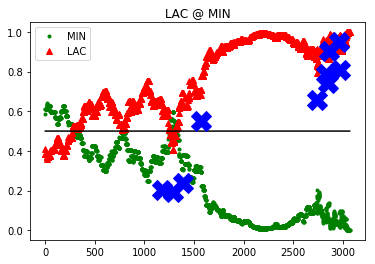

Game important plays: 
Top turning point descriptions: 
With 213.0 seconds left in quarter 2: Beverley  3PT Jump Shot (11 PTS) (Leonard 2 AST)
With 169.0 seconds left in quarter 2: Williams 24' 3PT Jump Shot (10 PTS) (George 2 AST)
With 100.0 seconds left in quarter 3: Leonard 27' 3PT Pullup Jump Shot (16 PTS) (Harrell 3 AST)
With 207.0 seconds left in quarter 3: George 11' Fadeaway Jumper (8 PTS) (Leonard 4 AST)
With 223.0 seconds left in quarter 3: Clippers Timeout: Regular (Reg.3 Short 0)
With 561.0 seconds left in quarter 2: Hollis-Jefferson REBOUND (Off:2 Def:2)
With 274.0 seconds left in quarter 3: Patterson 12' Jump Bank Shot (4 PTS) (Leonard 3 AST)
With 181.0 seconds left in quarter 3: Harrell 1' Cutting Dunk Shot (10 PTS) (Williams 6 AST)
With 169.0 seconds left in quarter 1: Gasol REBOUND (Off:1 Def:0)
With 464.0 seconds left in quarter 3: Zubac REBOUND (Off:4 Def:4)
Done


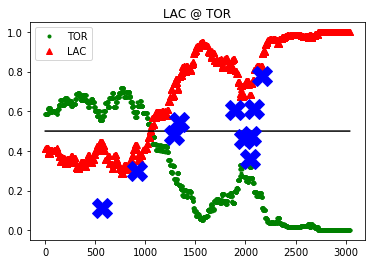

Game important plays: 
Top turning point descriptions: 
With 87.0 seconds left in quarter 2: George  3PT Jump Shot (18 PTS) (Harrell 1 AST)
With 62.0 seconds left in quarter 2: George 26' 3PT Pullup Jump Shot (21 PTS)
With 227.0 seconds left in quarter 1: Harrell 1' Tip Layup Shot (4 PTS)
With 469.0 seconds left in quarter 2: McDermott 27' 3PT Jump Shot (8 PTS) (Holiday 1 AST)
With 439.0 seconds left in quarter 1: Zubac 1' Tip Dunk Shot (2 PTS)
With 512.0 seconds left in quarter 1: Beverley Inbound Turnover (P2.T3)
With 1.0 seconds left in quarter 2: Zubac REBOUND (Off:3 Def:4)
With 130.0 seconds left in quarter 2: George Free Throw 2 of 3 (14 PTS)
With 634.0 seconds left in quarter 3: Patterson 25' 3PT Jump Shot (5 PTS) (Beverley 1 AST)
With 279.0 seconds left in quarter 2: Williams 17' Fadeaway Jumper (6 PTS) (Zubac 1 AST)
Done


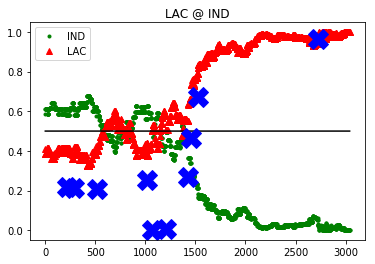

Game important plays: 
Top turning point descriptions: 
With 393.0 seconds left in quarter 4: Clippers Timeout: Regular (Reg.4 Short 0)
With 601.0 seconds left in quarter 4: Walton Jr.  3PT Jump Shot (5 PTS) (George 5 AST)
With 618.0 seconds left in quarter 3: Harkless  3PT Jump Shot (6 PTS) (George 4 AST)
With 671.0 seconds left in quarter 2: Mahinmi 1' Tip Dunk Shot (4 PTS)
With 376.0 seconds left in quarter 4: Harrell 2' Layup (13 PTS)
With 68.0 seconds left in quarter 3: Harrell 4' Driving Layup (11 PTS) (Williams 3 AST)
With 422.0 seconds left in quarter 2: Bertans 26' 3PT Jump Shot (14 PTS) (Hachimura 1 AST)
With 549.0 seconds left in quarter 4: George 26' 3PT Jump Shot (24 PTS) (Williams 4 AST)
With 137.0 seconds left in quarter 1: Mahinmi 1' Tip Layup Shot (2 PTS)
With 386.0 seconds left in quarter 2: Brown Jr. 26' 3PT Jump Shot (10 PTS) (Hachimura 2 AST)
Done


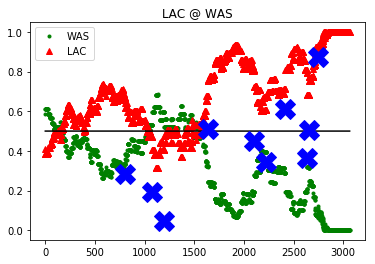

Game important plays: 
Top turning point descriptions: 
With 392.0 seconds left in quarter 1: Harkless Out of Bounds - Bad Pass Turnover Turnover (P1.T3)
With 629.0 seconds left in quarter 3: Matthews 26' 3PT Jump Shot (9 PTS) (Bledsoe 4 AST)
With 473.0 seconds left in quarter 2: Matthews 27' 3PT Jump Shot (3 PTS) (Middleton 1 AST)
With 375.0 seconds left in quarter 2: Matthews 24' 3PT Running Jump Shot (6 PTS) (Bledsoe 3 AST)
With 278.0 seconds left in quarter 1: Bledsoe 26' 3PT Pullup Jump Shot (5 PTS)
With 306.0 seconds left in quarter 1: Connaughton 26' 3PT Jump Shot (3 PTS) (Matthews 1 AST)
With 467.0 seconds left in quarter 3: Antetokounmpo 26' 3PT Jump Shot (20 PTS)
With 658.0 seconds left in quarter 2: BUCKS Timeout: Regular (Full 2 Short 0)
With 255.0 seconds left in quarter 1: Connaughton 27' 3PT Jump Shot (6 PTS) (Bledsoe 1 AST)
With 223.0 seconds left in quarter 1: Ilyasova 26' 3PT Step Back Jump Shot (3 PTS) (Bledsoe 2 AST)
Done


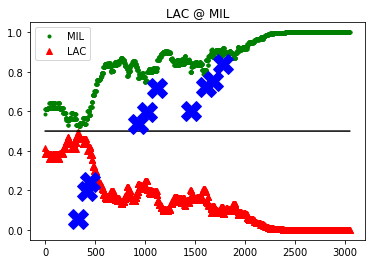

Game important plays: 
Top turning point descriptions: 
With 62.0 seconds left in quarter 2: Hood 1' Tip Layup Shot (4 PTS)
With 646.0 seconds left in quarter 3: George 27' 3PT Step Back Jump Shot (18 PTS) (Beverley 3 AST)
With 640.0 seconds left in quarter 1: George REBOUND (Off:0 Def:1)
With 607.0 seconds left in quarter 1: Lillard Bad Pass Turnover (P1.T1)#@#Leonard STEAL (1 STL)
With 582.0 seconds left in quarter 1: George REBOUND (Off:0 Def:2)
With 483.0 seconds left in quarter 1: George 26' 3PT Jump Shot (8 PTS) (Leonard 3 AST)
With 508.0 seconds left in quarter 1: Beverley 25' 3PT Jump Shot (5 PTS) (Leonard 2 AST)
With 388.0 seconds left in quarter 1: Anthony Free Throw 2 of 2 (2 PTS)
With 467.0 seconds left in quarter 1: Zubac REBOUND (Off:0 Def:1)
With 435.0 seconds left in quarter 1: George REBOUND (Off:0 Def:3)
Done


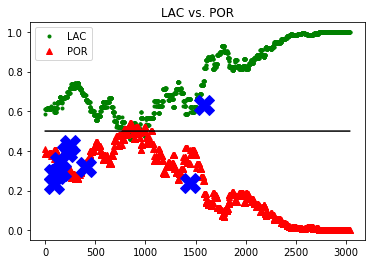

Game important plays: 
Top turning point descriptions: 
With 427.0 seconds left in quarter 1: Beal Step Out of Bounds Turnover (P2.T3)
With 79.0 seconds left in quarter 1: Williams 27' 3PT Jump Shot (5 PTS) (Robinson 1 AST)
With 106.0 seconds left in quarter 1: George 27' 3PT Pullup Jump Shot (15 PTS)
With 655.0 seconds left in quarter 2: Harrell REBOUND (Off:2 Def:2)
With 234.0 seconds left in quarter 1: Harkless REBOUND (Off:1 Def:0)
With 641.0 seconds left in quarter 1: Beal Free Throw 1 of 1 (3 PTS)
With 635.0 seconds left in quarter 2: Green 25' 3PT Jump Shot (3 PTS) (Williams 3 AST)
With 212.0 seconds left in quarter 1: Beverley 25' 3PT Running Pull-Up Jump Shot (3 PTS)
With 549.0 seconds left in quarter 2: SUB: Beal FOR Bonga
With 684.0 seconds left in quarter 1: Leonard REBOUND (Off:0 Def:1)
Done


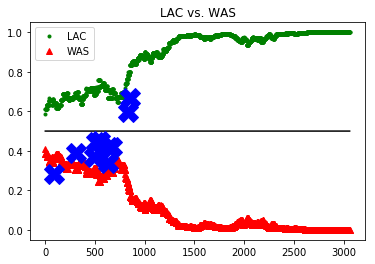

Game important plays: 
Top turning point descriptions: 
With 383.0 seconds left in quarter 3: White 25' 3PT Jump Shot (14 PTS) (DeRozan 4 AST)
With 682.0 seconds left in quarter 2: Belinelli 25' 3PT Pullup Jump Shot (3 PTS)
With 149.0 seconds left in quarter 1: Green 25' 3PT Jump Shot (6 PTS) (Williams 4 AST)
With 420.0 seconds left in quarter 2: Belinelli 1' Cutting Finger Roll Layup Shot (5 PTS) (Aldridge 4 AST)
With 176.0 seconds left in quarter 1: Beverley 24' 3PT Jump Shot (5 PTS) (Williams 3 AST)
With 498.0 seconds left in quarter 2: SPURS Timeout: Regular (Full 2 Short 0)
With 466.0 seconds left in quarter 1: White 27' 3PT Jump Shot (5 PTS) (Aldridge 1 AST)
With 385.0 seconds left in quarter 2: Aldridge 11' Driving Floating Jump Shot (4 PTS)
With 662.0 seconds left in quarter 2: Lyles 1' Cutting Dunk Shot (5 PTS) (Belinelli 1 AST)
With 405.0 seconds left in quarter 2: SUB: Murray FOR White
Done


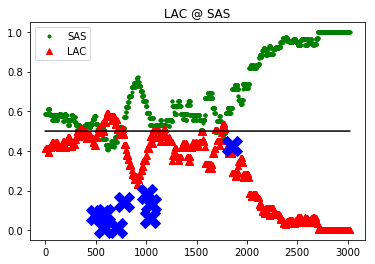

Game important plays: 
Top turning point descriptions: 
With 174.0 seconds left in quarter 2: McGruder 26' 3PT Jump Shot (5 PTS) (Beverley 7 AST)
With 359.0 seconds left in quarter 2: S. Hill  3PT Jump Shot (3 PTS) (Jones 2 AST)
With 205.0 seconds left in quarter 2: Green 1' Running Layup (5 PTS) (Beverley 6 AST)
With 31.0 seconds left in quarter 1: Williams 26' 3PT Pullup Jump Shot (7 PTS)
With 115.0 seconds left in quarter 2: Brooks 1' Running Finger Roll Layup (4 PTS) (Morant 7 AST)
With 159.0 seconds left in quarter 2: Delay Of Game
With 319.0 seconds left in quarter 1: Valanciunas REBOUND (Off:1 Def:2)
With 242.0 seconds left in quarter 1: Jackson Jr. 26' 3PT Running Jump Shot (10 PTS) (Allen 1 AST)
With 201.0 seconds left in quarter 1: Harrell Free Throw 1 of 1 (3 PTS)
With 38.0 seconds left in quarter 1: Guduric Free Throw 2 of 2 (4 PTS)
Done


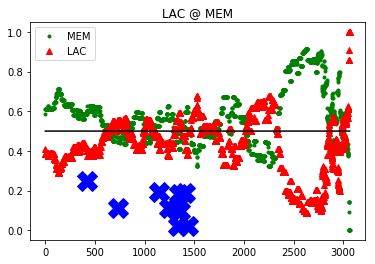

Game important plays: 
Top turning point descriptions: 
With 222.0 seconds left in quarter 2: Williams 25' 3PT Pullup Jump Shot (12 PTS)
With 1.0 seconds left in quarter 1: Williams 24' 3PT Pullup Jump Shot (3 PTS)
With 33.0 seconds left in quarter 1: Green 24' 3PT Jump Shot (3 PTS) (Williams 1 AST)
With 579.0 seconds left in quarter 2: Williams 25' 3PT Jump Shot (7 PTS) (McGruder 1 AST)
With 505.0 seconds left in quarter 2: Harrell REBOUND (Off:1 Def:1)
With 331.0 seconds left in quarter 1: Hardaway Jr.  3PT Jump Shot (3 PTS) (Doncic 3 AST)
With 451.0 seconds left in quarter 2: Curry Out of Bounds Lost Ball Turnover (P1.T8)
With 261.0 seconds left in quarter 2: Williams 15' Pullup Jump Shot (9 PTS)
With 463.0 seconds left in quarter 1: Powell 26' 3PT Jump Shot (5 PTS) (Doncic 2 AST)
With 7.0 seconds left in quarter 2: Leonard 25' 3PT Jump Shot (13 PTS)
Done


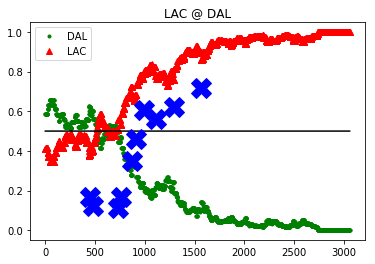

Game important plays: 
Top turning point descriptions: 
With 406.0 seconds left in quarter 3: CLIPPERS Timeout: Regular (Full 3 Short 0)
With 81.0 seconds left in quarter 2: Moore 26' 3PT Jump Shot (9 PTS) (Ingram 2 AST)
With 434.0 seconds left in quarter 3: George 26' 3PT Jump Shot (18 PTS) (Beverley 4 AST)
With 241.0 seconds left in quarter 3: Harrell 1' Cutting Layup Shot (12 PTS) (Leonard 6 AST)
With 349.0 seconds left in quarter 3: Leonard 21' Step Back Jump Shot (22 PTS)
With 267.0 seconds left in quarter 1: George 27' 3PT Jump Shot (6 PTS) (Beverley 2 AST)
With 538.0 seconds left in quarter 2: Leonard 25' 3PT Jump Shot (10 PTS) (McGruder 2 AST)
With 241.0 seconds left in quarter 1: Beverley 24' 3PT Jump Shot (5 PTS) (George 1 AST)
With 616.0 seconds left in quarter 3: George 25' 3PT Jump Shot (15 PTS) (Beverley 3 AST)
With 61.0 seconds left in quarter 1: McGruder 24' 3PT Jump Shot (3 PTS) (Williams 1 AST)
Done


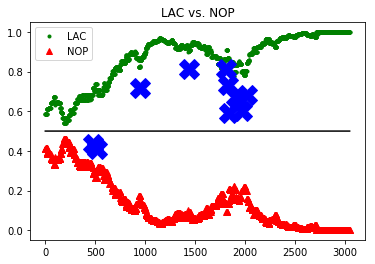

Game important plays: 
Top turning point descriptions: 
With 30.0 seconds left in quarter 4: Rockets Timeout: Regular (Reg.6 Short 0)
With 1.0 seconds left in quarter 4: George REBOUND (Off:0 Def:8)
With 117.0 seconds left in quarter 4: Harden 28' 3PT Step Back Jump Shot (35 PTS)
With 322.0 seconds left in quarter 4: Green 1' Tip Layup Shot (4 PTS)
With 22.0 seconds left in quarter 4: Harden Free Throw 2 of 2 (37 PTS)
With 262.0 seconds left in quarter 4: Harrell Free Throw 2 of 2 (16 PTS)
With 221.0 seconds left in quarter 3: Harden 27' 3PT Step Back Jump Shot (27 PTS)
With 261.0 seconds left in quarter 3: Rockets Timeout: Regular (Reg.3 Short 0)
With 531.0 seconds left in quarter 3: Harden 28' 3PT Running Pull-Up Jump Shot (23 PTS) (Westbrook 3 AST)
With 281.0 seconds left in quarter 4: Capela 1' Running Alley Oop Layup Shot (14 PTS) (Harden 12 AST)
Done


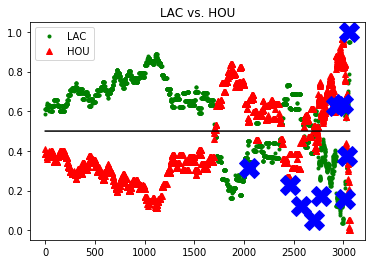

Game important plays: 
Top turning point descriptions: 
With 13.0 seconds left in quarter 4: CLIPPERS Timeout: Regular (Full 6 Short 0)
With 21.0 seconds left in quarter 4: Walker Lost Ball Turnover (P6.T16)#@#Williams STEAL (2 STL)
With 58.0 seconds left in quarter 4: Theis REBOUND (Off:7 Def:6)
With 203.0 seconds left in quarter 5: Beverley  3PT Jump Shot (11 PTS) (George 8 AST)
With 32.0 seconds left in quarter 3: Wanamaker 27' 3PT Pullup Jump Shot (12 PTS)
With 61.0 seconds left in quarter 5: Harrell REBOUND (Off:2 Def:4)
With 20.0 seconds left in quarter 4: Williams Free Throw 1 of 2 (26 PTS)
With 92.0 seconds left in quarter 5: Beverley REBOUND (Off:4 Def:12)
With 625.0 seconds left in quarter 4: Brown 28' 3PT Jump Shot (7 PTS) (Wanamaker 2 AST)
With 43.0 seconds left in quarter 5: Beverley  3PT Jump Shot (14 PTS) (Harrell 3 AST)
Done


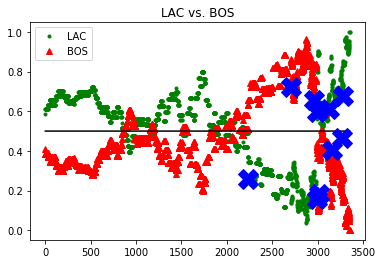

Game important plays: 
Top turning point descriptions: 
With 25.0 seconds left in quarter 4: Thunder Timeout: Regular (Reg.6 Short 0)
With 1.0 seconds left in quarter 4: George REBOUND (Off:0 Def:7)
With 31.0 seconds left in quarter 4: Paul Free Throw 1 of 2 (21 PTS)
With 200.0 seconds left in quarter 4: Beverley REBOUND (Off:0 Def:4)
With 73.0 seconds left in quarter 4: Schroder Lost Ball Turnover (P4.T17)#@#Beverley STEAL (3 STL)
With 226.0 seconds left in quarter 3: Harrell 1' Tip Layup Shot (14 PTS)
With 387.0 seconds left in quarter 4: George  3PT Jump Shot (14 PTS) (Harrell 4 AST)
With 282.0 seconds left in quarter 3: Nader  3PT Jump Shot (6 PTS) (Schroder 1 AST)
With 60.0 seconds left in quarter 3: Green 32' 3PT Jump Shot (3 PTS) (Harrell 3 AST)
With 105.0 seconds left in quarter 4: SUB: Ferguson FOR Gilgeous-Alexander
Done


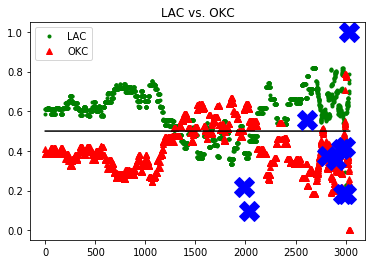

Game important plays: 
Top turning point descriptions: 
With 359.0 seconds left in quarter 2: George Free Throw 1 of 2 (19 PTS)
With 291.0 seconds left in quarter 2: George 24' 3PT Jump Shot (22 PTS) (Mann 3 AST)
With 263.0 seconds left in quarter 2: George 25' 3PT Pullup Jump Shot (25 PTS) (Zubac 2 AST)
With 535.0 seconds left in quarter 3: George 25' 3PT Jump Shot (31 PTS) (Mann 4 AST)
With 464.0 seconds left in quarter 1: George REBOUND (Off:1 Def:0)
With 433.0 seconds left in quarter 2: Harrell  Driving Dunk (7 PTS) (George 2 AST)
With 312.0 seconds left in quarter 2: Parker Out of Bounds - Bad Pass Turnover Turnover (P2.T8)
With 208.0 seconds left in quarter 1: Robinson 24' 3PT Jump Shot (3 PTS) (Williams 2 AST)
With 588.0 seconds left in quarter 1: Harkless REBOUND (Off:1 Def:1)
With 6.0 seconds left in quarter 1: Bembry Out of Bounds - Bad Pass Turnover Turnover (P1.T4)
Done


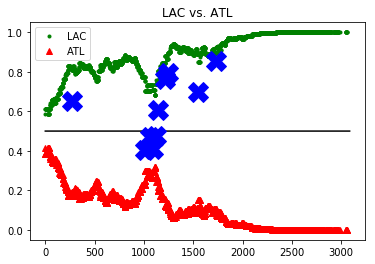

Game important plays: 
Top turning point descriptions: 
With 521.0 seconds left in quarter 2: Favors 1' Tip Layup Shot (7 PTS)
With 470.0 seconds left in quarter 2: Moore 25' 3PT Pullup Jump Shot (8 PTS)
With 407.0 seconds left in quarter 2: Holiday 26' 3PT Pullup Jump Shot (14 PTS)
With 321.0 seconds left in quarter 2: Holiday 26' 3PT Jump Shot (17 PTS)
With 228.0 seconds left in quarter 2: Holiday 25' 3PT Step Back Jump Shot (20 PTS)
With 201.0 seconds left in quarter 2: Redick 26' 3PT Jump Shot (10 PTS) (Jackson 2 AST)
With 103.0 seconds left in quarter 1: Jackson  3PT Jump Shot (5 PTS)
With 294.0 seconds left in quarter 1: Holiday REBOUND (Off:1 Def:0)
With 159.0 seconds left in quarter 1: Redick 25' 3PT Jump Shot (5 PTS) (Alexander-Walker 1 AST)
With 351.0 seconds left in quarter 1: Williams 26' 3PT Pullup Jump Shot (3 PTS)
Done


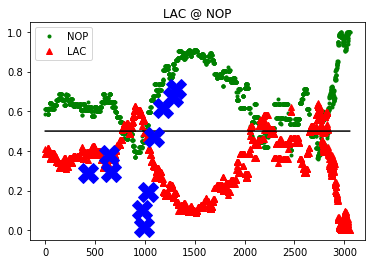

Game important plays: 
Top turning point descriptions: 
With 295.0 seconds left in quarter 1: Harden 25' 3PT Step Back Jump Shot (10 PTS)
With 272.0 seconds left in quarter 1: Harden 26' 3PT Step Back Jump Shot (13 PTS)
With 234.0 seconds left in quarter 1: McLemore 27' 3PT Jump Shot (3 PTS) (Harden 2 AST)
With 665.0 seconds left in quarter 1: Harkless Out of Bounds - Bad Pass Turnover Turnover (P1.T1)
With 562.0 seconds left in quarter 2: SUB: Clemons FOR McLemore
With 573.0 seconds left in quarter 1: Capela REBOUND (Off:0 Def:2)
With 639.0 seconds left in quarter 1: Harden REBOUND (Off:0 Def:1)
With 608.0 seconds left in quarter 1: Out-of-Bounds
With 592.0 seconds left in quarter 1: Capela REBOUND (Off:0 Def:1)
With 581.0 seconds left in quarter 2: Tucker  3PT Jump Shot (3 PTS) (McLemore 1 AST)
Done


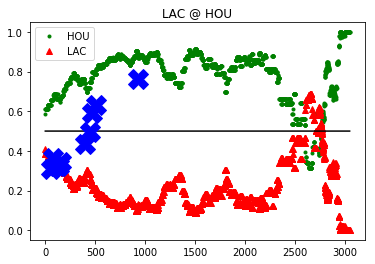

Game important plays: 
Top turning point descriptions: 
With 0.0 seconds left in quarter 2: Beverley Free Throw 1 of 2 (6 PTS)
With 274.0 seconds left in quarter 3: Patterson 24' 3PT Jump Shot (12 PTS) (Shamet 2 AST)
With 51.0 seconds left in quarter 3: Williams Out of Bounds Lost Ball Turnover (P2.T17)
With 81.0 seconds left in quarter 4: Raptors Timeout: Regular (Reg.6 Short 0)
With 90.0 seconds left in quarter 3: Harrell  Cutting Dunk Shot (10 PTS) (Williams 3 AST)
With 450.0 seconds left in quarter 4: Harrell 1' Cutting Dunk Shot (12 PTS) (Leonard 8 AST)
With 144.0 seconds left in quarter 3: Williams 15' Fadeaway Jumper (18 PTS)
With 2.0 seconds left in quarter 3: Thomas 17' Running Jump Shot (8 PTS) (VanVleet 7 AST)
With 245.0 seconds left in quarter 4: Leonard REBOUND (Off:2 Def:7)
With 367.0 seconds left in quarter 4: Leonard 13' Fadeaway Jumper (9 PTS) (Green 1 AST)
Done


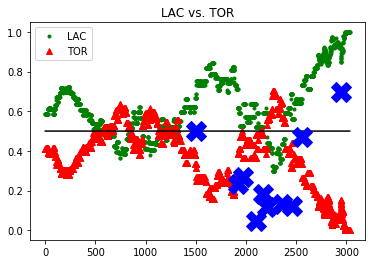

Game important plays: 
Top turning point descriptions: 
With 32.0 seconds left in quarter 4: Williams 26' 3PT Pullup Jump Shot (26 PTS)
With 190.0 seconds left in quarter 4: Trail Blazers Timeout: Regular (Reg.5 Short 0)
With 242.0 seconds left in quarter 4: Simons 25' 3PT Jump Shot (16 PTS) (Lillard 4 AST)
With 335.0 seconds left in quarter 4: Harrell 1' Tip Layup Shot (13 PTS)
With 567.0 seconds left in quarter 4: Simons 25' 3PT Jump Shot (8 PTS) (Labissiere 1 AST)
With 45.0 seconds left in quarter 4: Trail Blazers Rebound
With 501.0 seconds left in quarter 4: Simons 25' 3PT Running Pull-Up Jump Shot (11 PTS)
With 58.0 seconds left in quarter 4: Williams 13' Pullup Jump Shot (23 PTS)
With 45.0 seconds left in quarter 4: SUB: Hezonja FOR Whiteside
With 382.0 seconds left in quarter 3: Shamet 26' 3PT Jump Shot (8 PTS) (Patterson 1 AST)
Done


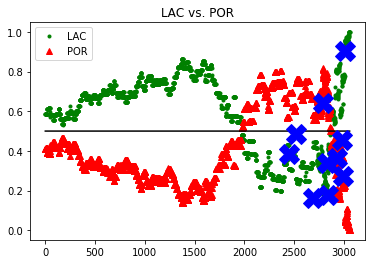

Game important plays: 
Top turning point descriptions: 
With 221.0 seconds left in quarter 3: G. Hill 24' 3PT Running Jump Shot (20 PTS) (Antetokounmpo 6 AST)
With 675.0 seconds left in quarter 4: Korver 26' 3PT Jump Shot (9 PTS) (Antetokounmpo 7 AST)
With 192.0 seconds left in quarter 3: Antetokounmpo 27' 3PT Pullup Jump Shot (25 PTS)
With 491.0 seconds left in quarter 4: Korver 27' 3PT Jump Shot (12 PTS) (Antetokounmpo 8 AST)
With 703.0 seconds left in quarter 4: Zubac 1' Tip Layup Shot (8 PTS)
With 10.0 seconds left in quarter 2: SUB: Harkless FOR Robinson
With 649.0 seconds left in quarter 2: Antetokounmpo 1' Tip Dunk Shot (6 PTS)
With 578.0 seconds left in quarter 3: Harrell 1' Putback Layup (18 PTS)
With 12.0 seconds left in quarter 4: Middleton Free Throw 1 of 2 (12 PTS)
With 30.0 seconds left in quarter 2: G. Hill 26' 3PT Running Pull-Up Jump Shot (17 PTS)
Done


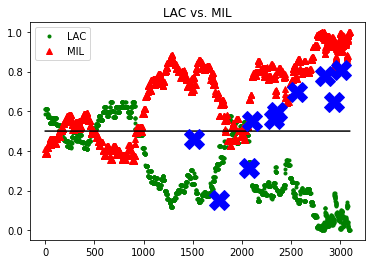

Game important plays: 
Top turning point descriptions: 
With 252.0 seconds left in quarter 4: Mitchell Free Throw 2 of 2 (32 PTS)
With 212.0 seconds left in quarter 4: Mitchell Free Throw 2 of 2 (34 PTS)
With 231.0 seconds left in quarter 4: Williams 26' 3PT Jump Shot (17 PTS) (Leonard 2 AST)
With 167.0 seconds left in quarter 4: Green 25' 3PT Jump Shot (10 PTS) (Leonard 3 AST)
With 449.0 seconds left in quarter 4: Leonard 25' 3PT Running Pull-Up Jump Shot (20 PTS)
With 147.0 seconds left in quarter 3: Ingles 27' 3PT Jump Shot (9 PTS) (Niang 1 AST)
With 467.0 seconds left in quarter 4: Green REBOUND (Off:3 Def:1)
With 581.0 seconds left in quarter 3: Mitchell 25' 3PT Jump Shot (17 PTS)
With 281.0 seconds left in quarter 4: Mitchell Free Throw 2 of 2 (30 PTS)
With 307.0 seconds left in quarter 3: Ingles 25' 3PT Step Back Jump Shot (6 PTS)
Done


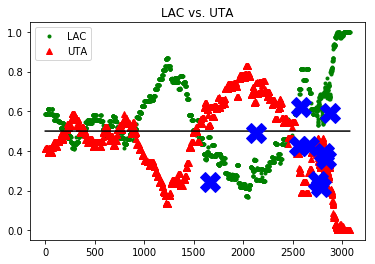

Game important plays: 
Top turning point descriptions: 
With 120.0 seconds left in quarter 4: DeRozan Free Throw 2 of 2 (29 PTS)
With 98.0 seconds left in quarter 4: DeRozan Lost Ball Turnover (P7.T18)#@#Leonard STEAL (4 STL)
With 434.0 seconds left in quarter 2: Shamet 25' 3PT Jump Shot (5 PTS) (Beverley 1 AST)
With 601.0 seconds left in quarter 3: Leonard 26' 3PT Jump Shot (16 PTS) (Patterson 2 AST)
With 258.0 seconds left in quarter 2: Williams  3PT Jump Shot (8 PTS) (Beverley 2 AST)
With 255.0 seconds left in quarter 4: DeRozan Offensive Charge Foul (P3.T3) (B.Taylor)
With 293.0 seconds left in quarter 4: SUB: Shamet FOR Harkless
With 370.0 seconds left in quarter 2: Beverley  3PT Jump Shot (4 PTS) (Shamet 1 AST)
With 248.0 seconds left in quarter 3: Harrell 4' Cutting Layup Shot (16 PTS) (Williams 4 AST)
With 87.0 seconds left in quarter 4: Harrell 1' Layup (22 PTS) (Beverley 5 AST)
Done


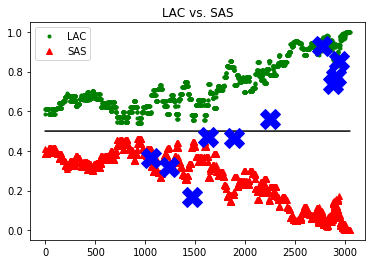

Game important plays: 
Top turning point descriptions: 
With 615.0 seconds left in quarter 3: Conley 24' 3PT Jump Shot (9 PTS) (Bogdanovic 1 AST)
With 513.0 seconds left in quarter 3: Conley 24' 3PT Pullup Jump Shot (14 PTS)
With 549.0 seconds left in quarter 3: Conley 13' Driving Floating Jump Shot (11 PTS)
With 578.0 seconds left in quarter 3: Mitchell 19' Pullup Jump Shot (14 PTS)
With 62.0 seconds left in quarter 2: Mitchell 18' Turnaround Jump Shot (10 PTS)
With 48.0 seconds left in quarter 1: Green  3PT Jump Shot (3 PTS) (Mudiay 2 AST)
With 124.0 seconds left in quarter 2: Conley 4' Driving Layup (6 PTS)
With 631.0 seconds left in quarter 2: Green 25' 3PT Jump Shot (6 PTS) (Mudiay 4 AST)
With 5.0 seconds left in quarter 1: Ingles 27' 3PT Jump Shot (3 PTS) (Mudiay 3 AST)
With 364.0 seconds left in quarter 1: Bogdanovic  3PT Step Back Jump Shot (5 PTS) (Ingles 1 AST)
Done


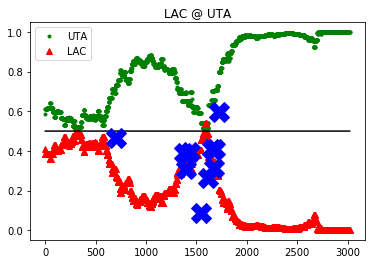

Game important plays: 
Top turning point descriptions: 
With 679.0 seconds left in quarter 3: Leonard 29' 3PT Jump Shot (18 PTS) (Shamet 2 AST)
With 49.0 seconds left in quarter 3: Williams 26' 3PT Jump Shot (19 PTS) (Harrell 1 AST)
With 613.0 seconds left in quarter 3: Patterson 26' 3PT Jump Shot (3 PTS) (Beverley 3 AST)
With 206.0 seconds left in quarter 3: Williams 32' 3PT Jump Shot (16 PTS) (Patterson 3 AST)
With 441.0 seconds left in quarter 3: Beverley 3' Driving Finger Roll Layup (5 PTS)
With 509.0 seconds left in quarter 1: Zeller 1' Tip Layup Shot (5 PTS)
With 692.0 seconds left in quarter 3: Rozier Out of Bounds - Bad Pass Turnover Turnover (P2.T12)
With 114.0 seconds left in quarter 2: Leonard 3' Driving Floating Jump Shot (14 PTS)
With 47.0 seconds left in quarter 2: Zubac 2' Layup (6 PTS) (Leonard 5 AST)
With 387.0 seconds left in quarter 3: Williams 22' Jump Shot (11 PTS)
Done


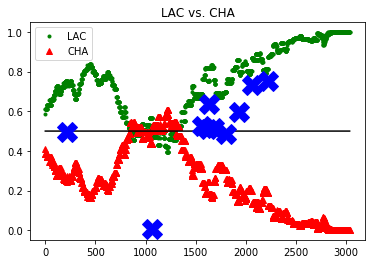

Game important plays: 
Top turning point descriptions: 
With 324.0 seconds left in quarter 3: Kaminsky 25' 3PT Jump Shot (13 PTS) (Booker 7 AST)
With 290.0 seconds left in quarter 3: Carter 25' 3PT Jump Shot (3 PTS) (Kaminsky 3 AST)
With 636.0 seconds left in quarter 3: Booker 25' 3PT Running Pull-Up Jump Shot (14 PTS)
With 501.0 seconds left in quarter 3: Saric 25' 3PT Jump Shot (13 PTS) (Carter 3 AST)
With 0.0 seconds left in quarter 3: Instant Replay3rd Period (12:04 AM EST)
With 93.0 seconds left in quarter 3: Johnson  3PT Jump Shot (4 PTS) (Carter 4 AST)
With 187.0 seconds left in quarter 2: Saric 26' 3PT Jump Shot (8 PTS) (Carter 2 AST)
With 673.0 seconds left in quarter 4: Kaminsky 1' Cutting Dunk Shot (17 PTS) (Okobo 1 AST)
With 186.0 seconds left in quarter 3: Carter 25' 3PT Pullup Jump Shot (8 PTS) (Kaminsky 4 AST)
With 432.0 seconds left in quarter 2: Kaminsky 26' 3PT Jump Shot (3 PTS) (Carter 1 AST)
Done


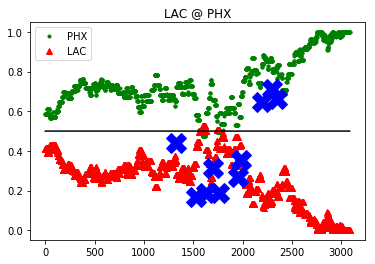

Game important plays: 
Top turning point descriptions: 
With 143.0 seconds left in quarter 2: Williams Free Throw 1 of 2 (16 PTS)
With 101.0 seconds left in quarter 2: Patterson  3PT Jump Shot (11 PTS) (Williams 2 AST)
With 606.0 seconds left in quarter 2: Green 26' 3PT Jump Shot (3 PTS) (Leonard 4 AST)
With 372.0 seconds left in quarter 1: Zubac REBOUND (Off:0 Def:4)
With 378.0 seconds left in quarter 2: Beverley 27' 3PT Pullup Jump Shot (3 PTS) (Leonard 5 AST)
With 688.0 seconds left in quarter 3: Shamet 27' 3PT Pullup Jump Shot (3 PTS) (Leonard 6 AST)
With 652.0 seconds left in quarter 3: Shamet 24' 3PT Pullup Jump Shot (6 PTS) (Leonard 7 AST)
With 285.0 seconds left in quarter 1: Williams 26' 3PT Pullup Jump Shot (3 PTS) (Beverley 2 AST)
With 615.0 seconds left in quarter 1: Zubac Free Throw 1 of 1 (5 PTS)
With 490.0 seconds left in quarter 2: Leonard 6' Jump Shot (6 PTS)
Done


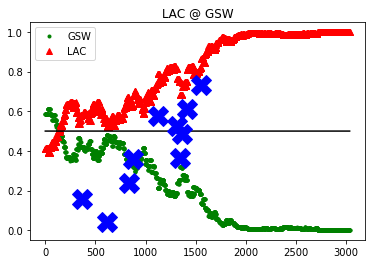

Game important plays: 
Top turning point descriptions: 
With 498.0 seconds left in quarter 4: CLIPPERS Timeout: Regular (Full 4 Short 0)
With 421.0 seconds left in quarter 4: Green 28' 3PT Jump Shot (12 PTS) (Williams 6 AST)
With 584.0 seconds left in quarter 4: Harkless 24' 3PT Jump Shot (10 PTS) (Leonard 5 AST)
With 687.0 seconds left in quarter 4: Williams 21' Pullup Jump Shot (19 PTS) (Harrell 4 AST)
With 470.0 seconds left in quarter 4: Harrell 7' Driving Layup (9 PTS) (Williams 5 AST)
With 32.0 seconds left in quarter 2: Williams 30' 3PT Running Pull-Up Jump Shot (13 PTS)
With 522.0 seconds left in quarter 2: Harkless 24' 3PT Jump Shot (5 PTS) (Beverley 1 AST)
With 368.0 seconds left in quarter 2: Shamet 25' 3PT Running Pull-Up Jump Shot (3 PTS) (Beverley 2 AST)
With 662.0 seconds left in quarter 2: Leonard  3PT Jump Shot (9 PTS) (Williams 3 AST)
With 648.0 seconds left in quarter 4: Leonard Free Throw 1 of 2 (24 PTS)
Done


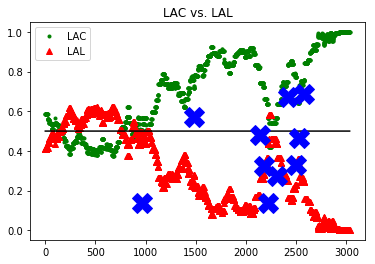

In [14]:
generate_win_probability_team('LAC', 'game')

Home team important plays: 
Top turning point descriptions: 
With 431.0 seconds left in quarter 1: SUB: Kornet FOR Gafford
With 212.0 seconds left in quarter 3: SUB: Arcidiacono FOR Dunn
With 354.0 seconds left in quarter 3: SUB: Young FOR Markkanen
With 380.0 seconds left in quarter 1: Kanter Free Throw 1 of 1 (9 PTS)
With 255.0 seconds left in quarter 1: Out-of-Bounds
With 67.0 seconds left in quarter 3: Brown Free Throw 2 of 3 (16 PTS)
With 381.0 seconds left in quarter 1: MISS Walker Free Throw 2 of 2
With 571.0 seconds left in quarter 2: Out-of-Bounds
With 67.0 seconds left in quarter 3: SUB: Hutchison FOR LaVine
With 704.0 seconds left in quarter 4: Hutchison S.FOUL (P1.T1) (T.Washington)
Done
Visiting team important plays: 
Top turning point descriptions: 
With 431.0 seconds left in quarter 1: Brown Free Throw 2 of 2 (2 PTS)
With 488.0 seconds left in quarter 3: Other
With 539.0 seconds left in quarter 3: Hayward S.FOUL (P2.T1) (T.Washington)
With 229.0 seconds left in quarter 3

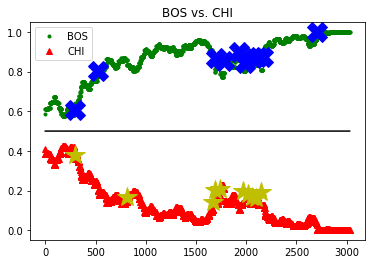

Home team important plays: 
Top turning point descriptions: 
With 701.0 seconds left in quarter 1: Tatum Free Throw 1 of 1 (3 PTS)
With 164.0 seconds left in quarter 1: CELTICS Timeout: Regular (Full 1 Short 0)
With 616.0 seconds left in quarter 1: Walker Free Throw 2 of 2 (2 PTS)
With 164.0 seconds left in quarter 1: Alexander-Walker S.FOUL (P1.PN) (S.Foster)
With 502.0 seconds left in quarter 2: SUB: Ingram FOR Melli
With 367.0 seconds left in quarter 2: CELTICS Rebound
With 367.0 seconds left in quarter 2: CELTICS Rebound
With 639.0 seconds left in quarter 2: Tatum Free Throw 2 of 2 (13 PTS)
With 592.0 seconds left in quarter 2: SUB: Moore FOR Alexander-Walker
With 86.0 seconds left in quarter 2: SUB: Kanter FOR Theis
Done
Visiting team important plays: 
Top turning point descriptions: 
With 630.0 seconds left in quarter 1: Hayes Free Throw 1 of 1 (3 PTS)
With 356.0 seconds left in quarter 2: Kanter S.FOUL (P2.PN) (B.Kennedy)
With 88.0 seconds left in quarter 1: Ingram Free Throw 2 

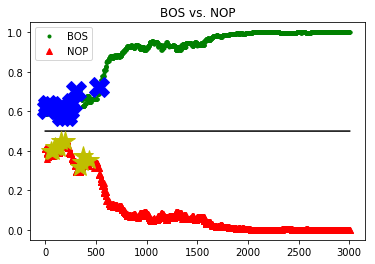

Home team important plays: 
Top turning point descriptions: 
With 587.0 seconds left in quarter 3: Scott 1' Tip Layup Shot (4 PTS)
With 362.0 seconds left in quarter 4: Theis S.FOUL (P3.T4) (S.Corbin)
With 188.0 seconds left in quarter 4: Richardson Free Throw 2 of 2 (25 PTS)
With 547.0 seconds left in quarter 3: Celtics Timeout: Regular (Reg.4 Short 0)
With 609.0 seconds left in quarter 3: Theis Violation:Defensive Goaltending (J.DeRosa)
With 205.0 seconds left in quarter 4: 76ERS Rebound
With 188.0 seconds left in quarter 4: Smart L.B.FOUL (P4.PN) (J.DeRosa)
With 218.0 seconds left in quarter 2: Celtics Timeout: Regular (Reg.2 Short 0)
With 105.0 seconds left in quarter 1: Kanter Offensive Foul Turnover (P1.T1)
With 640.0 seconds left in quarter 2: Williams Offensive Foul Turnover (P1.T4)
Done
Visiting team important plays: 
Top turning point descriptions: 
With 288.0 seconds left in quarter 3: 76ERS Timeout: Regular (Full 3 Short 0)
With 483.0 seconds left in quarter 3: Theis 1' Tip

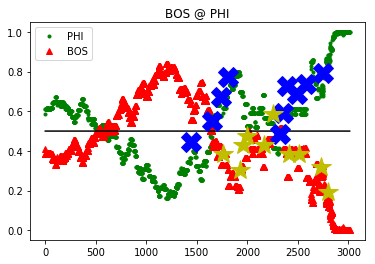

Home team important plays: 
Top turning point descriptions: 
With 60.0 seconds left in quarter 1: Spurs Timeout: Regular (Reg.2 Short 0)
With 381.0 seconds left in quarter 3: Spurs Timeout: Regular (Reg.5 Short 0)
With 409.0 seconds left in quarter 3: Mills S.FOUL (P1.T3) (T.Ford)
With 0.0 seconds left in quarter 1: End of 1st Period (7:33 PM EST)
With 508.0 seconds left in quarter 3: Spurs Timeout: Regular (Reg.4 Short 0)
With 256.0 seconds left in quarter 1: Spurs Timeout: Regular (Reg.1 Short 0)
With 424.0 seconds left in quarter 2: Spurs Timeout: Regular (Reg.3 Short 0)
With 329.0 seconds left in quarter 3: Court Cleanup
With 342.0 seconds left in quarter 2: Forbes S.FOUL (P1.T3) (E.Scott)
With 409.0 seconds left in quarter 3: Theis Free Throw 1 of 1 (11 PTS)
Done
Visiting team important plays: 
Top turning point descriptions: 
With 349.0 seconds left in quarter 3: Aldridge Free Throw Technical (10 PTS)
With 475.0 seconds left in quarter 1: CELTICS Timeout: Regular (Full 1 Short 0)

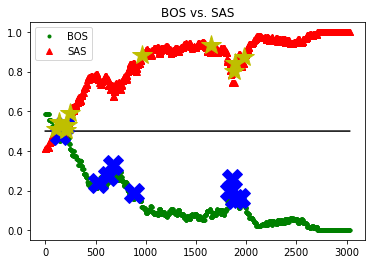

Home team important plays: 
Top turning point descriptions: 
With 588.0 seconds left in quarter 4: Bonga 1' Tip Layup Shot (8 PTS)
With 429.0 seconds left in quarter 4: Celtics Timeout: Regular (Reg.3 Short 0)
With 218.0 seconds left in quarter 3: McRae 1' Layup (16 PTS)
With 193.0 seconds left in quarter 2: Celtics Timeout: Regular (Reg.2 Short 0)
With 547.0 seconds left in quarter 4: SUB: McRae FOR Schofield
With 186.0 seconds left in quarter 1: SUB: Pasecniks FOR Thomas
With 164.0 seconds left in quarter 1: WIZARDS Timeout: Regular (Full 1 Short 0)
With 434.0 seconds left in quarter 2: SUB: Hayward FOR Tatum
With 333.0 seconds left in quarter 1: Brown Violation:Kicked Ball (P.Ransom)
With 295.0 seconds left in quarter 3: Brown L.B.FOUL (P2.T2) (B.Forte)
Done
Visiting team important plays: 
Top turning point descriptions: 
With 309.0 seconds left in quarter 3: Theis 1' Tip Dunk Shot (8 PTS)
With 95.0 seconds left in quarter 3: Brown Jr. S.FOUL (P2.PN) (B.Forte)
With 478.0 seconds lef

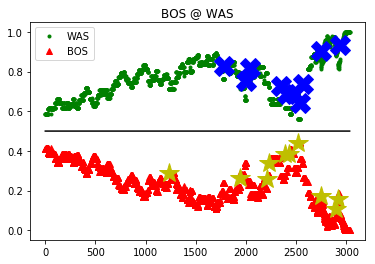

Home team important plays: 
Top turning point descriptions: 
With 128.0 seconds left in quarter 4: Theis Violation:Lane (.)
With 74.0 seconds left in quarter 2: Celtics Timeout: Regular (Reg.2 Short 0)
With 153.0 seconds left in quarter 3: MISS LaVine Free Throw 2 of 2
With 407.0 seconds left in quarter 3: LaVine Free Throw 2 of 2 (23 PTS)
With 496.0 seconds left in quarter 4: Celtics Timeout: Regular (Reg.4 Short 0)
With 184.0 seconds left in quarter 3: Markkanen Free Throw 2 of 2 (15 PTS)
With 565.0 seconds left in quarter 3: Dunn Free Throw 2 of 2 (8 PTS)
With 232.0 seconds left in quarter 3: SUB: Gafford FOR Satoransky
With 317.0 seconds left in quarter 2: LaVine Free Throw 2 of 2 (15 PTS)
With 372.0 seconds left in quarter 2: SUB: Dunn FOR White
Done
Visiting team important plays: 
Top turning point descriptions: 
With 360.0 seconds left in quarter 4: Dunn S.FOUL (P3.T3) (A.Smith)
With 278.0 seconds left in quarter 2: BULLS Timeout: Regular (Full 3 Short 0)
With 146.0 seconds left

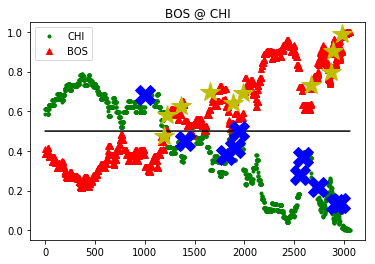

Home team important plays: 
Top turning point descriptions: 
With 41.0 seconds left in quarter 4: Hawks Timeout: Regular (Reg.7 Short 0)
With 0.0 seconds left in quarter 3: MISS Parker 55' 3PT Jump Shot
With 0.0 seconds left in quarter 4: Young P.FOUL (P3.PN) (C.Kirkland)
With 114.0 seconds left in quarter 3: Kanter HANGING.TECH.FOUL (P1.T3) (M.Boland)
With 278.0 seconds left in quarter 3: Kanter 1' Tip Layup Shot (8 PTS)
With 71.0 seconds left in quarter 4: Hunter S.FOUL (P5.PN) (C.Kirkland)
With 600.0 seconds left in quarter 3: Hawks Timeout: Regular (Reg.4 Short 0)
With 644.0 seconds left in quarter 4: SUB: Tatum FOR Williams
With 625.0 seconds left in quarter 4: Tatum Free Throw 2 of 2 (11 PTS)
With 514.0 seconds left in quarter 4: Hawks Timeout: Regular (Reg.6 Short 0)
Done
Visiting team important plays: 
Top turning point descriptions: 
With 191.0 seconds left in quarter 3: CELTICS Timeout: Regular (Full 2 Short 0)
With 88.0 seconds left in quarter 4: SUB: Theis FOR Kanter
With 5

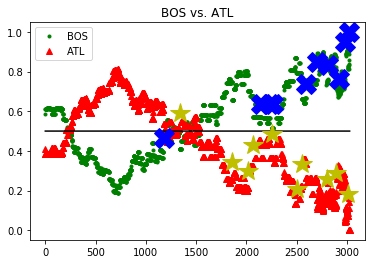

Home team important plays: 
Top turning point descriptions: 
With 705.0 seconds left in quarter 4: Monk Free Throw 2 of 2 (4 PTS)
With 33.0 seconds left in quarter 3: SUB: Martin FOR Monk
With 62.0 seconds left in quarter 3: Graham Free Throw 2 of 2 (8 PTS)
With 174.0 seconds left in quarter 2: Celtics Timeout: Regular (Reg.2 Short 0)
With 297.0 seconds left in quarter 1: Out-of-Bounds
With 234.0 seconds left in quarter 2: Theis S.FOUL (P1.T2) (M.Ayotte)
With 584.0 seconds left in quarter 1: Rozier 1' Running Layup (2 PTS) (Bridges 1 AST)
With 693.0 seconds left in quarter 3: Theis P.FOUL (P2.T1) (A.Moyer-Gleich)
With 249.0 seconds left in quarter 1: SUB: Kanter FOR Theis
With 148.0 seconds left in quarter 1: Celtics Timeout: Regular (Reg.1 Short 0)
Done
Visiting team important plays: 
Top turning point descriptions: 
With 141.0 seconds left in quarter 3: Monk S.FOUL (P1.T4) (G.Petraitis)
With 53.0 seconds left in quarter 3: Wanamaker Free Throw 2 of 2 (4 PTS)
With 299.0 seconds left i

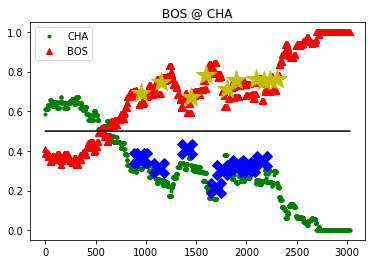

Home team important plays: 
Top turning point descriptions: 
With 0.0 seconds left in quarter 2: Instant Replay2nd Period (8:09 PM EST)
With 395.0 seconds left in quarter 3: Raptors Timeout: Regular (Reg.3 Short 0)
With 101.0 seconds left in quarter 3: Kanter REBOUND (Off:1 Def:2)
With 0.0 seconds left in quarter 1: Instant Replay1st Period (7:37 PM EST)
With 421.0 seconds left in quarter 3: Tatum Free Throw 2 of 2 (10 PTS)
With 53.0 seconds left in quarter 2: SUB: Davis FOR Hollis-Jefferson
With 678.0 seconds left in quarter 3: Tatum Free Throw 2 of 2 (8 PTS)
With 34.0 seconds left in quarter 2: Hayward Free Throw 2 of 2 (8 PTS)
With 426.0 seconds left in quarter 2: Wanamaker Free Throw 2 of 2 (2 PTS)
With 69.0 seconds left in quarter 2: Walker Free Throw 2 of 2 (11 PTS)
Done
Visiting team important plays: 
Top turning point descriptions: 
With 190.0 seconds left in quarter 3: VanVleet Free Throw 2 of 3 (12 PTS)
With 452.0 seconds left in quarter 4: Williams S.FOUL (P3.T2) (M.Kogut)
W

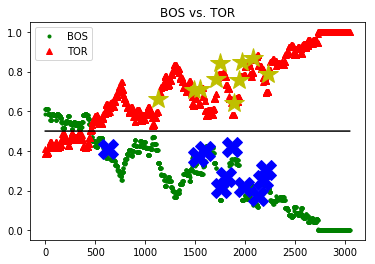

Home team important plays: 
Top turning point descriptions: 
With 39.0 seconds left in quarter 3: Equipment Malfunction
With 609.0 seconds left in quarter 1: Osman Offensive Foul Turnover (P1.T1)
With 327.0 seconds left in quarter 1: Out-of-Bounds
With 188.0 seconds left in quarter 1: SUB: Theis FOR Kanter
With 71.0 seconds left in quarter 1: Wanamaker Free Throw 2 of 2 (2 PTS)
With 631.0 seconds left in quarter 3: Osman S.FOUL (P2.T1) (R.Acosta)
With 24.0 seconds left in quarter 1: Out-of-Bounds
With 312.0 seconds left in quarter 1: Walker Free Throw 2 of 2 (6 PTS)
With 410.0 seconds left in quarter 2: Cavaliers Timeout: Regular (Reg.2 Short 0)
With 105.0 seconds left in quarter 3: Theis Free Throw 2 of 2 (4 PTS)
Done
Visiting team important plays: 
Top turning point descriptions: 
With 366.0 seconds left in quarter 1: CELTICS Timeout: Regular (Full 1 Short 0)
With 117.0 seconds left in quarter 1: Out-of-Bounds
With 188.0 seconds left in quarter 1: SUB: Exum FOR Love
With 167.0 second

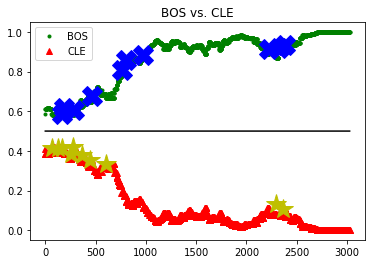

Home team important plays: 
Top turning point descriptions: 
With 447.0 seconds left in quarter 2: Celtics Timeout: Regular (Reg.2 Short 0)
With 515.0 seconds left in quarter 2: Theis S.FOUL (P2.T3) (C.Kirkland)
With 658.0 seconds left in quarter 1: Ibaka 1' Putback Layup (4 PTS)
With 515.0 seconds left in quarter 2: SUB: VanVleet FOR Davis
With 667.0 seconds left in quarter 1: Tatum REBOUND (Off:2 Def:0)
With 440.0 seconds left in quarter 1: Tatum Offensive Foul Turnover (P1.T2)
With 105.0 seconds left in quarter 1: SUB: Lowry FOR VanVleet
With 506.0 seconds left in quarter 3: MISS Anunoby Free Throw 2 of 2
With 253.0 seconds left in quarter 2: Hayward Personal Take Foul (P1.T4) (J.Goble)
With 46.0 seconds left in quarter 2: Hayward Offensive Foul Turnover (P1.T8)
Done
Visiting team important plays: 
Top turning point descriptions: 
With 262.0 seconds left in quarter 1: Tatum 1' Tip Layup Shot (2 PTS)
With 236.0 seconds left in quarter 2: Brown Free Throw 2 of 2 (9 PTS)
With 132.0 sec

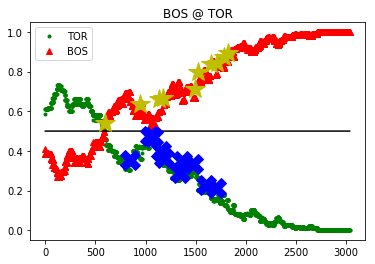

Home team important plays: 
Top turning point descriptions: 
With 207.0 seconds left in quarter 2: SUB: Zeller FOR Biyombo
With 21.0 seconds left in quarter 2: SUB: Langford FOR Walker
With 613.0 seconds left in quarter 2: SUB: Biyombo FOR Zeller
With 112.0 seconds left in quarter 2: Zeller S.FOUL (P2.PN) (J.Tiven)
With 580.0 seconds left in quarter 3: Biyombo S.FOUL (P1.T2) (N.Green)
With 660.0 seconds left in quarter 2: Tatum Free Throw 2 of 2 (12 PTS)
With 21.0 seconds left in quarter 2: Bridges P.FOUL (P1.PN) (T.Ford)
With 579.0 seconds left in quarter 4: Hornets Timeout: Regular (Reg.4 Short 0)
With 294.0 seconds left in quarter 1: SUB: Martin FOR Batum
With 391.0 seconds left in quarter 1: CELTICS Rebound
Done
Visiting team important plays: 
Top turning point descriptions: 
With 527.0 seconds left in quarter 2: Graham Free Throw 2 of 3 (19 PTS)
With 613.0 seconds left in quarter 2: SUB: Kanter FOR Theis
With 691.0 seconds left in quarter 3: Theis S.FOUL (P3.T1) (N.Green)
With 707

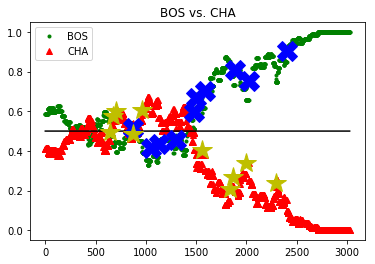

Home team important plays: 
Top turning point descriptions: 
With 1.0 seconds left in quarter 2: Galloway S.FOUL (P1.PN) (A.Smith)
With 608.0 seconds left in quarter 3: Theis 1' Tip Dunk Shot (5 PTS)
With 577.0 seconds left in quarter 2: Wanamaker Free Throw 2 of 2 (2 PTS)
With 418.0 seconds left in quarter 1: CELTICS Timeout: Regular (Full 1 Short 0)
With 271.0 seconds left in quarter 1: Pistons Rebound
With 260.0 seconds left in quarter 1: SUB: Williams FOR Ojeleye
With 27.0 seconds left in quarter 1: Galloway REBOUND (Off:0 Def:1)
With 202.0 seconds left in quarter 1: Rose Bad Pass Turnover (P1.T5)#@#Langford STEAL (1 STL)
With 264.0 seconds left in quarter 2: Tatum Violation:Defensive Goaltending (.)
With 202.0 seconds left in quarter 2: SUB: Rose FOR Morris
Done
Visiting team important plays: 
Top turning point descriptions: 
With 285.0 seconds left in quarter 1: Brown 1' Tip Layup Shot (2 PTS)
With 659.0 seconds left in quarter 2: Williams S.FOUL (P1.T1) (A.Smith)
With 659.0 seco

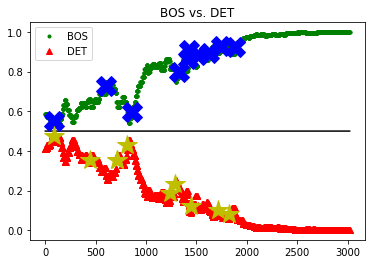

Home team important plays: 
Top turning point descriptions: 
With 17.0 seconds left in quarter 2: Other
With 20.0 seconds left in quarter 4: Broekhoff Free Throw 2 of 3 (5 PTS)
With 20.0 seconds left in quarter 4: Broekhoff Free Throw 2 of 3 (5 PTS)
With 16.0 seconds left in quarter 4: Broekhoff Personal Take Foul (P2.PN) (K.Lane)
With 161.0 seconds left in quarter 3: Wright Free Throw 2 of 2 (4 PTS)
With 379.0 seconds left in quarter 4: Hardaway Jr. Free Throw 2 of 2 (13 PTS)
With 44.0 seconds left in quarter 2: SUB: Finney-Smith FOR Hardaway Jr.
With 281.0 seconds left in quarter 2: MISS Porzingis Free Throw 2 of 2
With 676.0 seconds left in quarter 2: Kanter Offensive Foul Turnover (P1.T5)
With 420.0 seconds left in quarter 1: Celtics Timeout: Regular (Reg.1 Short 0)
Done
Visiting team important plays: 
Top turning point descriptions: 
With 316.0 seconds left in quarter 4: MAVERICKS Timeout: Regular (Full 5 Short 0)
With 398.0 seconds left in quarter 4: Hardaway Jr. S.FOUL (P2.T3) (

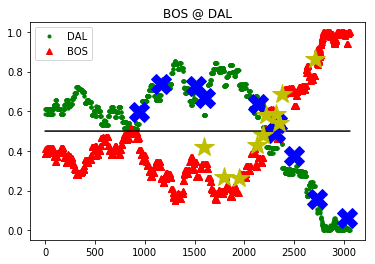

Home team important plays: 
Top turning point descriptions: 
With 26.0 seconds left in quarter 4: 76ers Timeout: Regular (Reg.7 Short 0)
With 61.0 seconds left in quarter 4: 76ers Timeout: Regular (Reg.6 Short 0)
With 262.0 seconds left in quarter 2: Simmons L.B.FOUL (P2.T3) (K.Scott)
With 466.0 seconds left in quarter 4: SUB: Theis FOR Kanter
With 364.0 seconds left in quarter 3: SUB: Green FOR Tatum
With 478.0 seconds left in quarter 3: MISS Hayward Free Throw 2 of 2
With 225.0 seconds left in quarter 1: Thybulle S.FOUL (P1.T3) (K.Scott)
With 30.0 seconds left in quarter 2: MISS Walker Free Throw 2 of 3
With 156.0 seconds left in quarter 2: Simmons S.FOUL (P3.T4) (K.Scott)
With 0.0 seconds left in quarter 3: End of 3rd Period (10:00 PM EST)
Done
Visiting team important plays: 
Top turning point descriptions: 
With 25.0 seconds left in quarter 4: Embiid Free Throw 2 of 2 (35 PTS)
With 34.0 seconds left in quarter 4: Simmons Free Throw 2 of 2 (7 PTS)
With 211.0 seconds left in quarter 

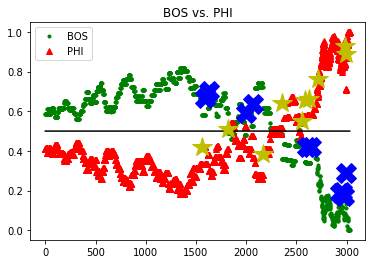

Home team important plays: 
Top turning point descriptions: 
With 85.0 seconds left in quarter 4: Celtics Timeout: Regular (Reg.5 Short 0)
With 230.0 seconds left in quarter 4: SUB: Theis FOR Williams
With 17.0 seconds left in quarter 4: SUB: Turner FOR Sabonis
With 168.0 seconds left in quarter 4: Out-of-Bounds
With 553.0 seconds left in quarter 4: Celtics Timeout: Regular (Reg.4 Short 0)
With 119.0 seconds left in quarter 4: Brogdon Free Throw 2 of 2 (23 PTS)
With 2.0 seconds left in quarter 4: Out-of-Bounds
With 80.0 seconds left in quarter 3: Brown S.FOUL (P4.PN) (P.Fraher)
With 307.0 seconds left in quarter 4: McDermott Free Throw 2 of 2 (8 PTS)
With 672.0 seconds left in quarter 4: Kanter S.FOUL (P2.T1) (M.Smith)
Done
Visiting team important plays: 
Top turning point descriptions: 
With 290.0 seconds left in quarter 4: Tatum Free Throw 2 of 2 (14 PTS)
With 81.0 seconds left in quarter 4: SUB: Sabonis FOR Turner
With 17.0 seconds left in quarter 4: Green Personal Take Foul (P1.PN)

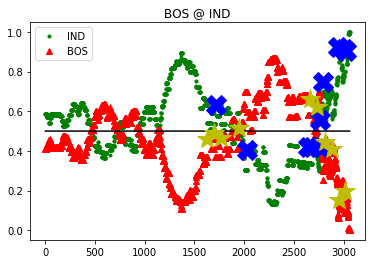

Home team important plays: 
Top turning point descriptions: 
With 597.0 seconds left in quarter 1: Brown Free Throw 1 of 1 (5 PTS)
With 529.0 seconds left in quarter 3: MISS Tatum Free Throw 1 of 2
With 262.0 seconds left in quarter 3: Out-of-Bounds
With 674.0 seconds left in quarter 4: Delay Of Game
With 663.0 seconds left in quarter 4: Dellavedova S.FOUL (P1.T1) (P.Ransom)
With 663.0 seconds left in quarter 4: MISS Wanamaker Free Throw 1 of 2
With 233.0 seconds left in quarter 3: SUB: Dellavedova FOR Garland
With 150.0 seconds left in quarter 3: Clarkson Free Throw 2 of 2 (9 PTS)
With 172.0 seconds left in quarter 3: SUB: Brown FOR Walker
With 233.0 seconds left in quarter 3: Poirier S.FOUL (P1.T4) (D.Taylor)
Done
Visiting team important plays: 
Top turning point descriptions: 
With 424.0 seconds left in quarter 2: Walker S.FOUL (P1.T3) (R.Mott)
With 150.0 seconds left in quarter 2: MISS Thompson Free Throw 2 of 2
With 373.0 seconds left in quarter 1: Theis Offensive Foul Turnover (P

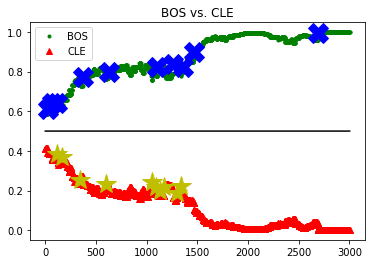

Home team important plays: 
Top turning point descriptions: 
With 446.0 seconds left in quarter 1: Nuggets Timeout: Regular (Reg.1 Short 0)
With 688.0 seconds left in quarter 1: Jokic P.FOUL (P1.T1) (M.Lindsay)
With 252.0 seconds left in quarter 3: Nuggets Timeout: Regular (Reg.4 Short 0)
With 45.0 seconds left in quarter 1: Out-of-Bounds
With 77.0 seconds left in quarter 2: Barton P.FOUL (P1.T2) (E.Malloy)
With 255.0 seconds left in quarter 1: SUB: Plumlee FOR Millsap
With 33.0 seconds left in quarter 1: SUB: Williams III FOR Kanter
With 467.0 seconds left in quarter 3: Murray L.B.FOUL (P1.T1) (M.Lindsay)
With 135.0 seconds left in quarter 1: Nuggets Timeout: Regular (Reg.2 Short 0)
With 455.0 seconds left in quarter 2: SUB: Murray FOR Morris
Done
Visiting team important plays: 
Top turning point descriptions: 
With 83.0 seconds left in quarter 1: Other
With 145.0 seconds left in quarter 3: Kanter Offensive Foul Turnover (P1.T10)
With 395.0 seconds left in quarter 4: Ojeleye S.FOUL (P

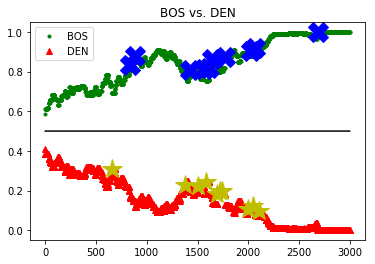

Home team important plays: 
Top turning point descriptions: 
With 74.0 seconds left in quarter 2: Adebayo Violation:Defensive Goaltending (K.Lane)
With 144.0 seconds left in quarter 2: SUB: Herro FOR Robinson
With 225.0 seconds left in quarter 2: SUB: Brown FOR Edwards
With 286.0 seconds left in quarter 2: Ojeleye Free Throw 2 of 2 (2 PTS)
With 297.0 seconds left in quarter 2: Theis Free Throw 2 of 2 (4 PTS)
With 286.0 seconds left in quarter 2: Olynyk P.FOUL (P3.PN) (S.Wright)
With 172.0 seconds left in quarter 2: MISS Brown Free Throw 1 of 2
With 225.0 seconds left in quarter 2: Butler L.B.FOUL (P1.PN) (S.Wright)
With 675.0 seconds left in quarter 2: MISS Tatum Free Throw 2 of 2
With 646.0 seconds left in quarter 1: Nunn Offensive Foul Turnover (P1.T2)
Done
Visiting team important plays: 
Top turning point descriptions: 
With 152.0 seconds left in quarter 3: Brown S.FOUL (P1.PN) (D.Richardson)
With 130.0 seconds left in quarter 3: MISS Winslow Free Throw 2 of 2
With 344.0 seconds lef

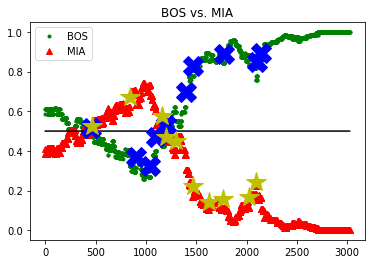

Home team important plays: 
Top turning point descriptions: 
With 572.0 seconds left in quarter 1: Delay Of Game
With 559.0 seconds left in quarter 1: MISS Gibson 6' Turnaround Hook Shot
With 71.0 seconds left in quarter 2: Instant Replay2nd Period (4:35 PM EST)
With 204.0 seconds left in quarter 2: SUB: Tatum FOR Ojeleye
With 301.0 seconds left in quarter 3: Edwards S.FOUL (P2.PN) (J.Tiven)
With 112.0 seconds left in quarter 2: Smart S.FOUL (P2.T4) (J.Tiven)
With 550.0 seconds left in quarter 4: Portis Free Throw 2 of 2 (9 PTS)
With 529.0 seconds left in quarter 4: MISS Kanter Free Throw 2 of 2
With 481.0 seconds left in quarter 4: SUB: Barrett FOR Ellington
With 699.0 seconds left in quarter 3: Barrett Free Throw 2 of 2 (14 PTS)
Done
Visiting team important plays: 
Top turning point descriptions: 
With 572.0 seconds left in quarter 1: Delay Of Game
With 559.0 seconds left in quarter 1: MISS Gibson 6' Turnaround Hook Shot
With 333.0 seconds left in quarter 2: KNICKS Timeout: Regular (

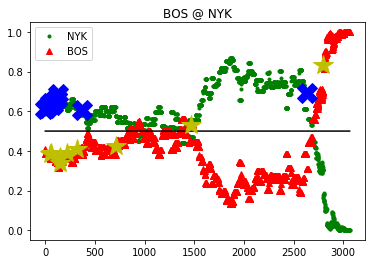

Home team important plays: 
Top turning point descriptions: 
With 583.0 seconds left in quarter 4: Celtics Timeout: Regular (Reg.4 Short 0)
With 339.0 seconds left in quarter 3: SUB: Williams III FOR Brown
With 456.0 seconds left in quarter 3: Celtics Timeout: Regular (Reg.3 Short 0)
With 178.0 seconds left in quarter 2: Brown S.FOUL (P1.T3) (B.Barnaky)
With 536.0 seconds left in quarter 3: Instant Replay3rd Period (1:23 PM EST)
With 484.0 seconds left in quarter 3: Smart T.FOUL (P4.T2) (J.DeRosa)
With 178.0 seconds left in quarter 2: Pinson 1' Driving Layup (4 PTS) (Dinwiddie 8 AST)
With 569.0 seconds left in quarter 1: Celtics Timeout: Regular (Reg.1 Short 0)
With 336.0 seconds left in quarter 1: SUB: Musa FOR Temple
With 308.0 seconds left in quarter 1: Smart P.FOUL (P1.T1) (J.DeRosa)
Done
Visiting team important plays: 
Top turning point descriptions: 
With 0.0 seconds left in quarter 2: MISS Pinson 77' 3PT Running Pull-Up Jump Shot
With 459.0 seconds left in quarter 2: NETS Timeou

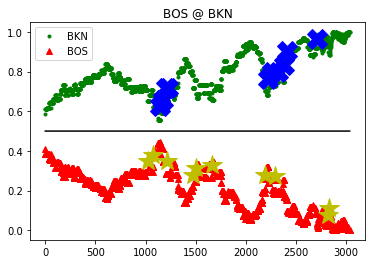

Home team important plays: 
Top turning point descriptions: 
With 148.0 seconds left in quarter 3: Brown REBOUND (Off:1 Def:5)
With 206.0 seconds left in quarter 3: Nets Timeout: Regular (Reg.3 Short 0)
With 399.0 seconds left in quarter 3: Allen S.FOUL (P2.PN) (S.Wall)
With 593.0 seconds left in quarter 4: Kanter Free Throw 1 of 2 (4 PTS)
With 120.0 seconds left in quarter 3: Tatum Free Throw 2 of 2 (12 PTS)
With 334.0 seconds left in quarter 3: Theis Free Throw 2 of 2 (14 PTS)
With 261.0 seconds left in quarter 4: Temple S.FOUL (P1.PN) (J.Capers)
With 261.0 seconds left in quarter 4: SUB: Prince FOR Nwaba
With 525.0 seconds left in quarter 3: Walker Free Throw 2 of 2 (22 PTS)
With 660.0 seconds left in quarter 4: Smart Free Throw 2 of 2 (7 PTS)
Done
Visiting team important plays: 
Top turning point descriptions: 
With 0.0 seconds left in quarter 3: End of 3rd Period (8:58 PM EST)
With 122.0 seconds left in quarter 2: CELTICS Timeout: Regular (Full 3 Short 0)
With 450.0 seconds left i

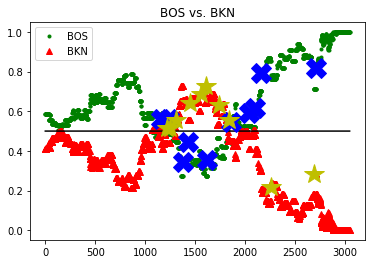

IndexError: index 3018 is out of bounds for axis 0 with size 3018

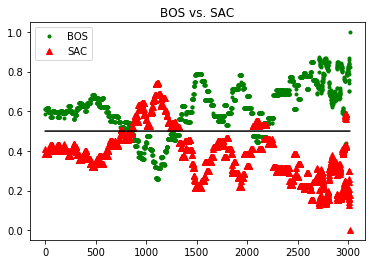

In [15]:
generate_win_probability_team('BOS', 'no_game')

Game important plays: 
Top turning point descriptions: 
With 696.0 seconds left in quarter 3: Crowder 25' 3PT Running Pull-Up Jump Shot (5 PTS)
With 213.0 seconds left in quarter 2: Jackson Jr. 24' 3PT Jump Shot (10 PTS) (Jones 2 AST)
With 249.0 seconds left in quarter 2: Jackson Jr. 25' 3PT Running Jump Shot (7 PTS) (Morant 7 AST)
With 411.0 seconds left in quarter 3: Valanciunas REBOUND (Off:8 Def:5)
With 465.0 seconds left in quarter 2: GRIZZLIES Timeout: Regular (Full 2 Short 0)
With 607.0 seconds left in quarter 3: Valanciunas 2' Driving Layup (16 PTS) (Morant 8 AST)
With 648.0 seconds left in quarter 2: Melton  3PT Running Jump Shot (7 PTS) (Anderson 3 AST)
With 487.0 seconds left in quarter 3: Russell Out of Bounds - Bad Pass Turnover Turnover (P1.T10)
With 613.0 seconds left in quarter 2: Valanciunas REBOUND (Off:2 Def:3)
With 84.0 seconds left in quarter 2: Jackson Jr. 2' Driving Finger Roll Layup (14 PTS) (Melton 1 AST)
Done


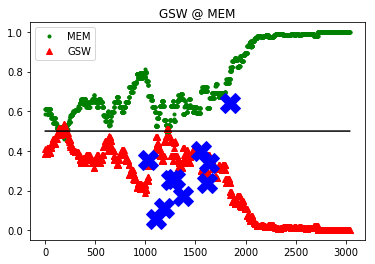

Game important plays: 
Top turning point descriptions: 
With 142.0 seconds left in quarter 4: Williams 26' 3PT Pullup Jump Shot (21 PTS) (Beverley 9 AST)
With 416.0 seconds left in quarter 4: Williams  3PT Fadeaway Jumper (18 PTS) (Beverley 8 AST)
With 272.0 seconds left in quarter 4: Burks Free Throw 1 of 1 (16 PTS)
With 398.0 seconds left in quarter 3: Green 26' 3PT Jump Shot (6 PTS) (Burks 4 AST)
With 214.0 seconds left in quarter 4: CLIPPERS Timeout: Regular (Full 5 Short 0)
With 364.0 seconds left in quarter 2: Smailagic 1' Tip Layup Shot (2 PTS)
With 583.0 seconds left in quarter 3: Shamet 25' 3PT Step Back Jump Shot (3 PTS) (Zubac 1 AST)
With 527.0 seconds left in quarter 4: Harrell 2' Cutting Layup Shot (8 PTS) (Beverley 7 AST)
With 572.0 seconds left in quarter 4: Paschall 1' Cutting Layup Shot (10 PTS) (Robinson III 4 AST)
With 163.0 seconds left in quarter 2: Spellman 25' 3PT Jump Shot (11 PTS) (Bowman 3 AST)
Done


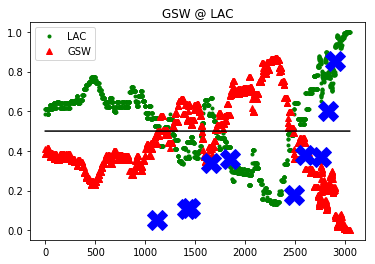

Game important plays: 
Top turning point descriptions: 
With 128.0 seconds left in quarter 4: Lee Free Throw 3 of 3 (15 PTS)
With 425.0 seconds left in quarter 3: Cauley-Stein 1' Tip Layup Shot (10 PTS)
With 438.0 seconds left in quarter 3: Lopez 28' 3PT Jump Shot (10 PTS) (Antetokounmpo 2 AST)
With 593.0 seconds left in quarter 4: Korver 30' 3PT Running Jump Shot (4 PTS) (Antetokounmpo 4 AST)
With 97.0 seconds left in quarter 2: Middleton 29' 3PT Pullup Jump Shot (10 PTS) (DiVincenzo 2 AST)
With 75.0 seconds left in quarter 2: Matthews  3PT Pullup Jump Shot (3 PTS) (DiVincenzo 3 AST)
With 665.0 seconds left in quarter 3: Lopez 27' 3PT Jump Shot (7 PTS) (Matthews 1 AST)
With 197.0 seconds left in quarter 2: Middleton 27' 3PT Jump Shot (5 PTS) (DiVincenzo 1 AST)
With 120.0 seconds left in quarter 2: Middleton Free Throw 1 of 2 (7 PTS)
With 1.0 seconds left in quarter 3: SUB: Smailagic FOR Paschall
Done


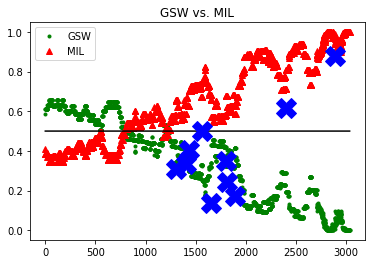

Game important plays: 
Top turning point descriptions: 
With 535.0 seconds left in quarter 2: Ariza 26' 3PT Jump Shot (9 PTS) (Fox 4 AST)
With 593.0 seconds left in quarter 2: Chriss S.FOUL (P1.T1) (E.Dalen)
With 472.0 seconds left in quarter 2: Ariza 24' 3PT Jump Shot (12 PTS) (Joseph 1 AST)
With 290.0 seconds left in quarter 2: Bjelica 28' 3PT Jump Shot (3 PTS) (Barnes 1 AST)
With 432.0 seconds left in quarter 1: Hield 24' 3PT Jump Shot (3 PTS) (Fox 2 AST)
With 505.0 seconds left in quarter 1: Barnes REBOUND (Off:0 Def:2)
With 532.0 seconds left in quarter 1: Bjelica REBOUND (Off:0 Def:1)
With 657.0 seconds left in quarter 1: Paschall Out of Bounds - Bad Pass Turnover Turnover (P1.T1)
With 554.0 seconds left in quarter 1: Barnes REBOUND (Off:0 Def:1)
With 442.0 seconds left in quarter 1: Holmes REBOUND (Off:0 Def:1)
Done


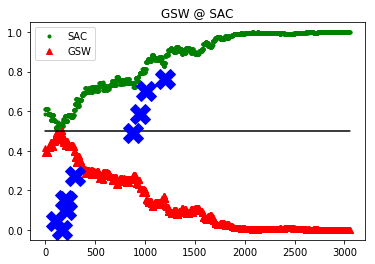

Game important plays: 
Top turning point descriptions: 
With 11.0 seconds left in quarter 2: Lee 26' 3PT Jump Shot (7 PTS) (Burks 3 AST)
With 210.0 seconds left in quarter 2: WARRIORS Timeout: Regular (Full 2 Short 0)
With 403.0 seconds left in quarter 4: Doumbouya 25' 3PT Jump Shot (16 PTS) (Brown 3 AST)
With 554.0 seconds left in quarter 4: Rose 21' Fadeaway Jumper (20 PTS)
With 104.0 seconds left in quarter 2: Spellman 27' 3PT Jump Shot (14 PTS) (Lee 2 AST)
With 616.0 seconds left in quarter 4: Brown 2' Dunk (6 PTS)
With 374.0 seconds left in quarter 2: Spellman 28' 3PT Jump Shot (6 PTS) (Robinson III 1 AST)
With 705.0 seconds left in quarter 4: Rose 10' Driving Floating Jump Shot (18 PTS)
With 443.0 seconds left in quarter 2: Spellman 24' 3PT Jump Shot (3 PTS) (Lee 1 AST)
With 445.0 seconds left in quarter 4: Rose 12' Fadeaway Jumper (22 PTS)
Done


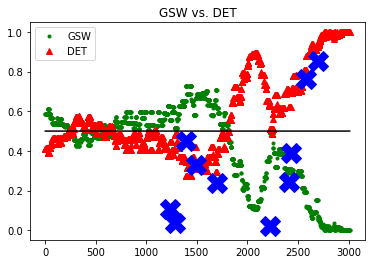

Game important plays: 
Top turning point descriptions: 
With 465.0 seconds left in quarter 4: Covington 24' 3PT Step Back Jump Shot (17 PTS)
With 222.0 seconds left in quarter 1: Martin 25' 3PT Pullup Jump Shot (5 PTS)
With 32.0 seconds left in quarter 1: Okogie 25' 3PT Pullup Jump Shot (7 PTS)
With 181.0 seconds left in quarter 1: Reid 25' 3PT Jump Shot (3 PTS) (Okogie 2 AST)
With 264.0 seconds left in quarter 4: Napier Free Throw 1 of 2 (17 PTS)
With 416.0 seconds left in quarter 1: Burks Bad Pass Turnover (P1.T2)#@#Culver STEAL (1 STL)
With 666.0 seconds left in quarter 1: Culver L.B.FOUL (P1.T1) (J.DeRosa)
With 642.0 seconds left in quarter 1: Martin REBOUND (Off:0 Def:1)
With 453.0 seconds left in quarter 1: Lee Lost Ball Turnover (P1.T1)#@#Napier STEAL (1 STL)
With 475.0 seconds left in quarter 1: Covington REBOUND (Off:0 Def:1)
Done


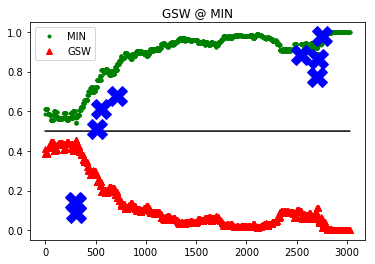

Game important plays: 
Top turning point descriptions: 
With 9.0 seconds left in quarter 4: SUB: Forbes FOR Murray
With 145.0 seconds left in quarter 5: Instant Replay1st OT (9:27 PM EST)
With 17.0 seconds left in quarter 4: DeRozan 17' Pullup Jump Shot (22 PTS)
With 266.0 seconds left in quarter 4: Lee 34' 3PT Jump Shot (20 PTS) (Robinson III 3 AST)
With 101.0 seconds left in quarter 3: Belinelli 26' 3PT Jump Shot (3 PTS) (White 3 AST)
With 658.0 seconds left in quarter 4: Mills 25' 3PT Jump Shot (15 PTS) (White 4 AST)
With 63.0 seconds left in quarter 4: Burks 26' 3PT Jump Shot (19 PTS) (Green 6 AST)
With 705.0 seconds left in quarter 3: Robinson III 24' 3PT Jump Shot (21 PTS) (Green 3 AST)
With 666.0 seconds left in quarter 3: Burks 26' 3PT Pullup Jump Shot (10 PTS) (Green 4 AST)
With 279.0 seconds left in quarter 3: Mills 26' 3PT Jump Shot (12 PTS) (DeRozan 2 AST)
Done


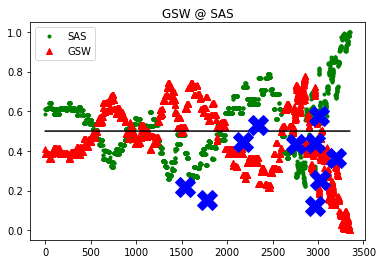

Game important plays: 
Top turning point descriptions: 
With 458.0 seconds left in quarter 3: Green 27' 3PT Pullup Jump Shot (10 PTS) (Robinson III 2 AST)
With 322.0 seconds left in quarter 3: Hardaway Jr. 29' 3PT Jump Shot (22 PTS) (Powell 2 AST)
With 368.0 seconds left in quarter 2: Russell 30' 3PT Jump Shot (24 PTS)
With 202.0 seconds left in quarter 2: Russell 30' 3PT Jump Shot (30 PTS) (Green 7 AST)
With 293.0 seconds left in quarter 2: Russell 28' 3PT Step Back Jump Shot (27 PTS)
With 345.0 seconds left in quarter 3: Doncic 7' Driving Finger Roll Layup (29 PTS)
With 433.0 seconds left in quarter 2: Jackson 27' 3PT Jump Shot (3 PTS) (Wright 2 AST)
With 428.0 seconds left in quarter 3: Russell 7' Floating Jump Shot (32 PTS)
With 83.0 seconds left in quarter 2: Green 3' Driving Dunk (2 PTS) (Russell 4 AST)
With 73.0 seconds left in quarter 1: Mavericks Violation: Delay of game Violation
Done


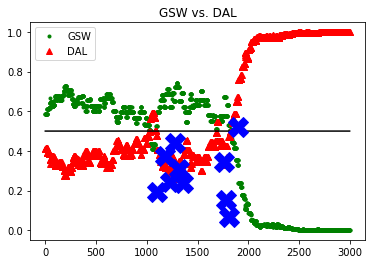

Game important plays: 
Top turning point descriptions: 
With 276.0 seconds left in quarter 3: Oubre Jr. Free Throw 1 of 2 (6 PTS)
With 239.0 seconds left in quarter 4: Lee Free Throw 1 of 2 (14 PTS)
With 273.0 seconds left in quarter 4: Burks REBOUND (Off:0 Def:5)
With 254.0 seconds left in quarter 4: Robinson III REBOUND (Off:3 Def:3)
With 363.0 seconds left in quarter 4: Booker 4' Driving Finger Roll Layup (30 PTS)
With 118.0 seconds left in quarter 4: Green 27' 3PT Jump Shot (10 PTS) (Russell 6 AST)
With 207.0 seconds left in quarter 3: Bridges REBOUND (Off:1 Def:1)
With 291.0 seconds left in quarter 2: Kaminsky 26' 3PT Jump Shot (9 PTS) (Booker 4 AST)
With 220.0 seconds left in quarter 4: Green REBOUND (Off:2 Def:3)
With 188.0 seconds left in quarter 4: Lee Free Throw 1 of 2 (15 PTS)
Done


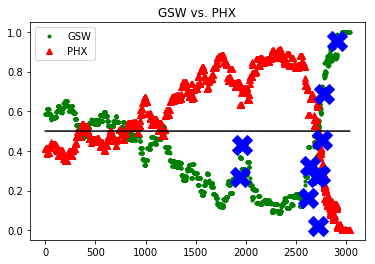

Game important plays: 
Top turning point descriptions: 
With 479.0 seconds left in quarter 4: Chriss S.FOUL (P4.T2) (D.Taylor)
With 348.0 seconds left in quarter 4: Green  3PT Pullup Jump Shot (16 PTS) (Bowman 5 AST)
With 454.0 seconds left in quarter 3: House Jr. 24' 3PT Pullup Jump Shot (9 PTS) (Harden 9 AST)
With 199.0 seconds left in quarter 2: Lee 1' Tip Layup Shot (11 PTS)
With 589.0 seconds left in quarter 3: House Jr. 27' 3PT Running Pull-Up Jump Shot (6 PTS) (Harden 8 AST)
With 447.0 seconds left in quarter 4: Russell 2' Layup (20 PTS)
With 420.0 seconds left in quarter 2: SUB: Green FOR Burks
With 417.0 seconds left in quarter 3: Westbrook S.FOUL (P3.T1) (T.Brown)
With 188.0 seconds left in quarter 2: Harden 27' 3PT Step Back Jump Shot (17 PTS)
With 77.0 seconds left in quarter 1: Westbrook Free Throw 2 of 3 (9 PTS)
Done


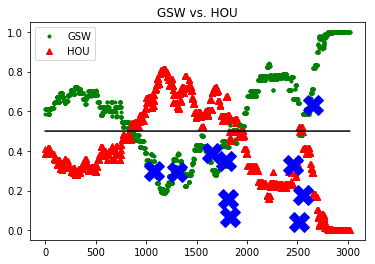

Game important plays: 
Top turning point descriptions: 
With 326.0 seconds left in quarter 4: Burks 26' 3PT Pullup Jump Shot (20 PTS)
With 414.0 seconds left in quarter 4: Russell 27' 3PT Fadeaway Jumper (26 PTS) (Green 3 AST)
With 232.0 seconds left in quarter 2: Paschall 27' 3PT Jump Shot (8 PTS) (Green 2 AST)
With 54.0 seconds left in quarter 1: Chriss REBOUND (Off:2 Def:1)
With 168.0 seconds left in quarter 4: Lee  3PT Jump Shot (12 PTS) (Green 5 AST)
With 373.0 seconds left in quarter 2: Looney 11' Turnaround Jump Shot (4 PTS)
With 412.0 seconds left in quarter 2: Cauley-Stein 1' Driving Dunk (4 PTS) (Russell 2 AST)
With 338.0 seconds left in quarter 2: Cauley-Stein 10' Driving Hook Shot (6 PTS) (Bowman 2 AST)
With 225.0 seconds left in quarter 1: Paschall 24' 3PT Running Jump Shot (3 PTS) (Lee 1 AST)
With 427.0 seconds left in quarter 2: WARRIORS Timeout: Regular (Full 2 Short 0)
Done


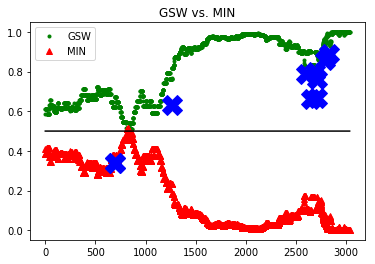

Game important plays: 
Top turning point descriptions: 
With 233.0 seconds left in quarter 4: Green Free Throw 2 of 2 (8 PTS)
With 51.0 seconds left in quarter 4: Lee Free Throw 1 of 2 (18 PTS)
With 32.0 seconds left in quarter 4: Russell 22' Jump Shot (25 PTS)
With 26.0 seconds left in quarter 4: Lee REBOUND (Off:1 Def:6)
With 38.0 seconds left in quarter 4: SUB: Ball FOR Redick
With 638.0 seconds left in quarter 4: Burks Free Throw 2 of 2 (14 PTS)
With 663.0 seconds left in quarter 4: Ball 28' 3PT Jump Shot (14 PTS) (Williams 2 AST)
With 99.0 seconds left in quarter 4: SUB: Hart FOR Favors
With 304.0 seconds left in quarter 4: Holiday  3PT Jump Shot (20 PTS) (Williams 3 AST)
With 210.0 seconds left in quarter 4: Ingram 5' Driving Finger Roll Layup (22 PTS)
Done


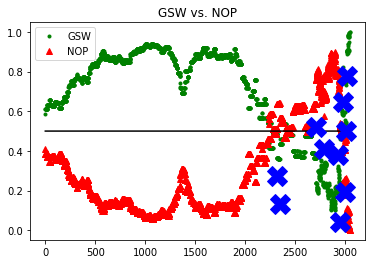

Game important plays: 
Top turning point descriptions: 
With 480.0 seconds left in quarter 4: Trent Jr. 24' 3PT Pullup Jump Shot (7 PTS) (Tolliver 2 AST)
With 458.0 seconds left in quarter 4: Spellman 1' Tip Layup Shot (5 PTS)
With 275.0 seconds left in quarter 4: McCollum 3' Driving Floating Bank Jump Shot (27 PTS)
With 692.0 seconds left in quarter 4: McCollum 24' 3PT Pullup Jump Shot (23 PTS)
With 512.0 seconds left in quarter 3: Cauley-Stein 1' Putback Dunk (10 PTS)
With 138.0 seconds left in quarter 2: Robinson III 1' Putback Layup (11 PTS)
With 132.0 seconds left in quarter 4: Whiteside REBOUND (Off:7 Def:16)
With 196.0 seconds left in quarter 4: McCollum 25' 3PT Jump Shot (30 PTS) (Lillard 12 AST)
With 546.0 seconds left in quarter 4: McCollum 1' Driving Layup (25 PTS)
With 371.0 seconds left in quarter 4: Whiteside 1' Alley Oop Dunk (12 PTS) (Lillard 11 AST)
Done


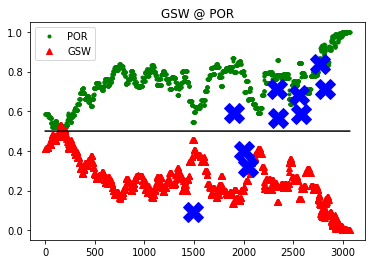

Game important plays: 
Top turning point descriptions: 
With 2.0 seconds left in quarter 2: Hield 28' 3PT Pullup Jump Shot (14 PTS)
With 401.0 seconds left in quarter 2: Ariza 27' 3PT Jump Shot (3 PTS) (Hield 3 AST)
With 585.0 seconds left in quarter 3: Hield 24' 3PT Jump Shot (17 PTS) (Bjelica 2 AST)
With 27.0 seconds left in quarter 1: Bagley III REBOUND (Off:1 Def:3)
With 663.0 seconds left in quarter 2: Bogdanovic  3PT Pullup Jump Shot (8 PTS) (Ariza 1 AST)
With 144.0 seconds left in quarter 2: Barnes 3' Driving Finger Roll Layup (8 PTS) (Bogdanovic 2 AST)
With 218.0 seconds left in quarter 1: Burks Free Throw 1 of 3 (5 PTS)
With 201.0 seconds left in quarter 2: Hield 3' Driving Layup (11 PTS)
With 681.0 seconds left in quarter 3: Kings Timeout: Regular (Reg.3 Short 0)
With 257.0 seconds left in quarter 1: Burks 26' 3PT Pullup Jump Shot (3 PTS) (Poole 1 AST)
Done


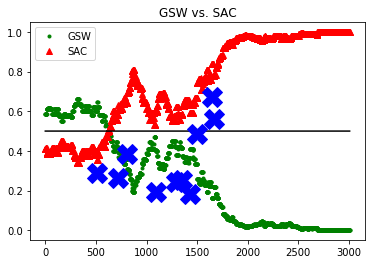

Game important plays: 
Top turning point descriptions: 
With 93.0 seconds left in quarter 4: Mitchell  3PT Jump Shot (26 PTS) (O'Neale 4 AST)
With 110.0 seconds left in quarter 4: Bogdanovic 25' 3PT Step Back Jump Shot (29 PTS)
With 209.0 seconds left in quarter 4: Mitchell REBOUND (Off:1 Def:2)
With 284.0 seconds left in quarter 4: Mudiay Lost Ball Turnover (P1.T13)#@#Russell STEAL (3 STL)
With 132.0 seconds left in quarter 4: Evans Free Throw 2 of 2 (13 PTS)
With 96.0 seconds left in quarter 3: Green  3PT Jump Shot (3 PTS) (Mudiay 2 AST)
With 332.0 seconds left in quarter 3: Bogdanovic 24' 3PT Jump Shot (19 PTS) (O'Neale 3 AST)
With 275.0 seconds left in quarter 3: Bogdanovic 24' 3PT Jump Shot (22 PTS) (Mudiay 1 AST)
With 149.0 seconds left in quarter 4: Gobert REBOUND (Off:3 Def:12)
With 375.0 seconds left in quarter 4: Gobert 2' Cutting Dunk Shot (13 PTS) (Mudiay 3 AST)
Done


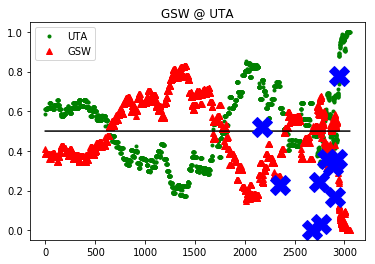

Game important plays: 
Top turning point descriptions: 
With 101.0 seconds left in quarter 4: Morris Sr. Free Throw 1 of 2 (33 PTS)
With 401.0 seconds left in quarter 4: Morris Sr. 26' 3PT Jump Shot (29 PTS) (Payton 4 AST)
With 78.0 seconds left in quarter 4: Russell Bad Pass Turnover (P2.T7)#@#Morris Sr. STEAL (2 STL)
With 419.0 seconds left in quarter 2: Burks Free Throw 2 of 2 (4 PTS)
With 54.0 seconds left in quarter 4: Morris Sr. 12' Pullup Jump Shot (35 PTS)
With 166.0 seconds left in quarter 5: Randle REBOUND (Off:3 Def:10)
With 12.0 seconds left in quarter 4: Burks Free Throw 3 of 3 (18 PTS)
With 104.0 seconds left in quarter 5: Payton 11' Floating Jump Shot (14 PTS)
With 15.0 seconds left in quarter 5: Morris Sr. REBOUND (Off:2 Def:8)
With 293.0 seconds left in quarter 2: Barrett  3PT Jump Shot (14 PTS) (Dotson 2 AST)
Done


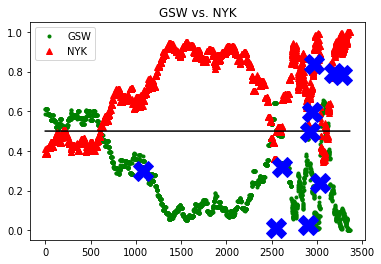

Game important plays: 
Top turning point descriptions: 
With 452.0 seconds left in quarter 3: Morant 26' 3PT Jump Shot (13 PTS)
With 360.0 seconds left in quarter 3: S. Hill 27' 3PT Jump Shot (3 PTS) (Jones 6 AST)
With 481.0 seconds left in quarter 3: Jackson Jr. 26' 3PT Pullup Jump Shot (11 PTS) (Valanciunas 4 AST)
With 225.0 seconds left in quarter 2: Allen 30' 3PT Running Pull-Up Jump Shot (11 PTS) (Jones 4 AST)
With 462.0 seconds left in quarter 2: Morant 27' 3PT Jump Shot (8 PTS)
With 406.0 seconds left in quarter 2: Brooks Free Throw 1 of 2 (12 PTS)
With 515.0 seconds left in quarter 2: Brooks 27' 3PT Jump Shot (10 PTS) (Morant 5 AST)
With 337.0 seconds left in quarter 3: Allen 2' Running Dunk (15 PTS) (Jones 7 AST)
With 515.0 seconds left in quarter 3: Valanciunas 4' Driving Hook Shot (13 PTS) (Morant 6 AST)
With 6.0 seconds left in quarter 3: Jones 25' 3PT Jump Shot (5 PTS) (S. Hill 2 AST)
Done


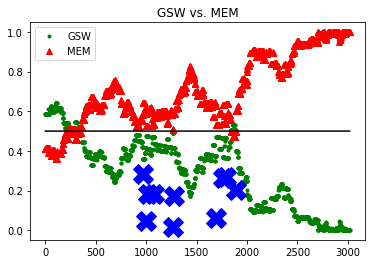

Game important plays: 
Top turning point descriptions: 
With 63.0 seconds left in quarter 4: Robinson III 1' Alley Oop Dunk (20 PTS) (Green 5 AST)
With 2.0 seconds left in quarter 4: Green REBOUND (Off:0 Def:4)
With 116.0 seconds left in quarter 3: White 25' 3PT Jump Shot (11 PTS) (Valentine 2 AST)
With 86.0 seconds left in quarter 4: Green Free Throw 1 of 2 (9 PTS)
With 527.0 seconds left in quarter 4: Valentine 29' 3PT Jump Shot (11 PTS) (Harrison 1 AST)
With 265.0 seconds left in quarter 3: Arcidiacono 26' 3PT Jump Shot (3 PTS) (LaVine 6 AST)
With 45.0 seconds left in quarter 4: Robinson III REBOUND (Off:0 Def:6)
With 470.0 seconds left in quarter 4: SUB: Russell FOR Burks
With 288.0 seconds left in quarter 4: Dunn REBOUND (Off:2 Def:2)
With 58.0 seconds left in quarter 2: LaVine 28' 3PT Jump Shot (6 PTS)
Done


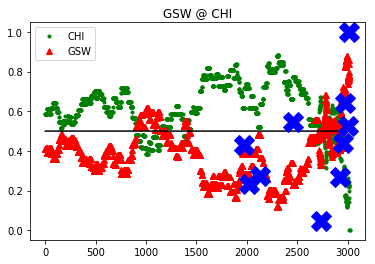

Game important plays: 
Top turning point descriptions: 
With 395.0 seconds left in quarter 3: Batum  3PT Jump Shot (3 PTS) (Rozier 5 AST)
With 686.0 seconds left in quarter 2: Graham 27' 3PT Jump Shot (8 PTS) (Batum 2 AST)
With 158.0 seconds left in quarter 1: Rozier 24' 3PT Step Back Jump Shot (12 PTS)
With 259.0 seconds left in quarter 1: Zeller REBOUND (Off:3 Def:1)
With 431.0 seconds left in quarter 1: Rozier 26' 3PT Running Jump Shot (9 PTS) (Graham 2 AST)
With 438.0 seconds left in quarter 1: Russell Lost Ball Turnover (P1.T1)#@#Graham STEAL (1 STL)
With 681.0 seconds left in quarter 1: Rozier REBOUND (Off:0 Def:1)
With 514.0 seconds left in quarter 1: Biyombo REBOUND (Off:0 Def:1)
With 361.0 seconds left in quarter 1: Washington REBOUND (Off:0 Def:1)
With 663.0 seconds left in quarter 1: Rozier REBOUND (Off:0 Def:2)
Done


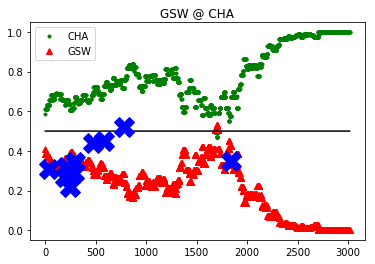

Game important plays: 
Top turning point descriptions: 
With 285.0 seconds left in quarter 2: Paschall 1' Tip Dunk Shot (12 PTS)
With 179.0 seconds left in quarter 2: Carter 26' 3PT Jump Shot (3 PTS) (Turner 2 AST)
With 127.0 seconds left in quarter 2: Young 24' 3PT Jump Shot (10 PTS) (Jones 1 AST)
With 338.0 seconds left in quarter 2: Parker REBOUND (Off:1 Def:2)
With 75.0 seconds left in quarter 2: Hunter 26' 3PT Jump Shot (13 PTS) (Turner 3 AST)
With 223.0 seconds left in quarter 1: Young Bad Pass Turnover (P3.T4)#@#Chriss STEAL (1 STL)
With 412.0 seconds left in quarter 2: Young 29' 3PT Jump Shot (7 PTS)
With 608.0 seconds left in quarter 3: Bembry 25' 3PT Jump Shot (3 PTS) (Young 3 AST)
With 332.0 seconds left in quarter 1: Burks 25' 3PT Jump Shot (3 PTS) (Chriss 1 AST)
With 477.0 seconds left in quarter 2: Parker 1' Driving Layup (4 PTS)
Done


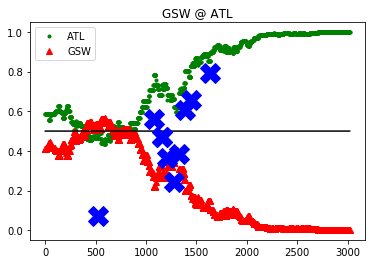

Game important plays: 
Top turning point descriptions: 
With 83.0 seconds left in quarter 4: Ross 26' 3PT Jump Shot (19 PTS) (Birch 3 AST)
With 287.0 seconds left in quarter 4: Fournier 26' 3PT Step Back Jump Shot (30 PTS) (Fultz 9 AST)
With 334.0 seconds left in quarter 3: Fournier 27' 3PT Jump Shot (24 PTS) (Fultz 7 AST)
With 7.0 seconds left in quarter 4: MISS Burks Free Throw 2 of 2
With 121.0 seconds left in quarter 4: Fournier REBOUND (Off:1 Def:3)
With 210.0 seconds left in quarter 4: Robinson III  3PT Jump Shot (19 PTS) (Green 6 AST)
With 0.0 seconds left in quarter 4: Gordon REBOUND (Off:1 Def:6)
With 354.0 seconds left in quarter 4: Isaac 2' Cutting Dunk Shot (14 PTS) (Fultz 8 AST)
With 511.0 seconds left in quarter 4: Ross 18' Pullup Jump Shot (16 PTS) (Gordon 4 AST)
With 71.0 seconds left in quarter 2: Ross 26' 3PT Jump Shot (12 PTS) (Fultz 5 AST)
Done


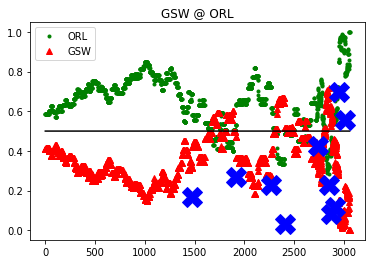

Game important plays: 
Top turning point descriptions: 
With 259.0 seconds left in quarter 3: Herro  3PT Jump Shot (13 PTS) (Butler 6 AST)
With 488.0 seconds left in quarter 3: Robinson 25' 3PT Jump Shot (17 PTS) (Adebayo 2 AST)
With 322.0 seconds left in quarter 2: Poole Free Throw 2 of 2 (11 PTS)
With 256.0 seconds left in quarter 2: Cauley-Stein 1' Tip Dunk Shot (2 PTS)
With 352.0 seconds left in quarter 2: Nunn  3PT Jump Shot (9 PTS) (Butler 5 AST)
With 161.0 seconds left in quarter 2: Cauley-Stein Bad Pass Turnover (P1.T2)#@#Olynyk STEAL (1 STL)
With 683.0 seconds left in quarter 1: Adebayo REBOUND (Off:0 Def:1)
With 614.0 seconds left in quarter 1: Leonard REBOUND (Off:0 Def:1)
With 431.0 seconds left in quarter 2: HEAT Timeout: Regular (Full 1 Short 0)
With 208.0 seconds left in quarter 1: Herro 24' 3PT Jump Shot (3 PTS) (Dragic 1 AST)
Done


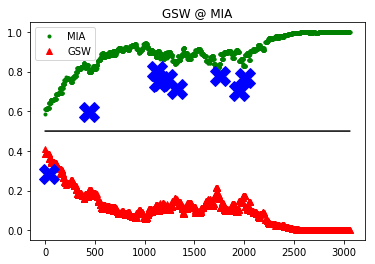

Game important plays: 
Top turning point descriptions: 
With 393.0 seconds left in quarter 4: Paschall  3PT Jump Shot (23 PTS) (Robinson III 2 AST)
With 37.0 seconds left in quarter 2: Bowman 24' 3PT Jump Shot (5 PTS) (Burks 3 AST)
With 0.0 seconds left in quarter 2: End of 2nd Period (11:41 PM EST)
With 649.0 seconds left in quarter 3: Burks 7' Driving Floating Jump Shot (9 PTS) (Robinson III 1 AST)
With 390.0 seconds left in quarter 3: Paschall 1' Tip Layup Shot (18 PTS)
With 424.0 seconds left in quarter 3: Chriss 1' Cutting Dunk Shot (6 PTS) (Green 5 AST)
With 481.0 seconds left in quarter 3: Chriss 3' Layup (4 PTS) (Green 4 AST)
With 498.0 seconds left in quarter 3: WARRIORS Timeout: Regular (Full 3 Short 0)
With 232.0 seconds left in quarter 1: Paschall 25' 3PT Jump Shot (9 PTS) (Cauley-Stein 1 AST)
With 32.0 seconds left in quarter 1: Spellman REBOUND (Off:1 Def:2)
Done


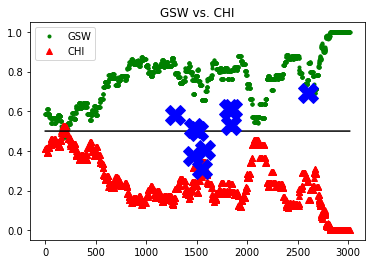

Game important plays: 
Top turning point descriptions: 
With 78.0 seconds left in quarter 4: WARRIORS Timeout: Regular (Full 6 Short 0)
With 22.0 seconds left in quarter 4: Gilgeous-Alexander Free Throw 1 of 2 (11 PTS)
With 656.0 seconds left in quarter 4: Poole 25' 3PT Pullup Jump Shot (8 PTS) (Chriss 5 AST)
With 22.0 seconds left in quarter 4: Thunder Rebound
With 210.0 seconds left in quarter 4: Paschall REBOUND (Off:2 Def:8)
With 92.0 seconds left in quarter 4: Adams Free Throw 2 of 2 (10 PTS)
With 117.0 seconds left in quarter 4: Paschall Offensive Foul Turnover (P5.T12)
With 286.0 seconds left in quarter 4: Cauley-Stein REBOUND (Off:2 Def:4)
With 0.0 seconds left in quarter 2: Instant Replay2nd Period (11:34 PM EST)
With 63.0 seconds left in quarter 2: Robinson III 28' 3PT Running Jump Shot (18 PTS) (Cauley-Stein 1 AST)
Done


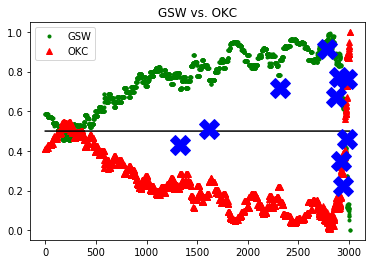

Game important plays: 
Top turning point descriptions: 
With 16.0 seconds left in quarter 4: Warriors Timeout: Regular (Reg.6 Short 0)
With 199.0 seconds left in quarter 4: Burks Traveling Turnover (P1.T8)
With 582.0 seconds left in quarter 2: Mitchell 25' 3PT Jump Shot (10 PTS) (O'Neale 3 AST)
With 17.0 seconds left in quarter 4: Conley Free Throw 1 of 2 (27 PTS)
With 92.0 seconds left in quarter 4: Conley 25' 3PT Jump Shot (26 PTS)
With 11.0 seconds left in quarter 4: Conley REBOUND (Off:0 Def:4)
With 0.0 seconds left in quarter 1: Mitchell 26' 3PT Jump Shot (7 PTS) (Exum 1 AST)
With 406.0 seconds left in quarter 2: Conley 25' 3PT Step Back Jump Shot (12 PTS)
With 538.0 seconds left in quarter 3: Conley  3PT Jump Shot (17 PTS) (Mitchell 4 AST)
With 252.0 seconds left in quarter 1: Bogdanovic 25' 3PT Step Back Jump Shot (5 PTS)
Done


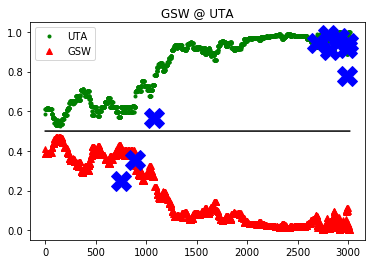

Game important plays: 
Top turning point descriptions: 
With 690.0 seconds left in quarter 1: MAVERICKS Rebound
With 634.0 seconds left in quarter 1: Porzingis REBOUND (Off:0 Def:1)
With 556.0 seconds left in quarter 1: Doncic REBOUND (Off:0 Def:1)
With 578.0 seconds left in quarter 1: Porzingis 25' 3PT Jump Shot (3 PTS) (Powell 1 AST)
With 484.0 seconds left in quarter 1: Hardaway Jr. 26' 3PT Jump Shot (8 PTS) (Finney-Smith 2 AST)
With 520.0 seconds left in quarter 1: Doncic 26' 3PT Step Back Jump Shot (9 PTS)
With 546.0 seconds left in quarter 1: Hardaway Jr.  3PT Jump Shot (5 PTS) (Finney-Smith 1 AST)
With 461.0 seconds left in quarter 1: Doncic REBOUND (Off:0 Def:2)
With 670.0 seconds left in quarter 1: Doncic 28' 3PT Jump Shot (6 PTS) (Hardaway Jr. 1 AST)
With 427.0 seconds left in quarter 1: Finney-Smith REBOUND (Off:1 Def:1)
Done


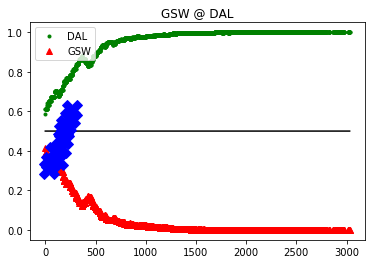

Game important plays: 
Top turning point descriptions: 
With 57.0 seconds left in quarter 1: Equipment Malfunction
With 248.0 seconds left in quarter 3: Bowman  3PT Jump Shot (3 PTS) (Poole 3 AST)
With 551.0 seconds left in quarter 1: Paschall Free Throw 1 of 1 (5 PTS)
With 508.0 seconds left in quarter 2: Chriss 1' Layup (7 PTS) (Poole 2 AST)
With 367.0 seconds left in quarter 2: Cauley-Stein 1' Running Dunk (4 PTS)
With 50.0 seconds left in quarter 3: Jones Lost Ball Turnover (P1.T10)#@#Burks STEAL (1 STL)
With 380.0 seconds left in quarter 2: Cauley-Stein Free Throw 1 of 2 (1 PTS)
With 330.0 seconds left in quarter 2: Burks 19' Jump Shot (9 PTS) (Green 6 AST)
With 453.0 seconds left in quarter 2: Chriss Free Throw 1 of 2 (8 PTS)
With 480.0 seconds left in quarter 1: Crowder 26' 3PT Step Back Jump Shot (3 PTS)
Done


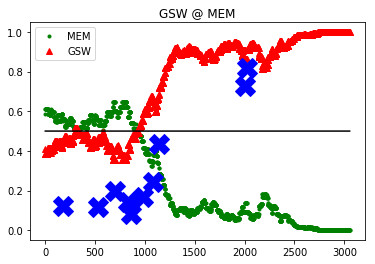

Game important plays: 
Top turning point descriptions: 
With 49.0 seconds left in quarter 2: Redick 25' 3PT Jump Shot (17 PTS) (Holiday 6 AST)
With 216.0 seconds left in quarter 1: Paschall Free Throw 2 of 2 (10 PTS)
With 458.0 seconds left in quarter 2: Alexander-Walker 26' 3PT Jump Shot (5 PTS) (Melli 2 AST)
With 323.0 seconds left in quarter 2: Alexander-Walker 25' 3PT Jump Shot (11 PTS) (Redick 2 AST)
With 652.0 seconds left in quarter 3: Holiday REBOUND (Off:4 Def:1)
With 589.0 seconds left in quarter 4: Holiday 2' Driving Layup (14 PTS)
With 681.0 seconds left in quarter 2: Melli 26' 3PT Jump Shot (3 PTS) (Alexander-Walker 1 AST)
With 636.0 seconds left in quarter 2: Moore 24' 3PT Jump Shot (6 PTS) (Melli 1 AST)
With 402.0 seconds left in quarter 2: Alexander-Walker 26' 3PT Jump Shot (8 PTS) (Gray 1 AST)
With 66.0 seconds left in quarter 1: Redick 25' 3PT Jump Shot (14 PTS) (Holiday 5 AST)
Done


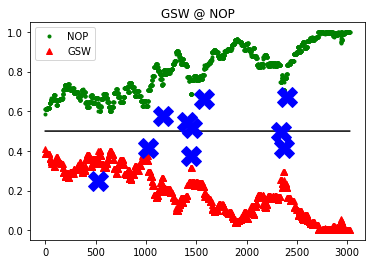

Game important plays: 
Top turning point descriptions: 
With 532.0 seconds left in quarter 4: Robinson III REBOUND (Off:1 Def:3)
With 569.0 seconds left in quarter 4: Burks 5' Layup (20 PTS)
With 581.0 seconds left in quarter 4: Spellman Free Throw 2 of 2 (6 PTS)
With 609.0 seconds left in quarter 4: Burks Free Throw 1 of 2 (17 PTS)
With 646.0 seconds left in quarter 4: Green Free Throw 2 of 2 (9 PTS)
With 669.0 seconds left in quarter 4: MISS Burks Free Throw 2 of 2
With 630.0 seconds left in quarter 2: Burks 28' 3PT Pullup Jump Shot (7 PTS) (Green 3 AST)
With 310.0 seconds left in quarter 2: Paschall 4' Driving Finger Roll Layup (9 PTS) (Russell 4 AST)
With 358.0 seconds left in quarter 2: Cauley-Stein 1' Alley Oop Dunk (4 PTS) (Burks 1 AST)
With 249.0 seconds left in quarter 2: Paschall 2' Driving Layup (11 PTS)
Done


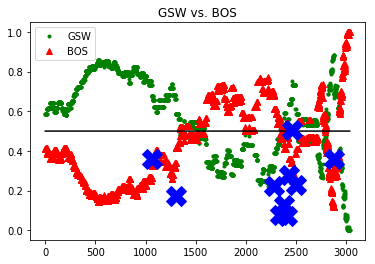

Game important plays: 
Top turning point descriptions: 
With 182.0 seconds left in quarter 2: James REBOUND (Off:2 Def:2)
With 645.0 seconds left in quarter 2: Spellman 1' Tip Layup Shot (2 PTS)
With 266.0 seconds left in quarter 2: LAKERS Timeout: Regular (Full 2 Short 0)
With 364.0 seconds left in quarter 1: James REBOUND (Off:1 Def:1)
With 612.0 seconds left in quarter 3: Green  3PT Jump Shot (6 PTS) (James 8 AST)
With 319.0 seconds left in quarter 1: Dudley 25' 3PT Jump Shot (6 PTS) (James 4 AST)
With 439.0 seconds left in quarter 1: Dudley 26' 3PT Jump Shot (3 PTS) (James 3 AST)
With 206.0 seconds left in quarter 2: James 22' Step Back Jump Shot (17 PTS)
With 544.0 seconds left in quarter 1: Kuzma REBOUND (Off:0 Def:2)
With 633.0 seconds left in quarter 1: Russell Bad Pass Turnover (P1.T1)#@#McGee STEAL (1 STL)
Done


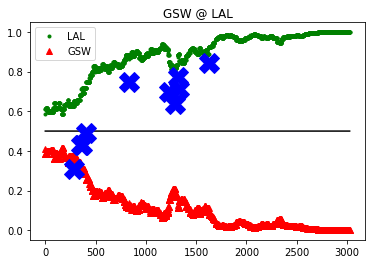

Game important plays: 
Top turning point descriptions: 
With 333.0 seconds left in quarter 2: Conley 26' 3PT Jump Shot (6 PTS)
With 263.0 seconds left in quarter 2: Conley  3PT Jump Shot (9 PTS) (Bogdanovic 2 AST)
With 206.0 seconds left in quarter 2: Mitchell 30' 3PT Pullup Jump Shot (13 PTS)
With 107.0 seconds left in quarter 2: Mitchell 26' 3PT Jump Shot (16 PTS) (Ingles 6 AST)
With 669.0 seconds left in quarter 1: Gobert S.FOUL (P1.T1) (S.Wright)
With 76.0 seconds left in quarter 2: Mitchell 29' 3PT Pullup Jump Shot (19 PTS) (Gobert 1 AST)
With 232.0 seconds left in quarter 1: SUB: Mudiay FOR Conley
With 556.0 seconds left in quarter 3: Bogdanovic 25' 3PT Jump Shot (9 PTS) (Conley 2 AST)
With 40.0 seconds left in quarter 3: Green 26' 3PT Pullup Jump Shot (7 PTS) (Mudiay 1 AST)
With 11.0 seconds left in quarter 3: Green 24' 3PT Jump Shot (10 PTS) (Mitchell 3 AST)
Done


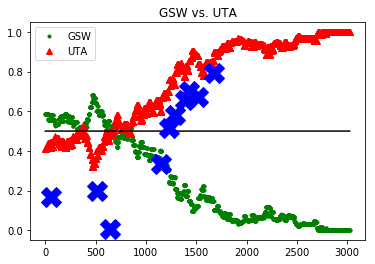

Game important plays: 
Top turning point descriptions: 
With 595.0 seconds left in quarter 4: Muscala 26' 3PT Jump Shot (6 PTS) (Paul 7 AST)
With 0.0 seconds left in quarter 3: Instant Replay3rd Period (9:43 PM EST)
With 485.0 seconds left in quarter 4: Muscala 27' 3PT Jump Shot (9 PTS) (Paul 8 AST)
With 699.0 seconds left in quarter 4: Gilgeous-Alexander 3' Driving Layup (8 PTS) (Paul 6 AST)
With 575.0 seconds left in quarter 4: Gilgeous-Alexander 1' Running Layup (10 PTS) (Muscala 1 AST)
With 90.0 seconds left in quarter 3: Schroder 17' Pullup Jump Shot (12 PTS)
With 543.0 seconds left in quarter 4: Paul 21' Pullup Jump Shot (10 PTS)
With 46.0 seconds left in quarter 3: Schroder Free Throw 1 of 2 (13 PTS)
With 5.0 seconds left in quarter 1: Bazley  3PT Jump Shot (3 PTS) (Paul 1 AST)
With 74.0 seconds left in quarter 3: SUB: Poole FOR Lee
Done


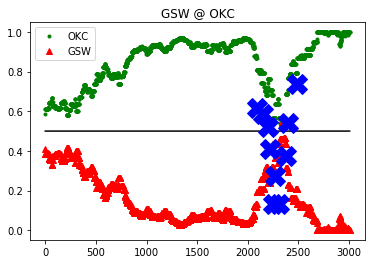

Game important plays: 
Top turning point descriptions: 
With 132.0 seconds left in quarter 4: Russell 26' 3PT Pullup Jump Shot (43 PTS)
With 5.0 seconds left in quarter 4: Warriors Timeout: Regular (Reg.5 Short 0)
With 14.0 seconds left in quarter 4: Paschall Bad Pass Turnover (P2.T17)#@#Covington STEAL (4 STL)
With 84.0 seconds left in quarter 4: Russell REBOUND (Off:0 Def:8)
With 371.0 seconds left in quarter 4: Burks Free Throw Flagrant 1 of 2 (18 PTS)
With 29.0 seconds left in quarter 4: Russell 21' Step Back Jump Shot (45 PTS)
With 300.0 seconds left in quarter 4: Russell 16' Pullup Jump Shot (33 PTS)
With 615.0 seconds left in quarter 3: Towns  3PT Jump Shot (11 PTS) (Culver 1 AST)
With 386.0 seconds left in quarter 4: Cauley-Stein 1' Tip Layup Shot (2 PTS)
With 174.0 seconds left in quarter 4: Cauley-Stein REBOUND (Off:2 Def:6)
Done


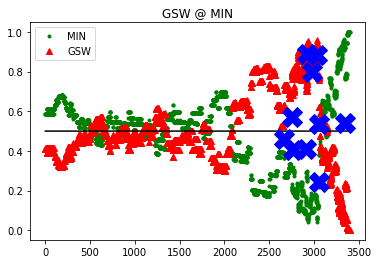

Game important plays: 
Top turning point descriptions: 
With 637.0 seconds left in quarter 2: SUB: Chriss FOR Spellman
With 212.0 seconds left in quarter 2: Harden 27' 3PT Step Back Jump Shot (12 PTS)
With 121.0 seconds left in quarter 2: Harden 26' 3PT Step Back Jump Shot (19 PTS)
With 339.0 seconds left in quarter 2: Harden S.FOUL (P1.PN) (M.Davis)
With 64.0 seconds left in quarter 2: Westbrook 25' 3PT Jump Shot (9 PTS) (Harden 4 AST)
With 24.0 seconds left in quarter 1: Sefolosha 2' Layup (2 PTS)
With 102.0 seconds left in quarter 1: Rivers 25' 3PT Jump Shot (6 PTS)
With 27.0 seconds left in quarter 2: Harden 27' 3PT Step Back Jump Shot (22 PTS)
With 80.0 seconds left in quarter 1: Rivers 25' 3PT Jump Shot (9 PTS) (Sefolosha 2 AST)
With 607.0 seconds left in quarter 3: House Jr.  3PT Jump Shot (6 PTS) (Westbrook 3 AST)
Done


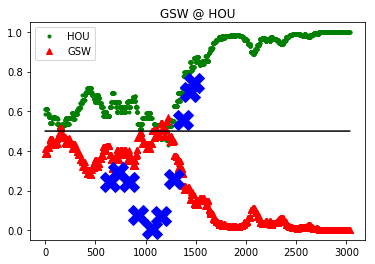

Game important plays: 
Top turning point descriptions: 
With 687.0 seconds left in quarter 4: Poole 26' 3PT Step Back Jump Shot (8 PTS) (Lee 1 AST)
With 369.0 seconds left in quarter 3: Bowman  3PT Jump Shot (17 PTS) (Poole 5 AST)
With 397.0 seconds left in quarter 4: Burks 5' Running Layup (12 PTS)
With 110.0 seconds left in quarter 2: Poole 27' 3PT Step Back Jump Shot (5 PTS)
With 448.0 seconds left in quarter 4: Lee 20' Pullup Jump Shot (12 PTS) (Bowman 7 AST)
With 310.0 seconds left in quarter 4: Paschall 27' 3PT Jump Shot (28 PTS) (Bowman 8 AST)
With 498.0 seconds left in quarter 4: SUB: McCollum FOR Simons
With 575.0 seconds left in quarter 4: WARRIORS Timeout: Regular (Full 4 Short 0)
With 252.0 seconds left in quarter 2: Chriss 29' 3PT Pullup Jump Shot (3 PTS) (Bowman 4 AST)
With 373.0 seconds left in quarter 4: Bowman 3' Running Layup (19 PTS)
Done


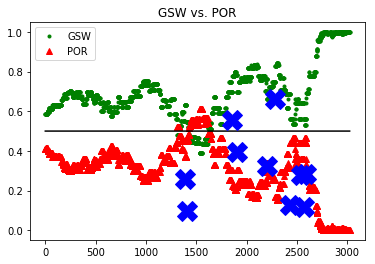

Game important plays: 
Top turning point descriptions: 
With 166.0 seconds left in quarter 4: Washington 26' 3PT Jump Shot (11 PTS) (Rozier 7 AST)
With 76.0 seconds left in quarter 4: Paschall Free Throw 1 of 2 (25 PTS)
With 69.0 seconds left in quarter 4: Lee S.FOUL (P3.T3) (J.Butler)
With 204.0 seconds left in quarter 4: Williams 26' 3PT Jump Shot (9 PTS) (Bacon 2 AST)
With 12.0 seconds left in quarter 4: Martin Free Throw 1 of 2 (1 PTS)
With 44.0 seconds left in quarter 4: Graham REBOUND (Off:2 Def:6)
With 415.0 seconds left in quarter 4: Bacon 2' Driving Layup (25 PTS) (Monk 2 AST)
With 471.0 seconds left in quarter 4: Paschall 19' Jump Shot (22 PTS)
With 509.0 seconds left in quarter 4: Bowman 16' Jump Shot (13 PTS) (Chriss 2 AST)
With 337.0 seconds left in quarter 4: Monk 2' Layup (9 PTS)
Done


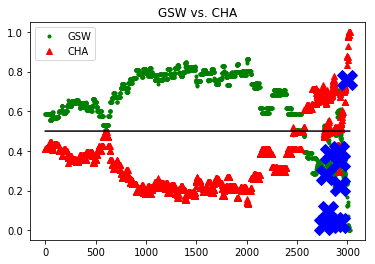

Game important plays: 
Top turning point descriptions: 
With 644.0 seconds left in quarter 3: Poole 27' 3PT Pullup Jump Shot (11 PTS) (Russell 6 AST)
With 513.0 seconds left in quarter 3: Forbes 27' 3PT Jump Shot (8 PTS) (DeRozan 9 AST)
With 126.0 seconds left in quarter 2: Forbes 26' 3PT Jump Shot (5 PTS) (DeRozan 5 AST)
With 407.0 seconds left in quarter 3: Forbes 26' 3PT Jump Shot (14 PTS) (White 1 AST)
With 399.0 seconds left in quarter 2: Mills 27' 3PT Pullup Jump Shot (16 PTS)
With 181.0 seconds left in quarter 3: DeRozan 8' Turnaround Jump Shot (8 PTS)
With 134.0 seconds left in quarter 3: Mills  3PT Jump Shot (19 PTS) (DeRozan 11 AST)
With 632.0 seconds left in quarter 2: Gay 26' 3PT Jump Shot (10 PTS)
With 666.0 seconds left in quarter 4: Mills 27' 3PT Pullup Jump Shot (24 PTS) (Carroll 1 AST)
With 565.0 seconds left in quarter 3: Aldridge 20' Jump Shot (16 PTS) (DeRozan 7 AST)
Done


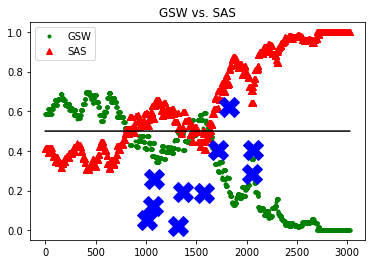

Game important plays: 
Top turning point descriptions: 
With 359.0 seconds left in quarter 1: Rubio 25' 3PT Jump Shot (5 PTS) (Baynes 1 AST)
With 334.0 seconds left in quarter 1: Rubio  3PT Jump Shot (8 PTS) (Baynes 2 AST)
With 386.0 seconds left in quarter 1: Baynes 24' 3PT Jump Shot (10 PTS) (Rubio 2 AST)
With 284.0 seconds left in quarter 1: Booker 25' 3PT Jump Shot (3 PTS) (Baynes 3 AST)
With 363.0 seconds left in quarter 1: Rubio REBOUND (Off:0 Def:1)
With 646.0 seconds left in quarter 1: Russell REBOUND (Off:0 Def:2)
With 660.0 seconds left in quarter 1: Russell REBOUND (Off:0 Def:1)
With 689.0 seconds left in quarter 1: Oubre Jr. Bad Pass Turnover (P1.T1)#@#Curry STEAL (1 STL)
With 608.0 seconds left in quarter 1: Rubio Free Throw 2 of 2 (2 PTS)
With 588.0 seconds left in quarter 1: Paschall REBOUND (Off:0 Def:1)
Done


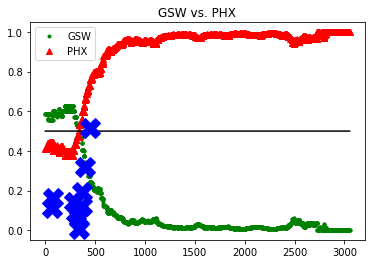

Game important plays: 
Top turning point descriptions: 
With 87.0 seconds left in quarter 2: Delay Technical
With 667.0 seconds left in quarter 2: Lee 25' 3PT Jump Shot (3 PTS) (Green 2 AST)
With 615.0 seconds left in quarter 2: Curry 26' 3PT Jump Shot (7 PTS) (Robinson III 1 AST)
With 122.0 seconds left in quarter 2: Green S.FOUL (P1.T2) (G.Petraitis)
With 686.0 seconds left in quarter 1: Hart REBOUND (Off:0 Def:1)
With 647.0 seconds left in quarter 3: Robinson III 2' Cutting Finger Roll Layup Shot (12 PTS) (Curry 7 AST)
With 570.0 seconds left in quarter 1: Ingram REBOUND (Off:1 Def:1)
With 570.0 seconds left in quarter 1: Ingram REBOUND (Off:1 Def:1)
With 709.0 seconds left in quarter 1: Green 2' Driving Layup (2 PTS) (Curry 1 AST)
With 694.0 seconds left in quarter 1: Green REBOUND (Off:0 Def:1)
Done


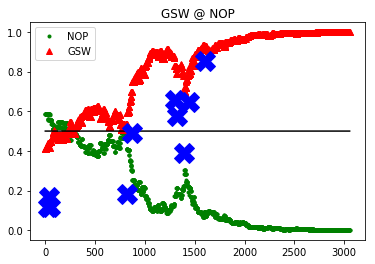

Game important plays: 
Top turning point descriptions: 
With 137.0 seconds left in quarter 1: Noel REBOUND (Off:1 Def:0)
With 225.0 seconds left in quarter 1: Schroder 28' 3PT Jump Shot (3 PTS) (Gilgeous-Alexander 3 AST)
With 4.0 seconds left in quarter 1: Paul 25' 3PT Step Back Jump Shot (7 PTS)
With 687.0 seconds left in quarter 1: Curry Bad Pass Turnover (P1.T1)#@#Paul STEAL (1 STL)
With 667.0 seconds left in quarter 1: Green Out of Bounds Lost Ball Turnover (P1.T2)
With 600.0 seconds left in quarter 1: Warriors Turnover: Shot Clock (T#3)
With 577.0 seconds left in quarter 1: Robinson III Traveling Turnover (P1.T4)
With 441.0 seconds left in quarter 1: Curry Traveling Turnover (P2.T5)
With 550.0 seconds left in quarter 1: Gallinari REBOUND (Off:0 Def:1)
With 230.0 seconds left in quarter 1: Bazley REBOUND (Off:0 Def:1)
Done


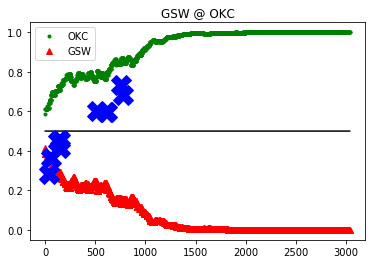

Game important plays: 
Top turning point descriptions: 
With 143.0 seconds left in quarter 2: Williams Free Throw 1 of 2 (16 PTS)
With 101.0 seconds left in quarter 2: Patterson  3PT Jump Shot (11 PTS) (Williams 2 AST)
With 606.0 seconds left in quarter 2: Green 26' 3PT Jump Shot (3 PTS) (Leonard 4 AST)
With 372.0 seconds left in quarter 1: Zubac REBOUND (Off:0 Def:4)
With 378.0 seconds left in quarter 2: Beverley 27' 3PT Pullup Jump Shot (3 PTS) (Leonard 5 AST)
With 688.0 seconds left in quarter 3: Shamet 27' 3PT Pullup Jump Shot (3 PTS) (Leonard 6 AST)
With 652.0 seconds left in quarter 3: Shamet 24' 3PT Pullup Jump Shot (6 PTS) (Leonard 7 AST)
With 285.0 seconds left in quarter 1: Williams 26' 3PT Pullup Jump Shot (3 PTS) (Beverley 2 AST)
With 615.0 seconds left in quarter 1: Zubac Free Throw 1 of 1 (5 PTS)
With 490.0 seconds left in quarter 2: Leonard 6' Jump Shot (6 PTS)
Done


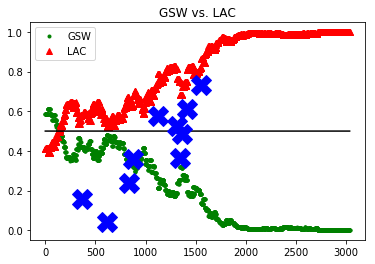

In [16]:
generate_win_probability_team('GSW', 'game')